In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import plot
import predict

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import os
import math
import torch
import torchaudio
import pytorch_lightning as pl

import dynamic_strf.modeling as modeling
import dynamic_strf.estimate as estimate
import dynamic_strf.visualize as visualize

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [6]:
e = exp.load('reg_experiment_07', experiment_location='experiments', datadir='Mdata')
e.trials

null_adjusted_LL num_filters  num_inh_percent    expt kernel_widths  \
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr      activity            name  \
0        6000  cnim_scaffold  0.000000e+00  cnim_scaffold0   
0        6000  cnim_scaffold  1.000000e+00  cnim_scaffold1   
0        6000  cnim_scaffold  5.000000e-01  cnim_scaffold2   
0        6000  cnim_scaffold  1.000000e-01  cnim_scaffold3   
0        6000  cnim_scaffold  1.000000e-02  cnim_scaffold4   
0        6000  cnim_scaffold  1.000000e-03  cnim_scaffold5   
0        6000  cnim_scaffold  1.000000e-04  cnim_scaffold6   
0        6000  cnim_scaffold  1.000000e-05  cnim_scaffold7   
0        6000  cnim_scaffold  1.000000e-06  cnim_scaffold8   
0        6000  cnim_scaffold  1.000000e-07  cnim_scaffold9   

                                         trial  mean_LLs  
0  <experiment.Trial object at 0x7fa36c540550>  0.475560  
0  <experiment.Trial object at 0x7fa36c94b880>  0.286034  
0  <experiment.Trial object at 0x7fa36c59eee0>  0.336320  
0  <experiment.Trial object at 0x7fa36c39b610>  0.413781  
0  <experiment.Trial object at 0x7fa36c484a00>  0.463517  
0  <experiment.Trial object at 0x7fa36cbef3d0>  0.451843  
0  <experiment.Trial object at 0x7fa36c57b700>  0.465908  
0  <experiment.Trial object at 0x7fa36c5400d0>  0.476332  
0  <experiment.Trial object at 0x7fa36c57b310>  0.473080  
0  <experiment.Trial object at 0x7fa36c540d90>  0.482536

1.0


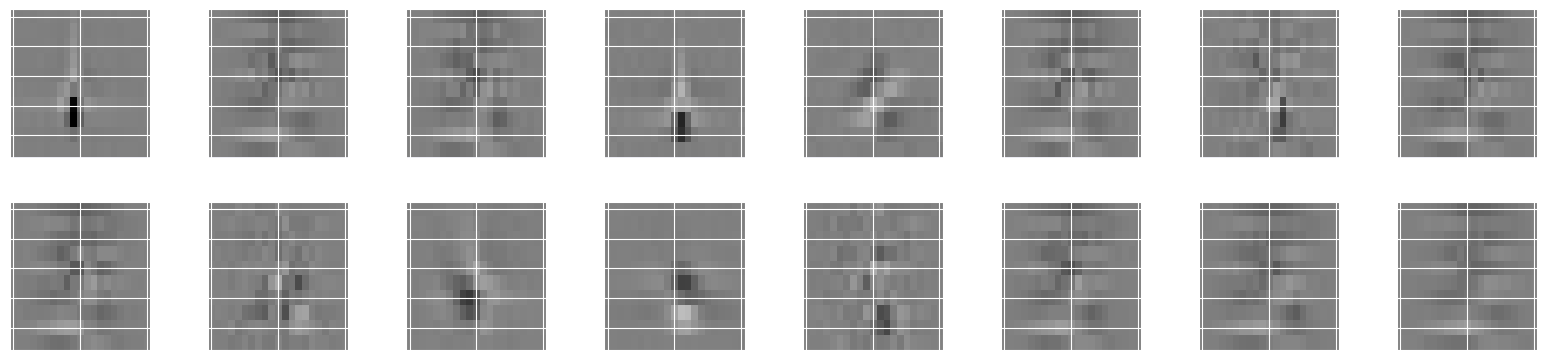

0.1


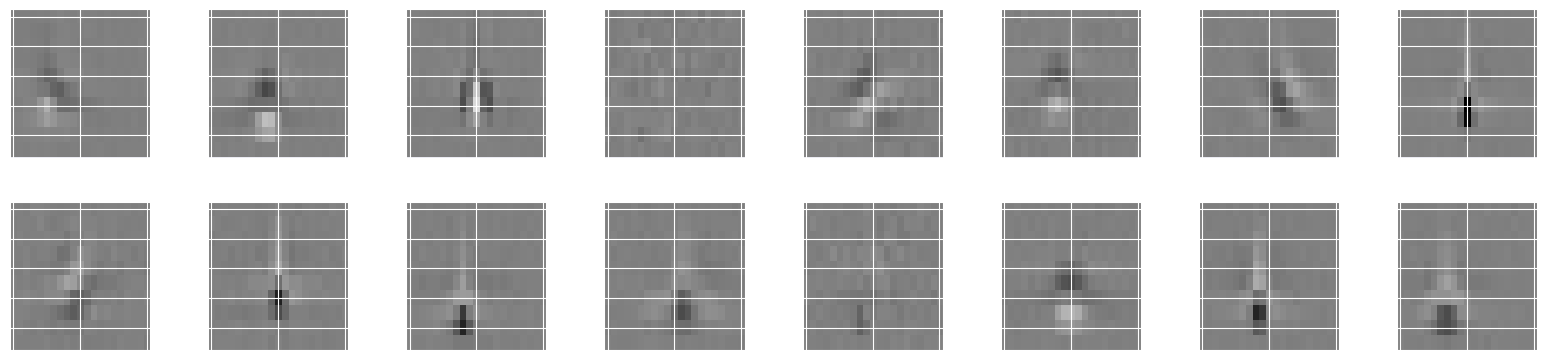

0.01


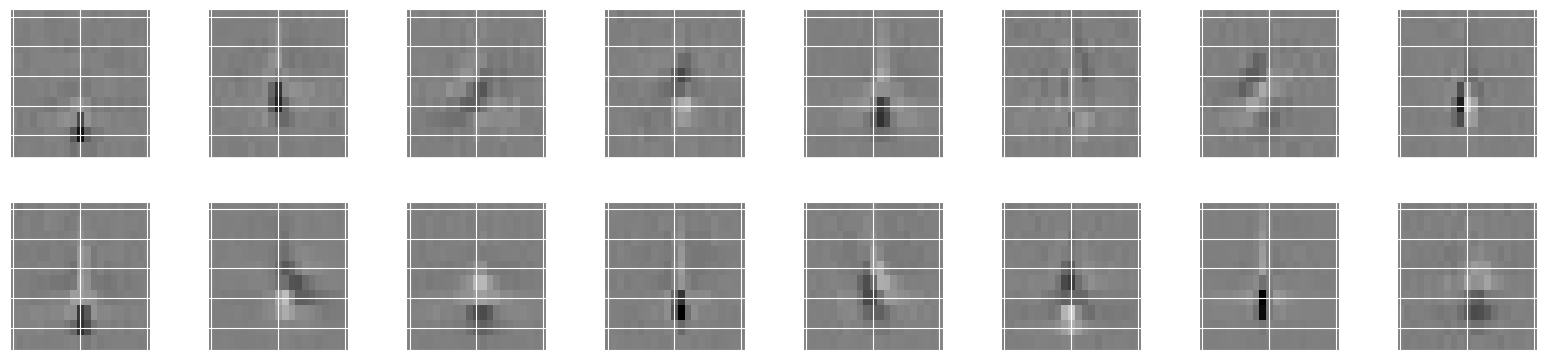

0.001


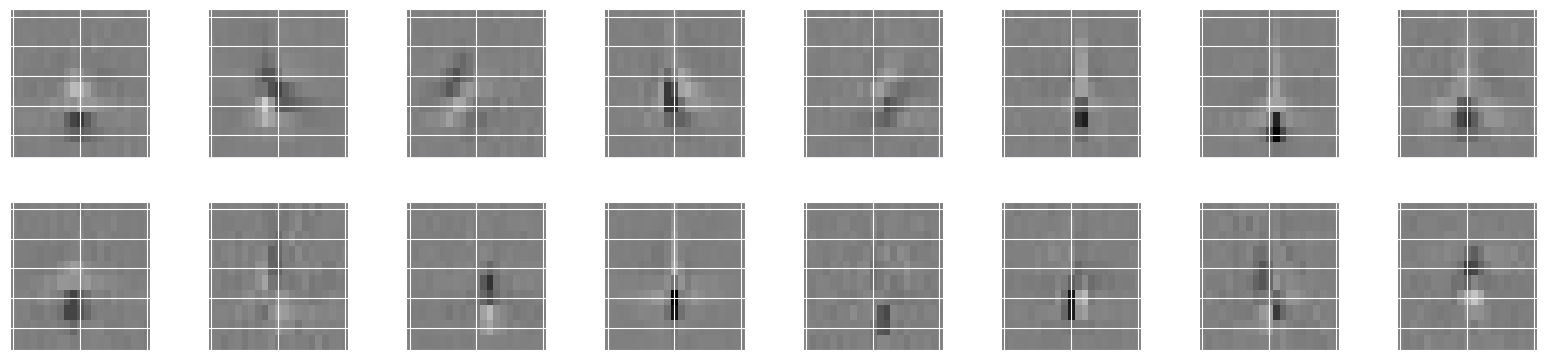

0.0001


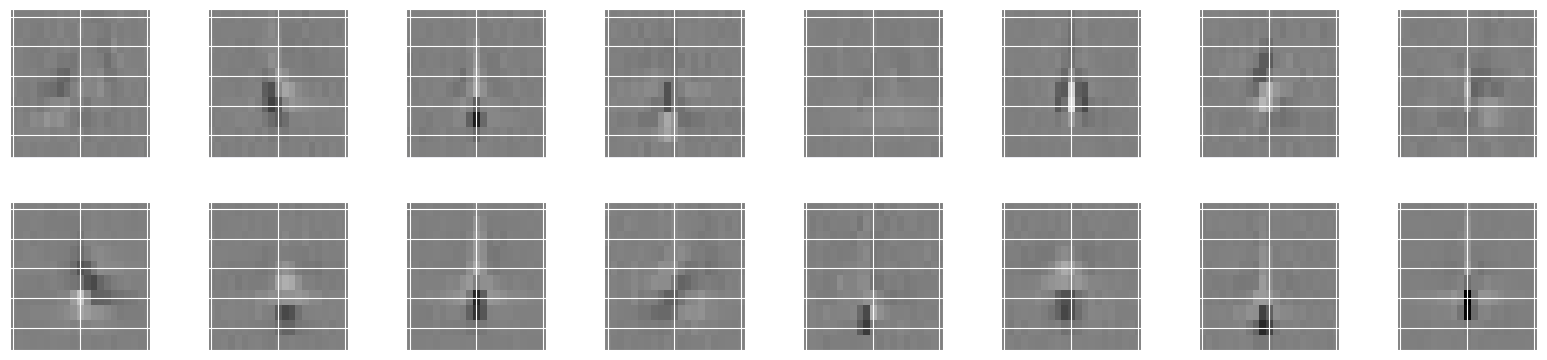

1e-05


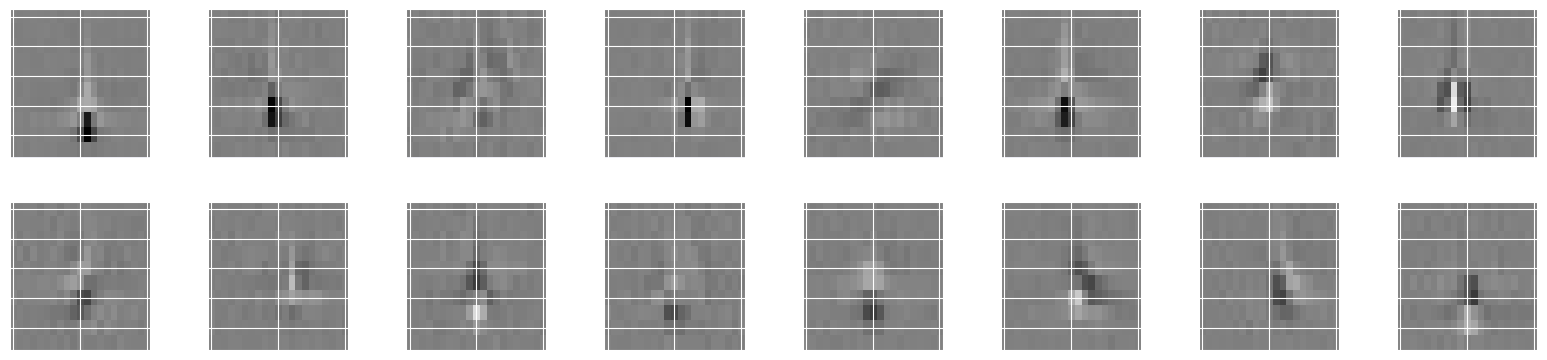

1e-06


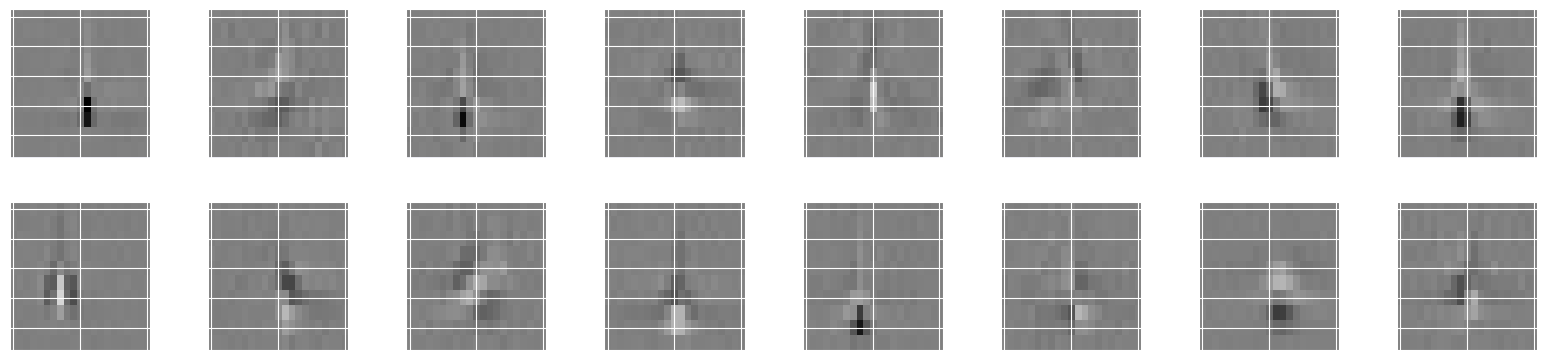

1e-07


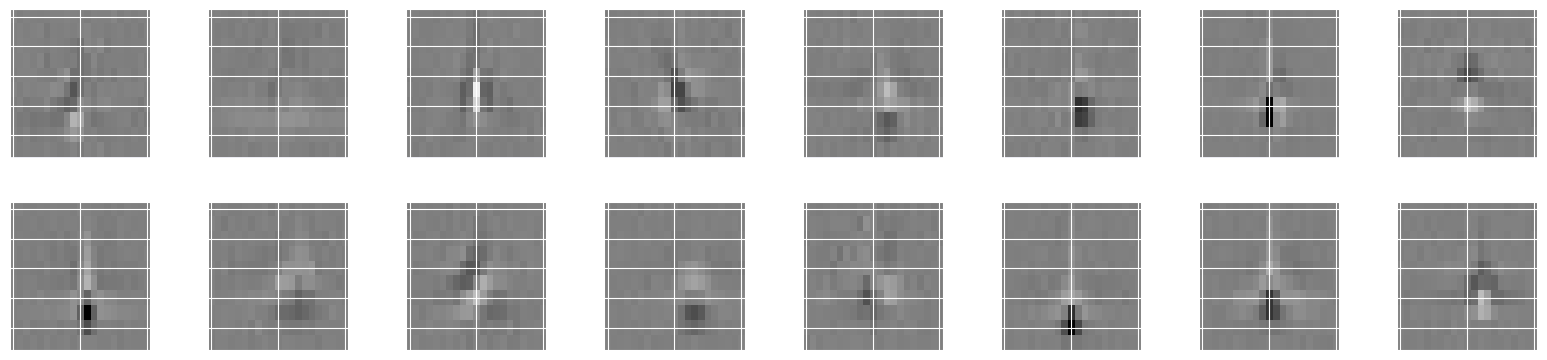

In [12]:
e = exp.load('reg_experiment_07', experiment_location='experiments', datadir='Mdata')
for activity in [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    print(activity)
    e.trials_where(activity=activity)[0].model.NDN.plot_filters()

In [4]:
model0 = e.trials_where(name='cnim_scaffold0')[0].model
model1 = e.trials_where(name='cnim_scaffold1')[0].model
model2 = e.trials_where(name='cnim_scaffold2')[0].model
model3 = e.trials_where(name='cnim_scaffold3')[0].model
model4 = e.trials_where(name='cnim_scaffold4')[0].model

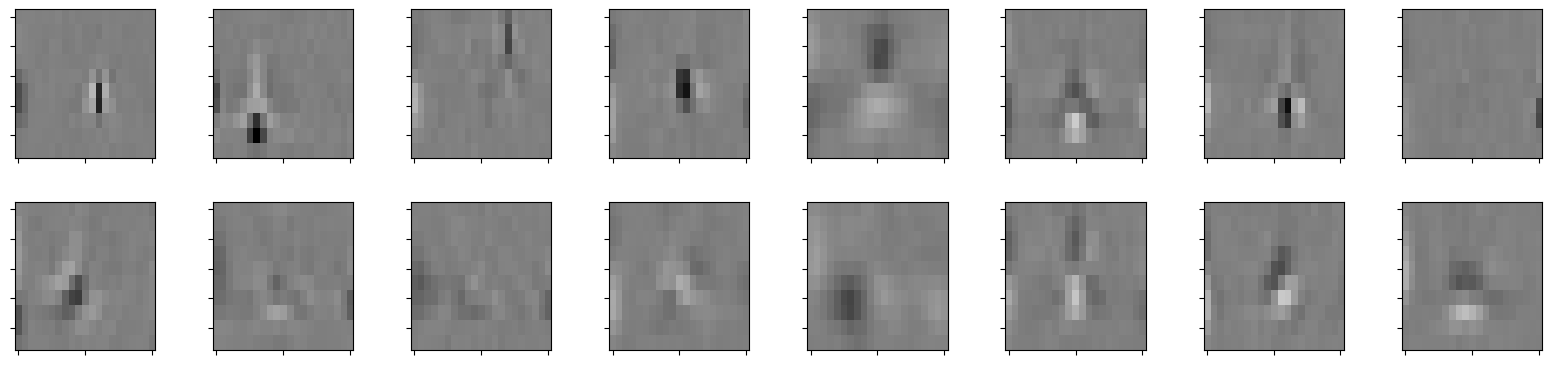

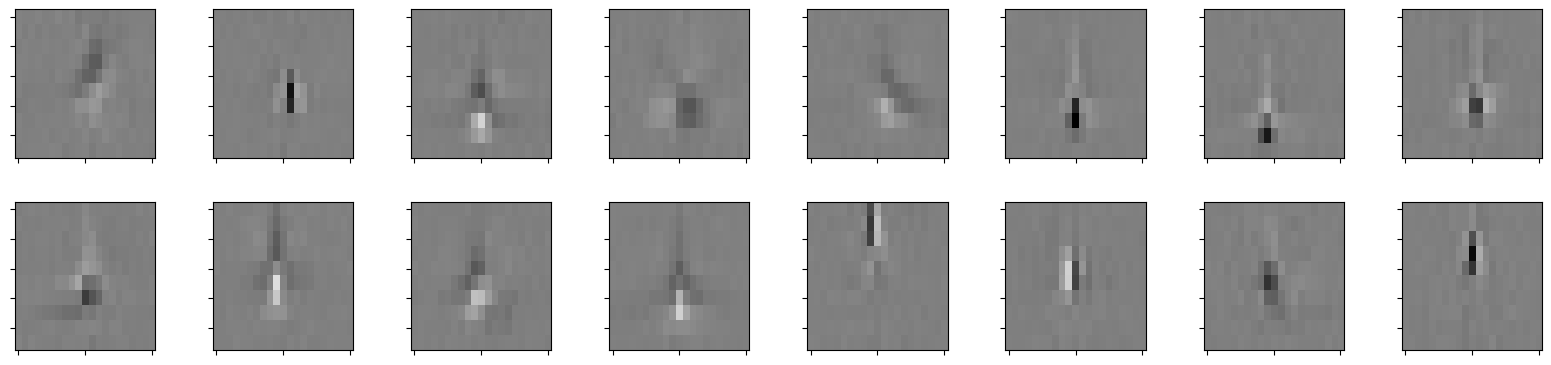

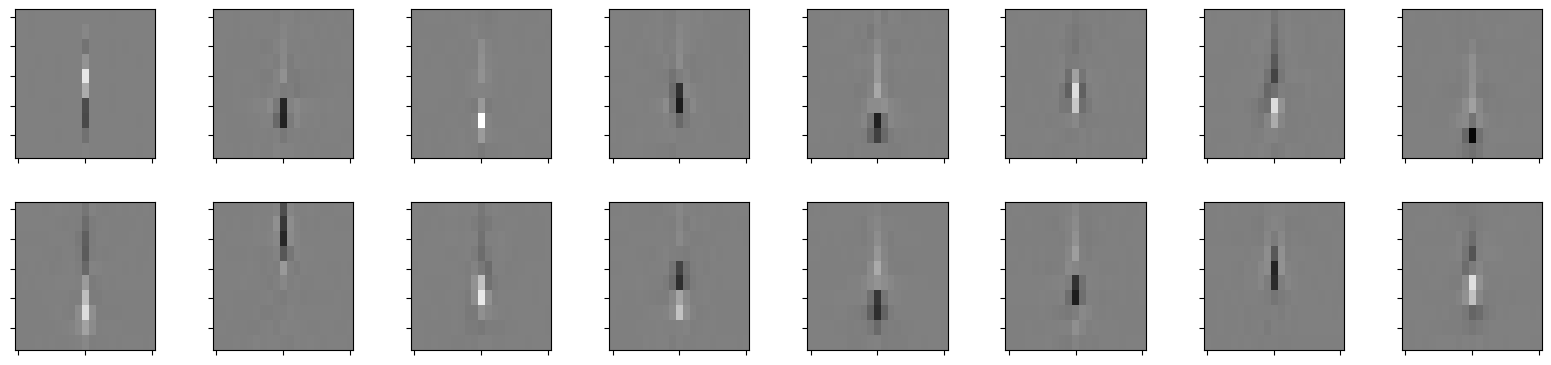

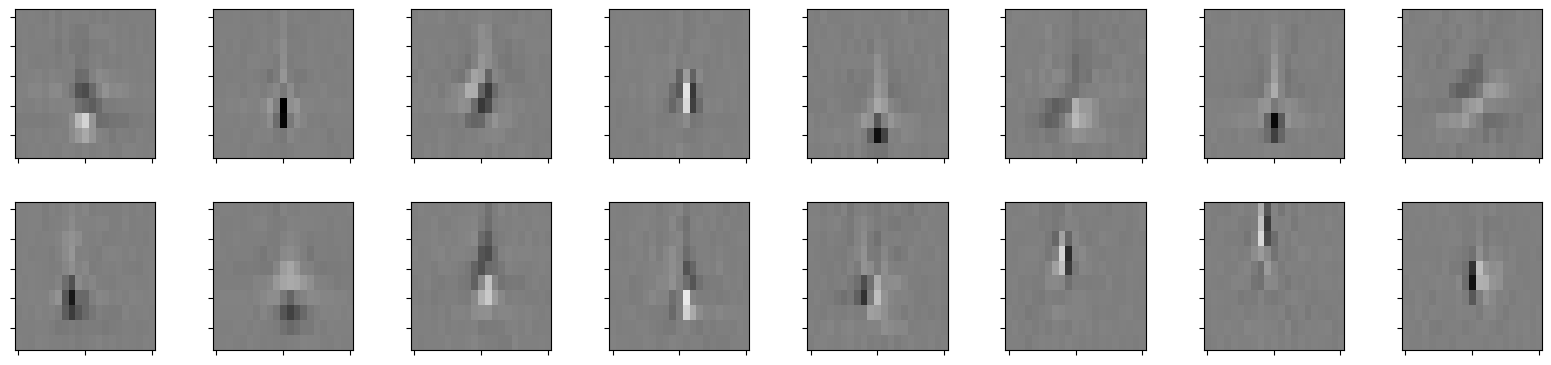

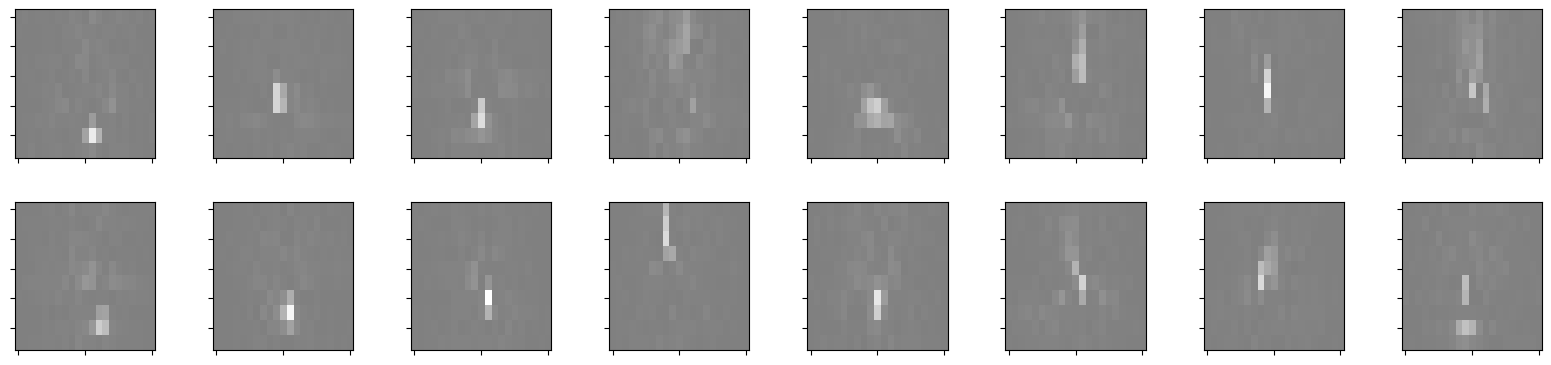

In [5]:
# plot the weights of the models in the different trials
model0.NDN.plot_filters()
model1.NDN.plot_filters()
model2.NDN.plot_filters()
model3.NDN.plot_filters()
model4.NDN.plot_filters()

# trying the new activity regularization

In [6]:
e = exp.load('reg_experiment_02', experiment_location='experiments', datadir='Mdata')
e.trials

null_adjusted_LL num_filters  num_inh_percent  \
0              True      16,8,8              0.5   
0              True      16,8,8              0.5   
0              True      16,8,8              0.5   

                                                expt kernel_widths  \
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr      l1  activity            name  \
0        6000  cnim_scaffold  0.0001       0.0  cnim_scaffold0   
0        6000  cnim_scaffold  0.0001       0.1  cnim_scaffold1   
0        6000  cnim_scaffold  0.0001       0.5  cnim_scaffold2   

                                         trial  mean_LLs  
0  <experiment.Trial object at 0x7f82dd4ed250>  0.197844  
0  <experiment.Trial object at 0x7f82dcec21f0> -0.000802  
0  <experiment.Trial object at 0x7f82dcfc7c70> -0.000564

lazy loading losses
lazy loading losses
lazy loading losses


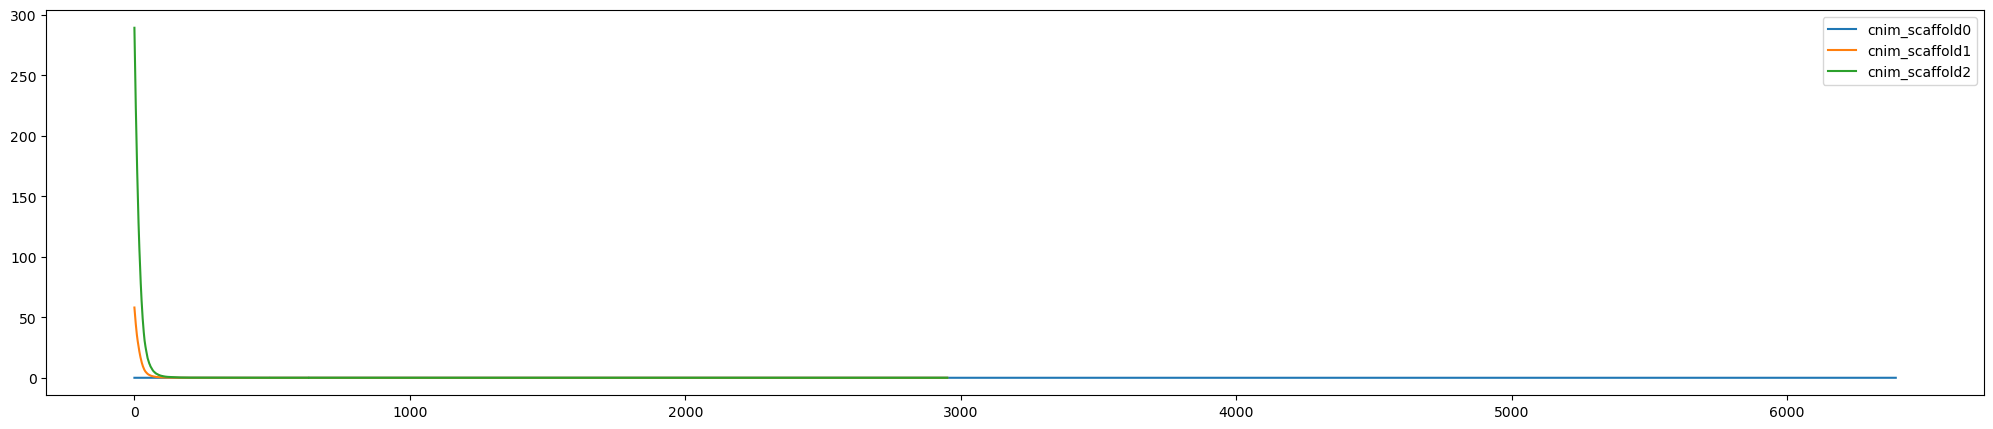

In [7]:
import experiment
e.plot_losses(trials=e.trials_where(null_adjusted_LL=True), loss_type=experiment.Loss.reg, figsize=(25,5))

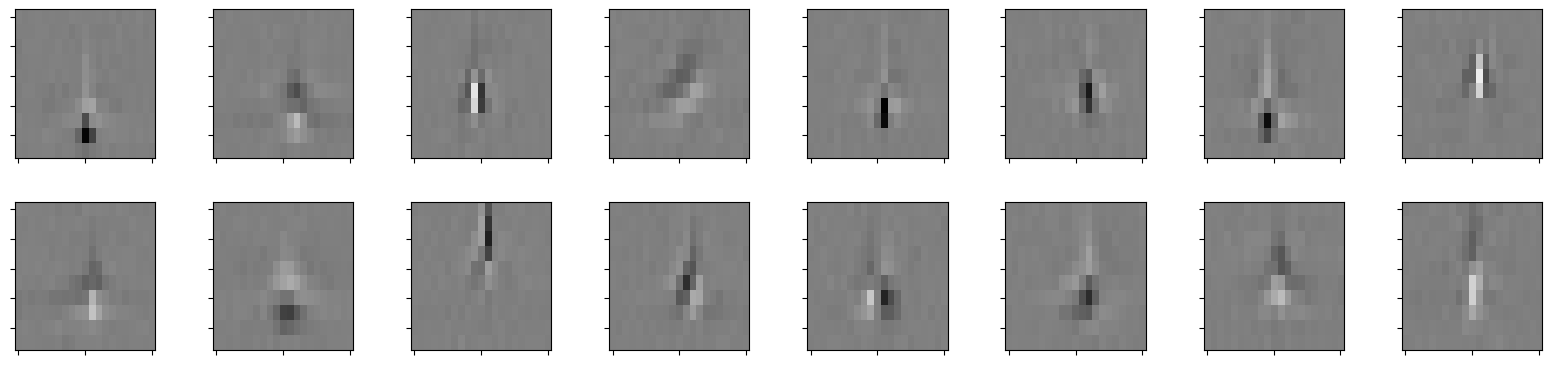

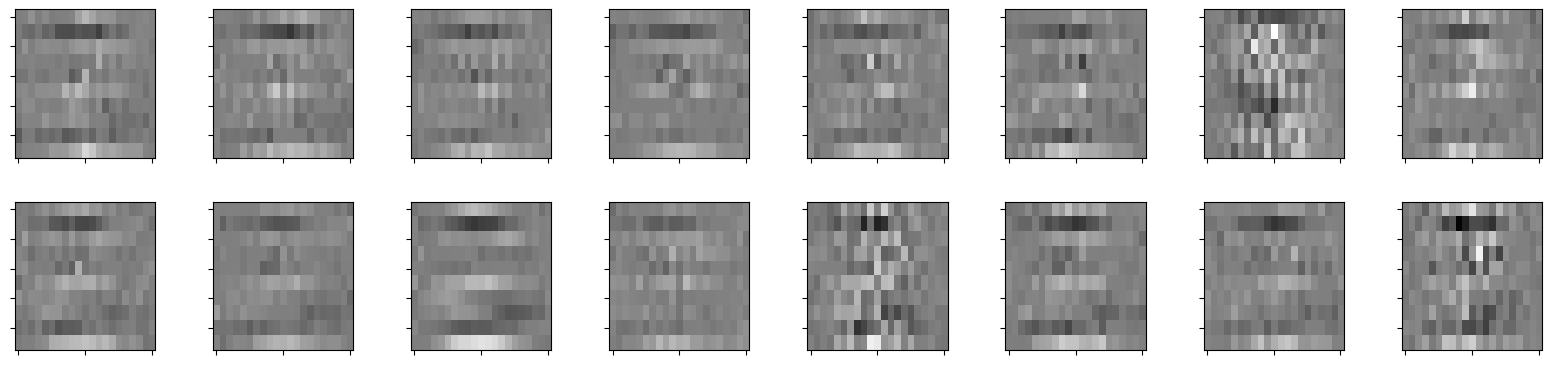

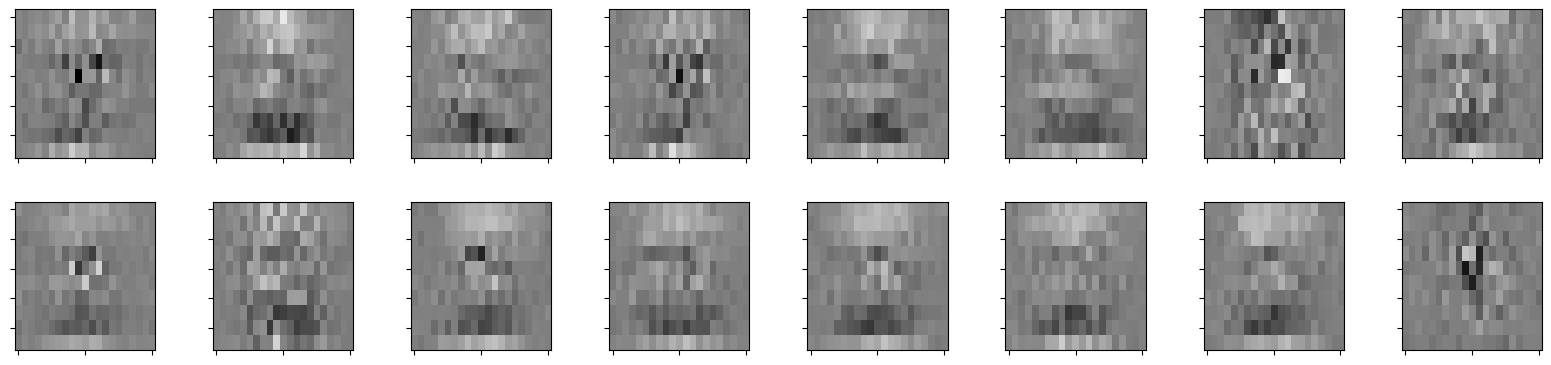

In [8]:
trial0 = e.trials_where(name='cnim_scaffold0')[0]
trial0.model.NDN.plot_filters()
trial1 = e.trials_where(name='cnim_scaffold1')[0]
trial1.model.NDN.plot_filters()
trial2 = e.trials_where(name='cnim_scaffold2')[0]
trial2.model.NDN.plot_filters()

In [9]:
import predict
results0 = predict.predict(trial0.model, dataset=trial0.dataset)
results1 = predict.predict(trial1.model, dataset=trial1.dataset)
results2 = predict.predict(trial2.model, dataset=trial2.dataset)

lazy loading dataset
Loading ['expt01', 'expt02', 'expt03', 'expt04', 'expt05', 'expt06', 'expt07', 'expt08', 'expt09', 'expt10', 'expt11', 'expt12']
Loading expt01
  Time embedding...
  Done.
Loading expt02
  Time embedding...
  Done.
Loading expt03
  Time embedding...
  Done.
Loading expt04
  Time embedding...
  Done.
Loading expt05
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.
Loading expt08
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt10
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.
Loading expt12
  Time embedding...
  Done.


TypeError: new(): invalid data type 'str'

# trying different orders of magnitude for the activity regularization

In [63]:
e4 = exp.load('reg_experiment_04', experiment_location='experiments', datadir='Mdata')
e4.trials

Error loading trial cnim_scaffold4 ...skipping
[Errno 2] No such file or directory: 'experiments/reg_experiment_04/cnim_scaffold4/model.pickle'


null_adjusted_LL num_filters  num_inh_percent  \
0              True      16,8,8              0.5   
0              True      16,8,8              0.5   
0              True      16,8,8              0.5   
0              True      16,8,8              0.5   

                                                expt kernel_widths  \
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   
0  expt01+expt02+expt03+expt04+expt05+expt06+expt...       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr  activity            name  \
0        6000  cnim_scaffold     1.000  cnim_scaffold0   
0        6000  cnim_scaffold     0.100  cnim_scaffold1   
0        6000  cnim_scaffold     0.010  cnim_scaffold2   
0        6000  cnim_scaffold     0.001  cnim_scaffold3   

                                         trial  mean_LLs  
0  <experiment.Trial object at 0x7f821fb3cf40>  0.019008  
0  <experiment.Trial object at 0x7f821f75b0a0>  0.097609  
0  <experiment.Trial object at 0x7f821faae0d0>  0.146895  
0  <experiment.Trial object at 0x7f821f2be8e0>  0.186821

activity regularization = 1.0


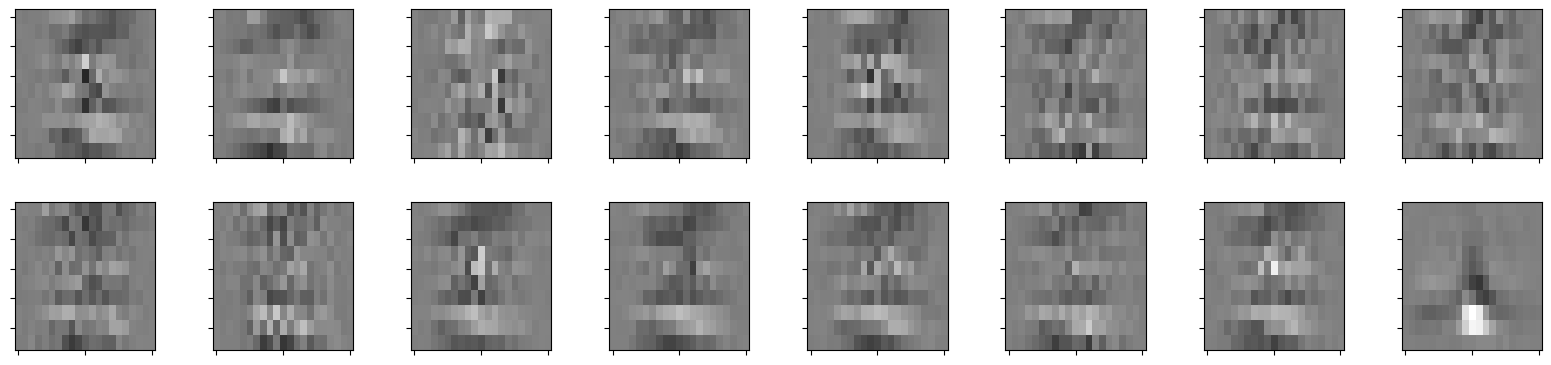

activity regularization = 0.1


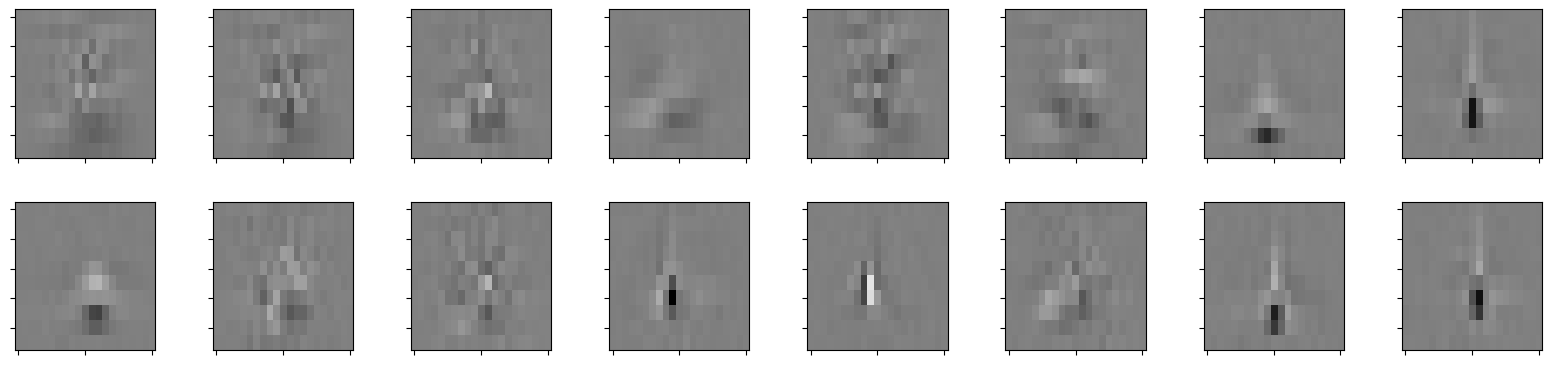

activity regularization = 0.01


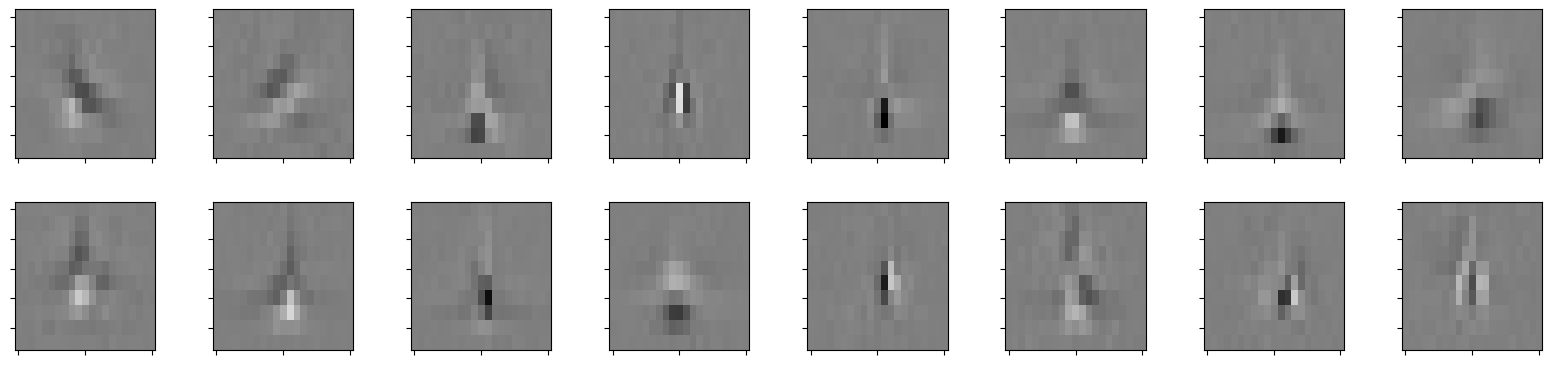

activity regularization = 0.001


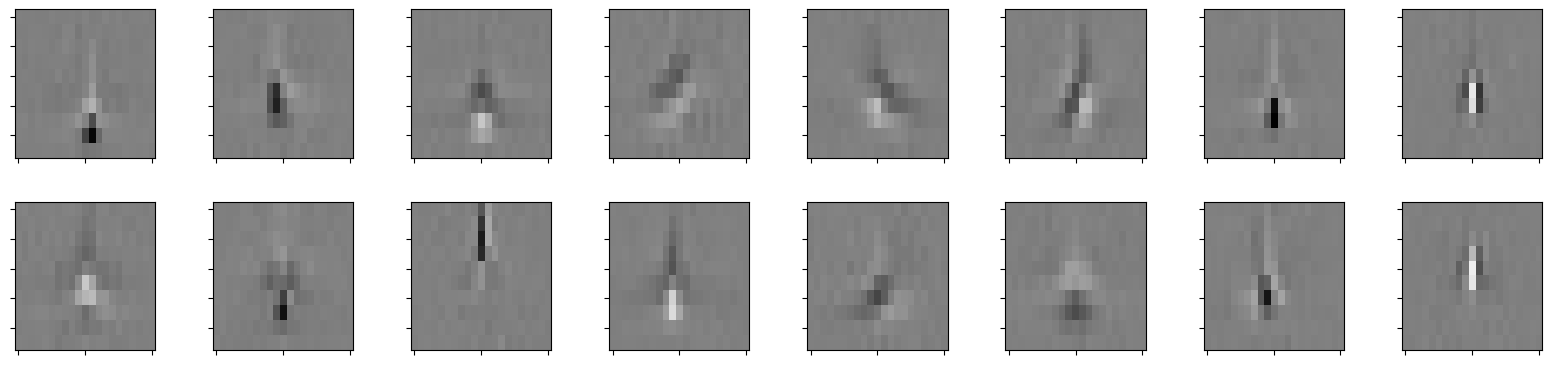

In [64]:
# plot the weights
trial0 = e4.trials_where(name='cnim_scaffold0')[0]
print('activity regularization = 1.0')
trial0.model.NDN.plot_filters()
trial1 = e4.trials_where(name='cnim_scaffold1')[0]
print('activity regularization = 0.1')
trial1.model.NDN.plot_filters()
trial2 = e4.trials_where(name='cnim_scaffold2')[0]
print('activity regularization = 0.01')
trial2.model.NDN.plot_filters()
trial3 = e4.trials_where(name='cnim_scaffold3')[0]
print('activity regularization = 0.001')
trial3.model.NDN.plot_filters()

# plot the Jacobians for a particular stimulus

In [99]:
max_frame = 100
results0 = predict.predict(trial0.model, dataset=trial0.dataset[0:max_frame], network_names_to_use=['core'])
results1 = predict.predict(trial1.model, dataset=trial1.dataset[0:max_frame], network_names_to_use=['core'])

prev_output shape torch.Size([100, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([100, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([100, 288]) ni 0 NetworkType.scaffold li 2
prev_output shape torch.Size([100, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([100, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([100, 288]) ni 0 NetworkType.scaffold li 2


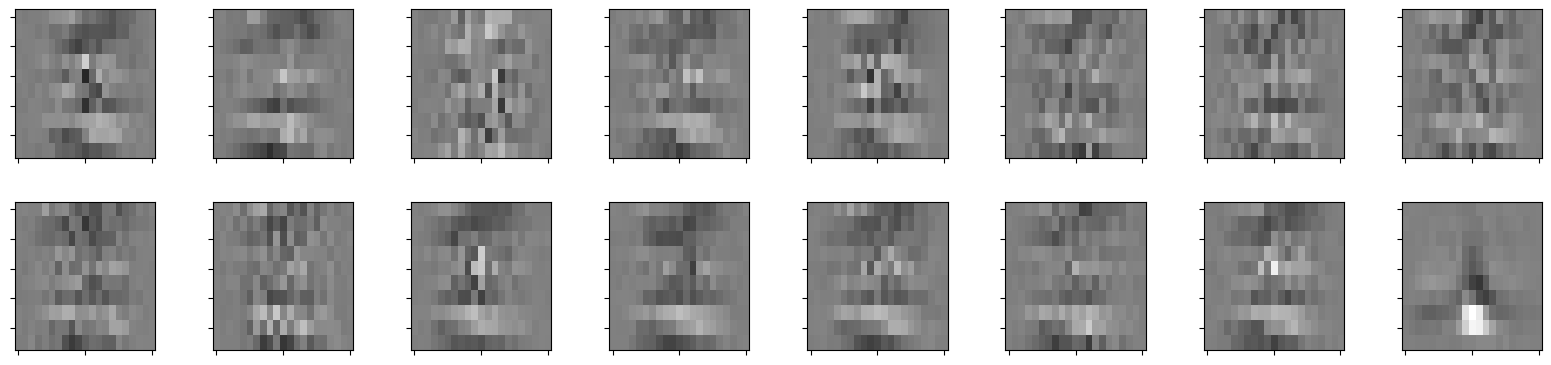

In [100]:
trial0.model.NDN.plot_filters()

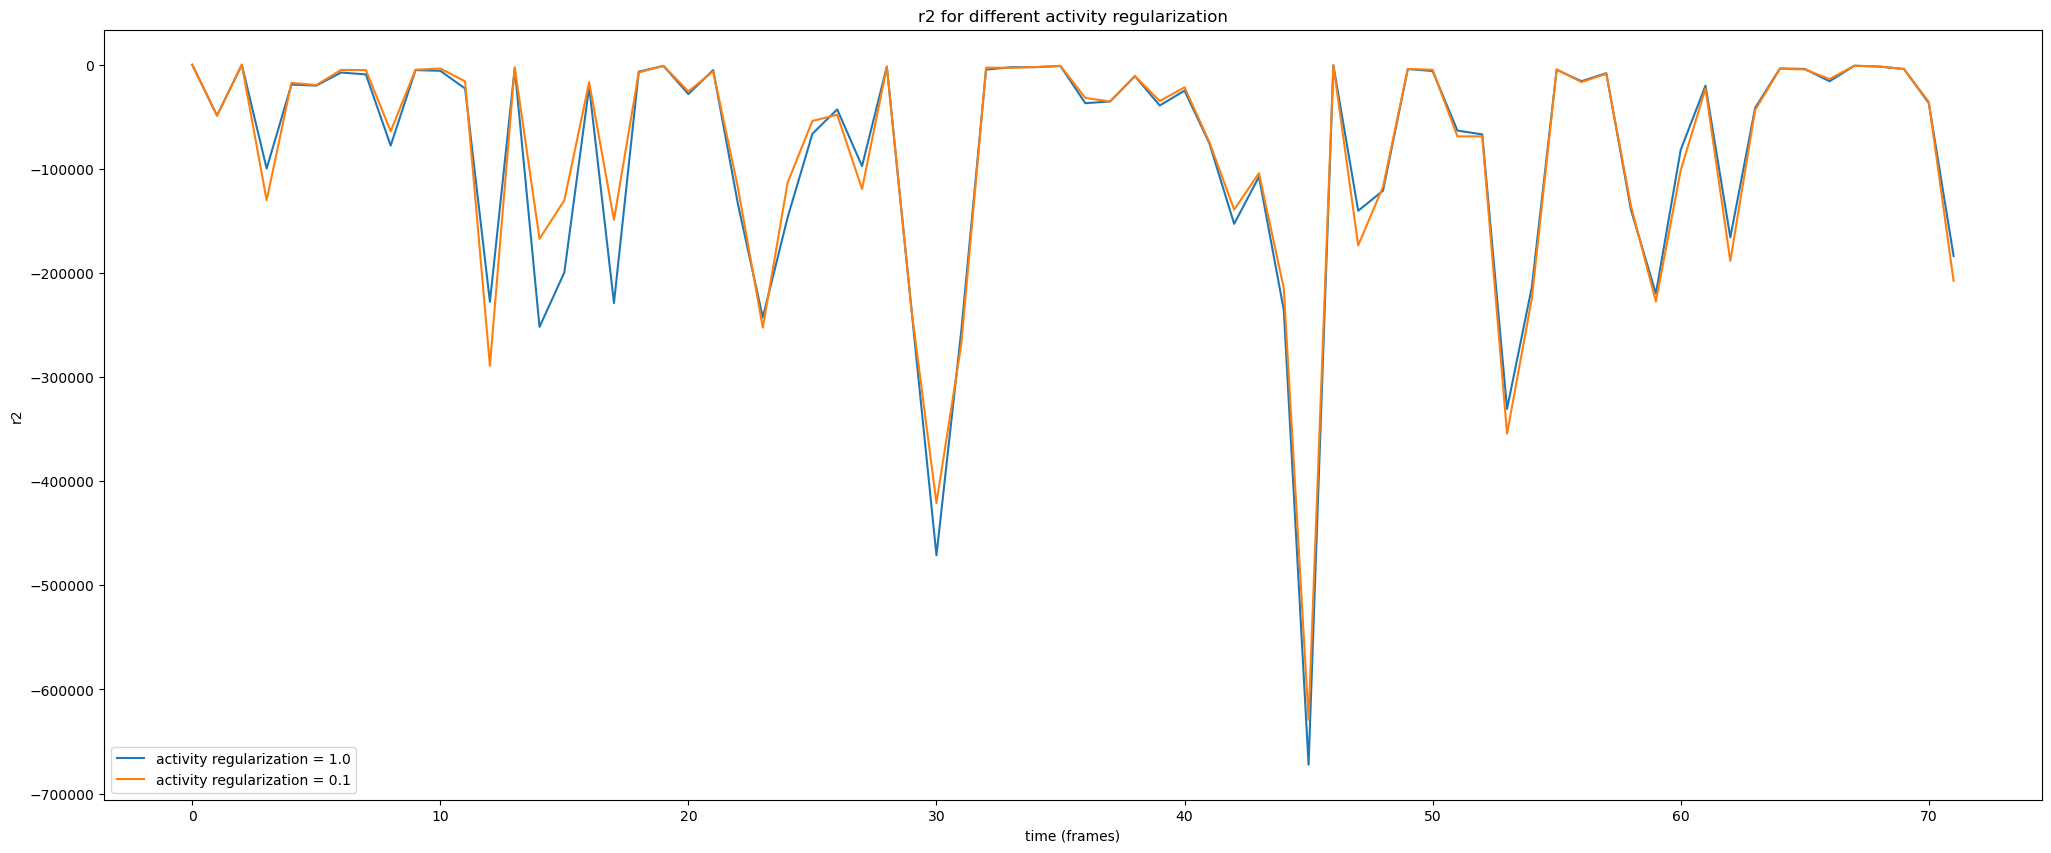

In [105]:
# plot r2 for the results
fig = plt.figure(figsize=(25,10))
plt.plot(results0.r2, label='activity regularization = 1.0')
plt.plot(results1.r2, label='activity regularization = 0.1')
plt.legend()
plt.xlabel('time (frames)')
plt.ylabel('r2')
plt.title('r2 for different activity regularization')
plt.show()

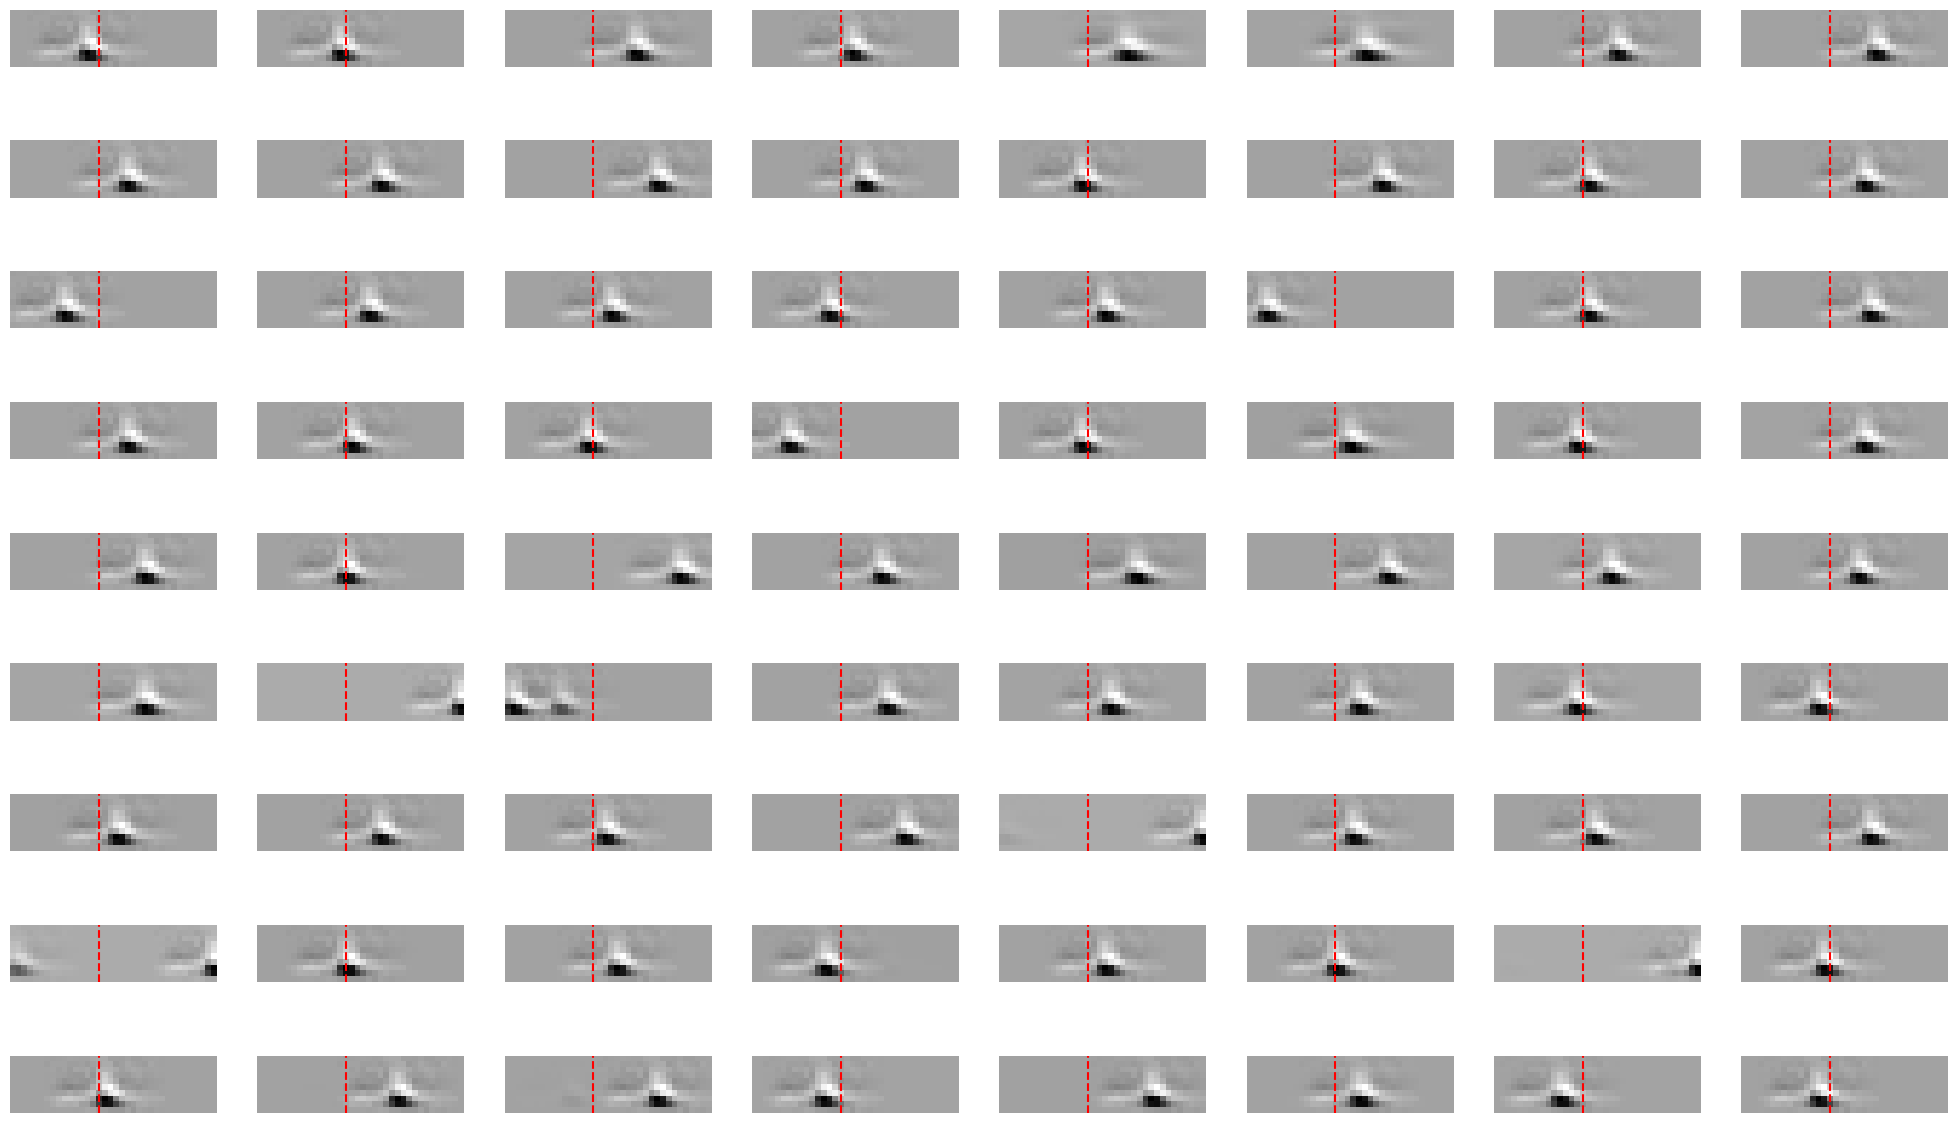

In [107]:
# plot the Jacobians for a particular stimulus
#imax = np.max(np.abs(results0.jacobian[0,1,:]))
#imin = -imax
# plot stimulus and Jacobian side by side for each timepoint using a Grid
fig = plt.figure(figsize=(25,15))
grid = plt.GridSpec(9, 8)
for i in range(trial0.dataset.NC):
    row, col = np.unravel_index(i, (9, 8))
    ax1 = fig.add_subplot(grid[row,col])
    ax1.axis('off')
    rf = np.mean([results0.jacobian[f][0, i, :].detach().cpu().numpy() for f in range(max_frame)], axis=0)
    ax1.imshow(rf.reshape(36,10).T, cmap='gray', origin='lower') # set origin to lower to flip image vertically
    ax1.axvline(x=15, color='r', linestyle='--')

(21, 10, 16) --> (16, 10, 21)
(16, 11, 8) --> (8, 11, 16)
(8, 5, 8) --> (8, 5, 8)
(32, 36, 72) --> (72, 36, 32)


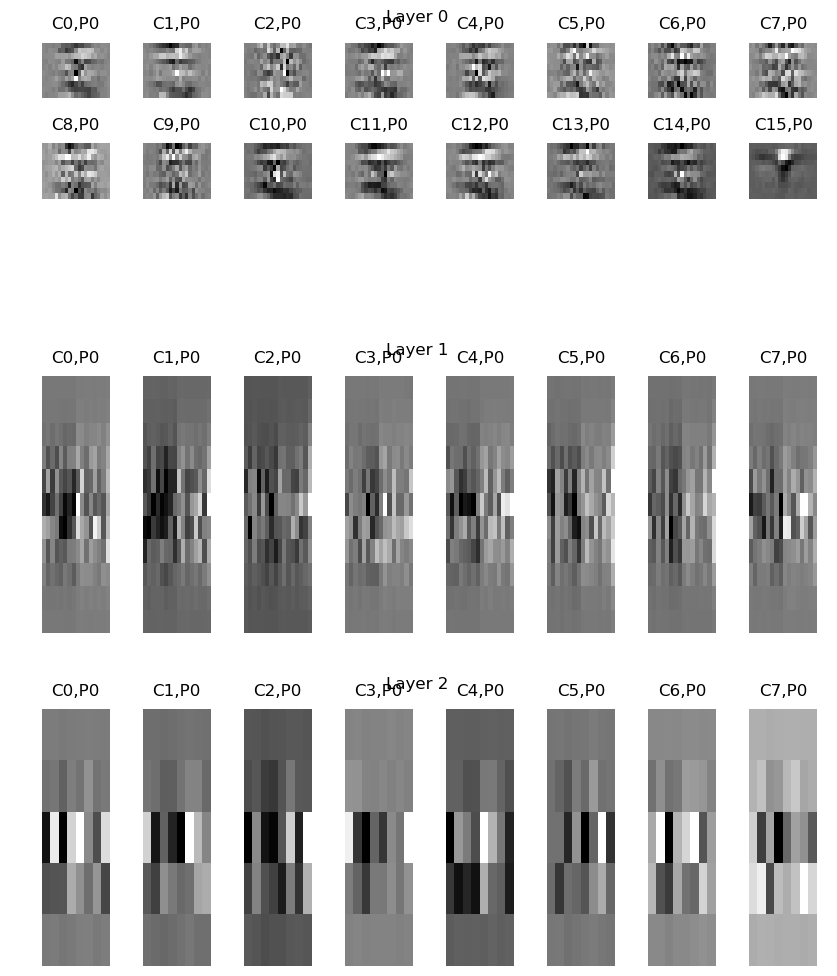

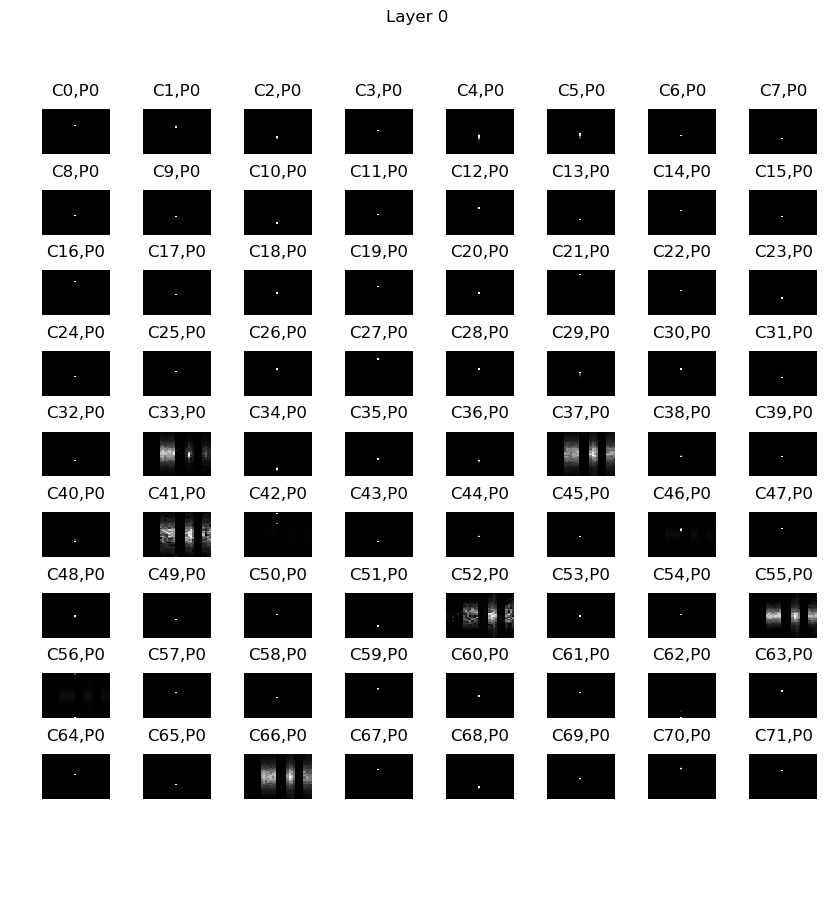

In [122]:
import plot
plot.plot_model_weights(trial0.model)

(21, 10, 16) --> (16, 10, 21)
(16, 11, 8) --> (8, 11, 16)
(8, 5, 8) --> (8, 5, 8)
(32, 36, 72) --> (72, 36, 32)


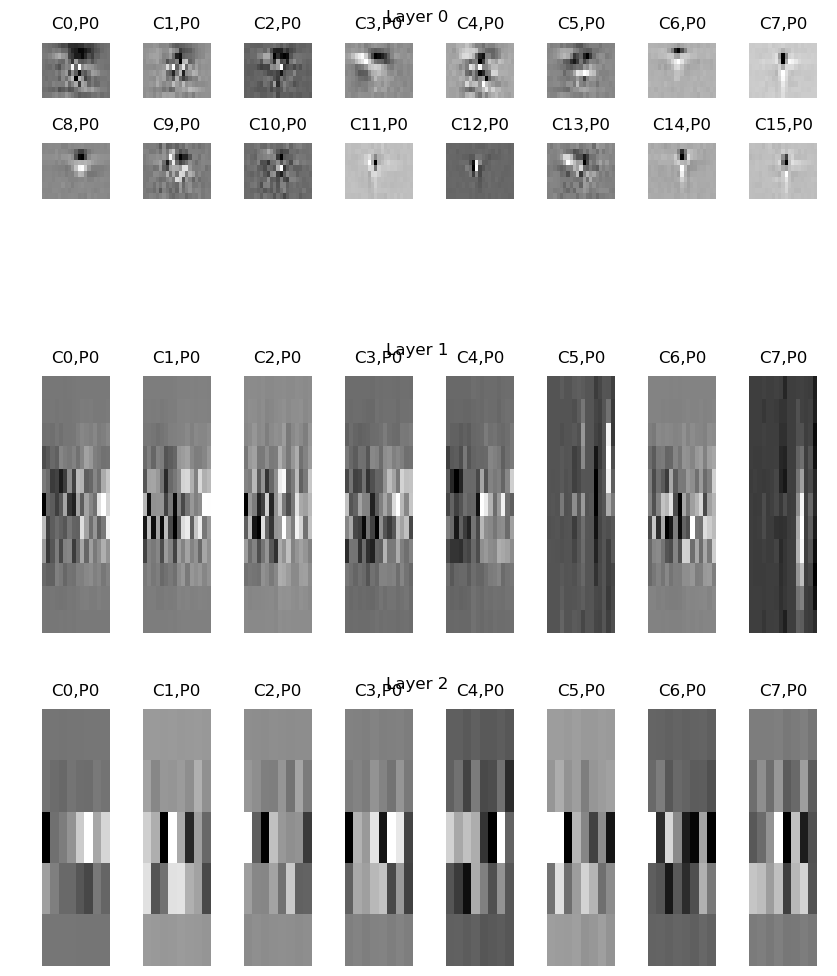

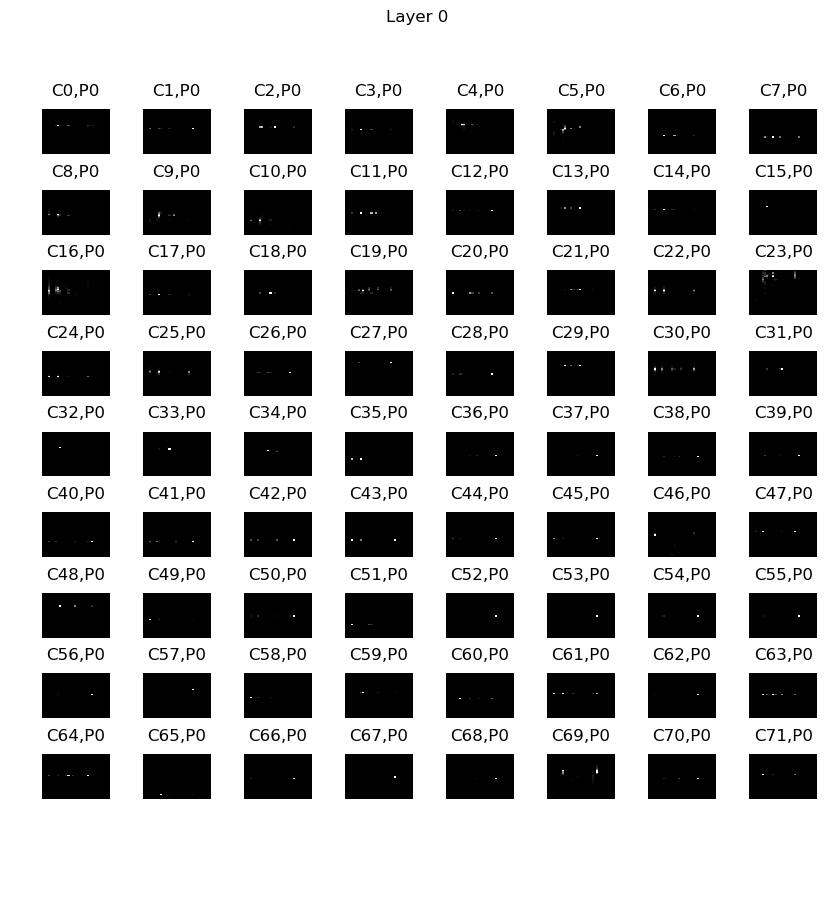

In [123]:
plot.plot_model_weights(trial1.model)

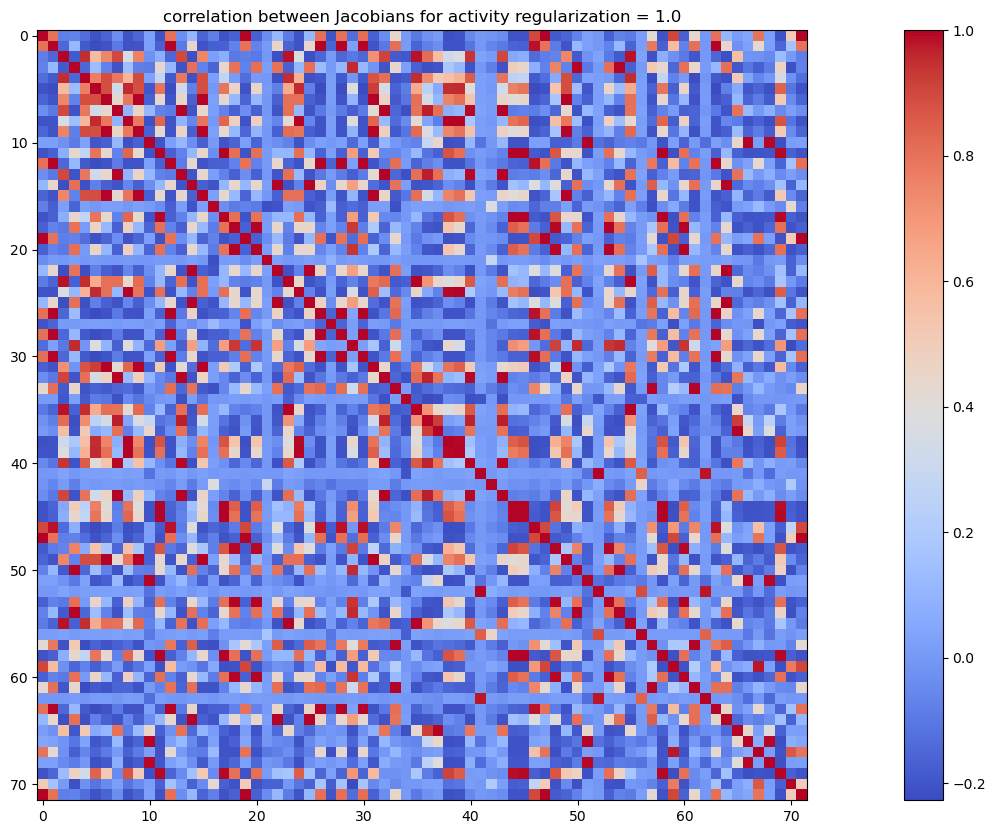

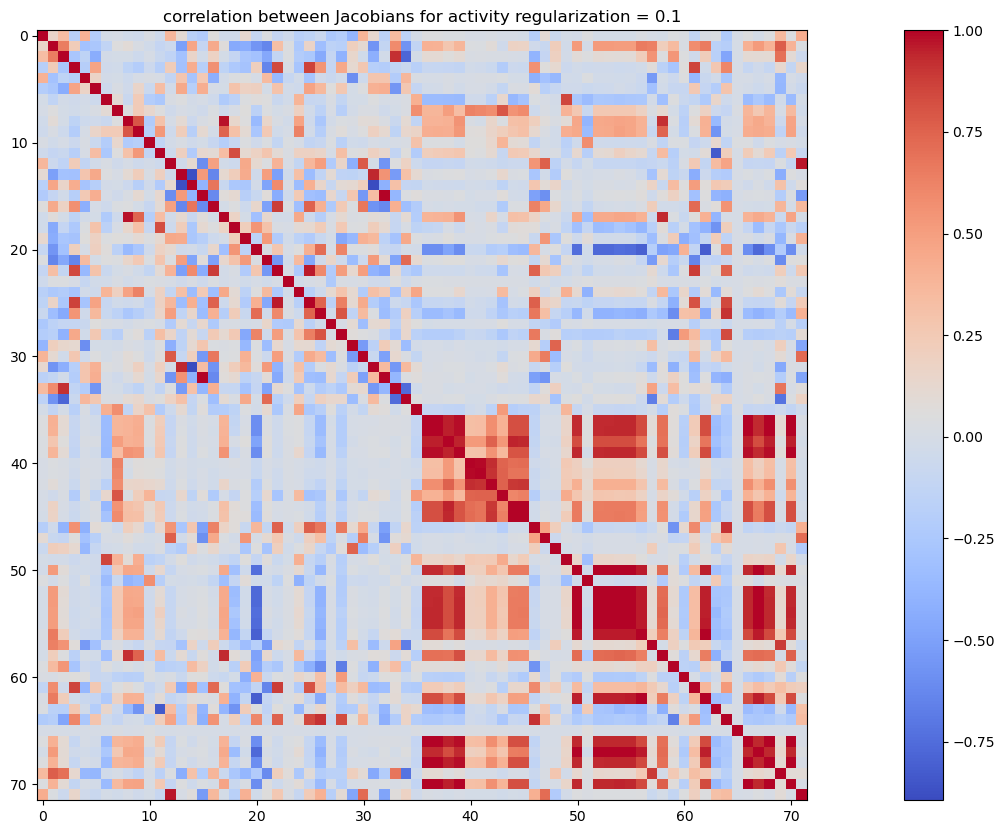

In [114]:
# plot correlation between Jacobians for different activity regularization values
fig = plt.figure(figsize=(25,10))
activation_correlation0 = np.corrcoef(results0.jacobian[0][0, :, :].detach().cpu().numpy(), rowvar=True)
plt.imshow(activation_correlation0, cmap='coolwarm')
plt.colorbar()
plt.title('correlation between Jacobians for activity regularization = 1.0')
plt.show()

# plot correlation between Jacobians for different activity regularization values
fig = plt.figure(figsize=(25,10))
activation_correlation1 = np.corrcoef(results1.jacobian[0][0, :, :].detach().cpu().numpy(), rowvar=True)
plt.imshow(activation_correlation1, cmap='coolwarm')
plt.colorbar()
plt.title('correlation between Jacobians for activity regularization = 0.1')
plt.show()

(21, 10, 16) --> (16, 10, 21)
(16, 11, 8) --> (8, 11, 16)
(8, 5, 8) --> (8, 5, 8)
(32, 36, 72) --> (72, 36, 32)


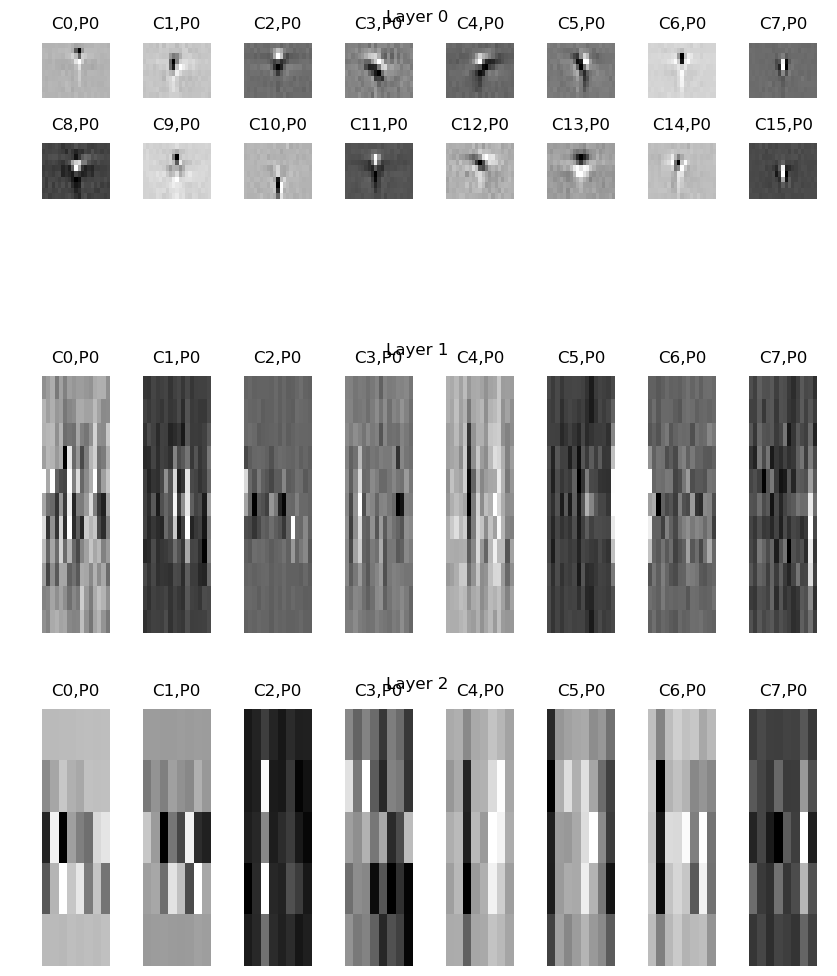

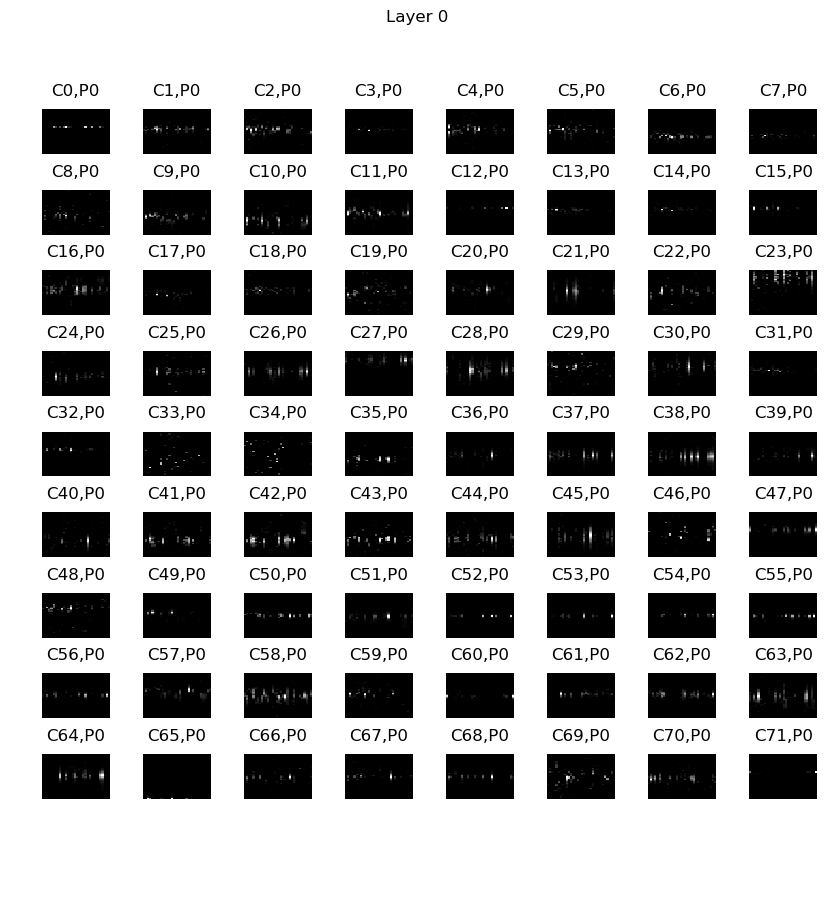

In [129]:
# get the weights going to each neuron
plot.plot_model_weights(trial3.model)

# get the weights for a single neuron

In [163]:
trial3.model.networks_by_name['readout'].layers[0].weights.shape

(32, 36, 72)

(72, 1152) 0.0 56.2555
(72, 1152) 0.0 31.882818
(72, 1152) 0.0 10.023052
(72, 1152) 0.0 4.328096


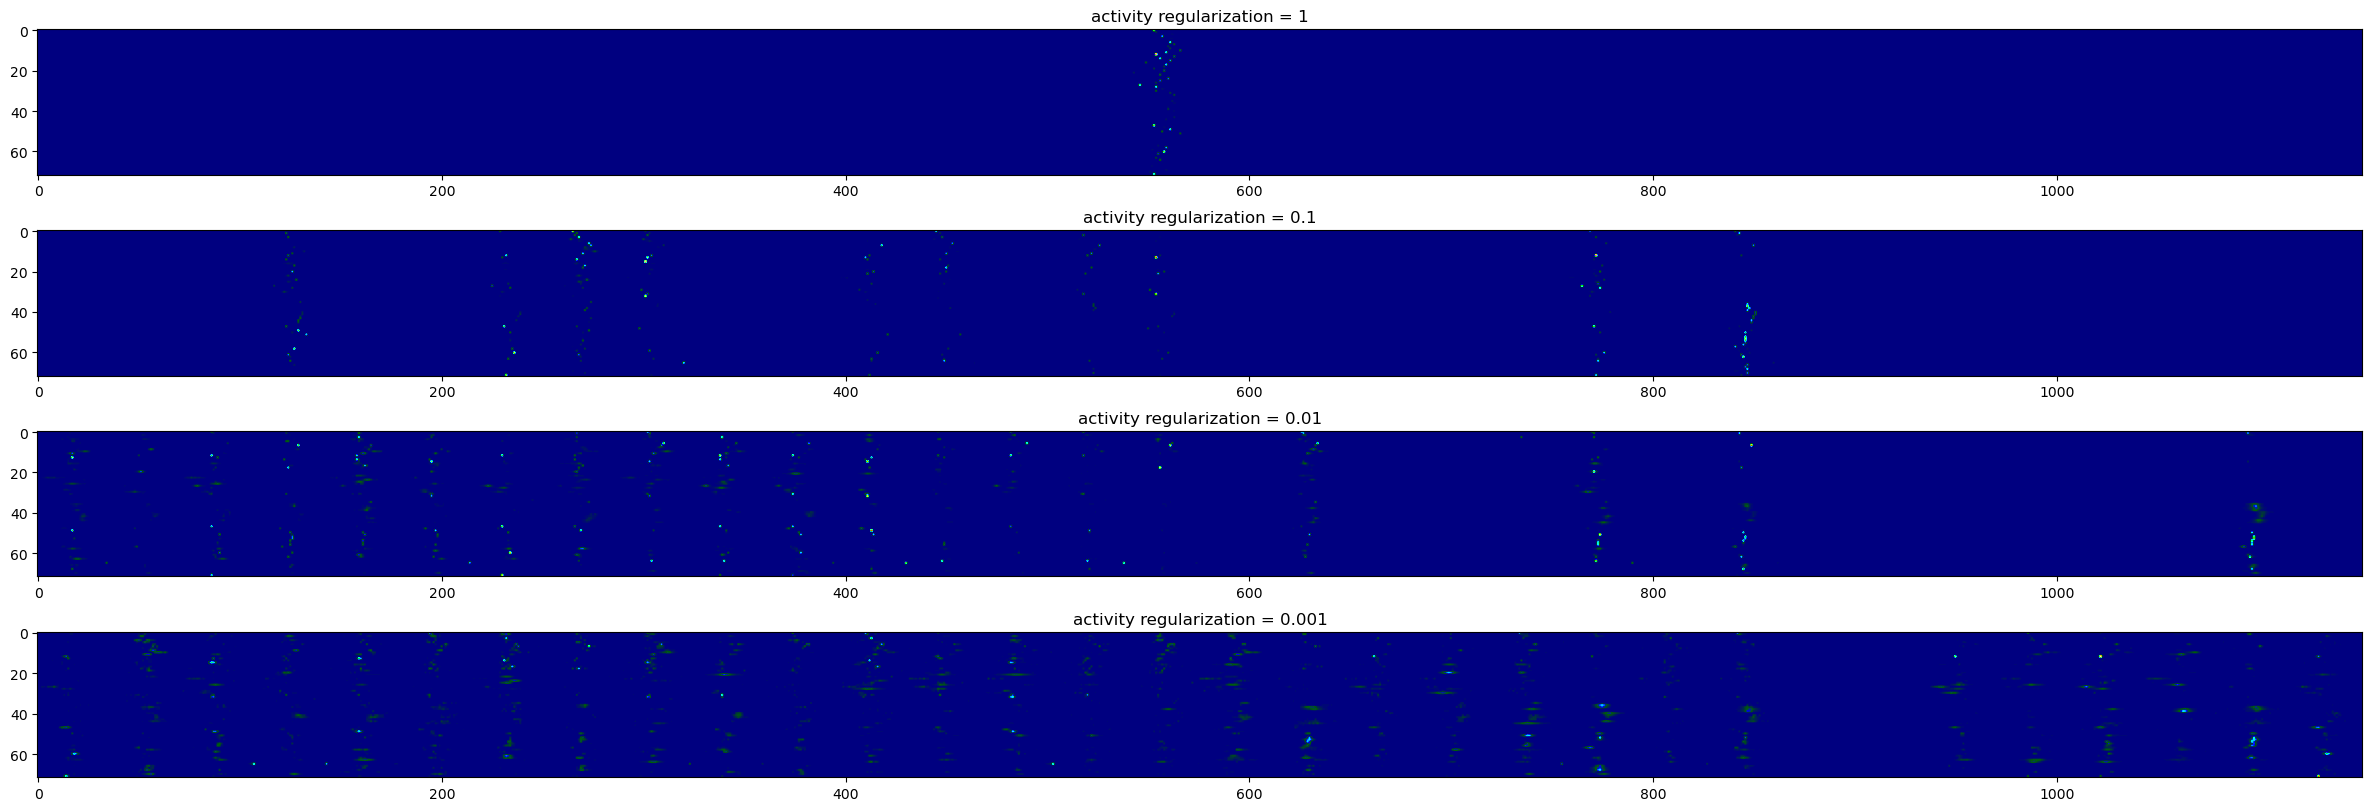

In [164]:
# (concatenate the weights from all the layers)
# plot the weights for each trial
fig = plt.figure(figsize=(30,10))
for i in range(4):
    trial = e4.trials_where(name='cnim_scaffold'+str(i))[0]
    ax = fig.add_subplot(4,1,i+1)
    im = trial.model.networks_by_name['readout'].layers[0].weights.reshape(1152,72).T
    imin = np.min(im)
    imax = np.max(im)
    print(im.shape, imin, imax)
    ax.imshow(im, cmap='gist_ncar', vmin=imin, vmax=imax)
    ax.set_title('activity regularization = '+str(10**(-i)))

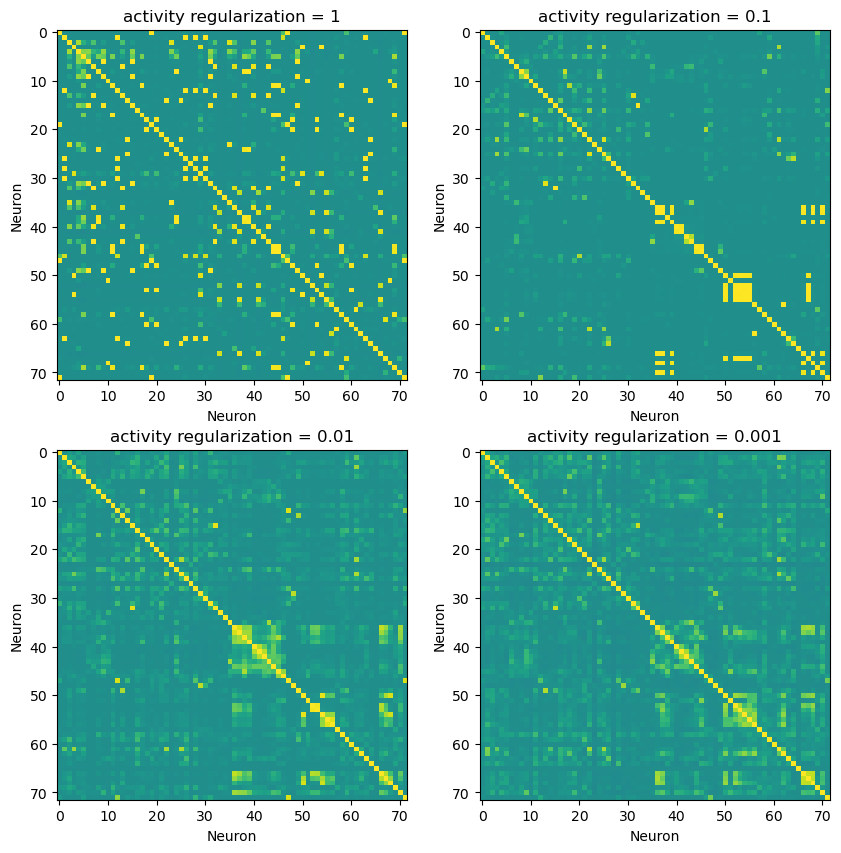

In [182]:
# calculate the correlation between neurons for each trial
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a list of matrices called 'matrices_list'
matrices_list = [np.random.rand(72, 1152) for _ in range(5)]

# Function to compute the correlation matrix
def get_correlation_matrix(matrix):
    return np.corrcoef(np.transpose(matrix))

# Iterate through the list of matrices, compute the correlation matrices, and plot them as images
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(2,2)
for i in range(4):
    row, col = np.unravel_index(i, (2,2))
    ax = fig.add_subplot(grid[row,col])
    trial = e4.trials_where(name='cnim_scaffold'+str(i))[0]
    matrix = trial.model.networks_by_name['readout'].layers[0].weights.reshape(1152,72)
    correlation_matrix = get_correlation_matrix(matrix)
    ax.imshow(correlation_matrix, cmap='viridis', vmin=-1, vmax=1)
    plt.title(f'activity regularization = '+str(10**(-i)))
    plt.xlabel('Neuron')
    plt.ylabel('Neuron')
plt.show()

# use UMAP

In [243]:
# use UMAP to visualize the weights
import umap
weights = trial3.model.networks_by_name['readout'].layers[0].weights.reshape(1152,72).T
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(weights)
print(embedding.shape)

# plot the embedding
import plotly.express as px
fig = px.scatter_3d(embedding, x=0, y=1, z=2, width=800, height=800, template='simple_white')
fig.show()

(72, 3)


# do some graph stuff

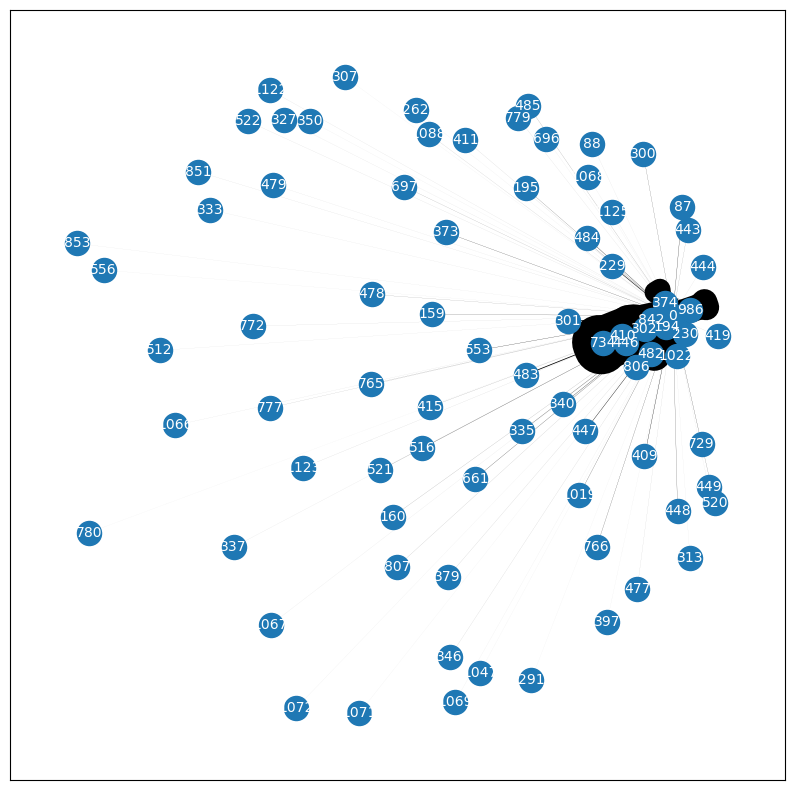

In [239]:
# get the graph for a single neuron, sparsify it, and plot it
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# get the weights for a single neuron, walk backwards from the neuron
weights = trial3.model.networks_by_name['readout'].layers[0].weights.reshape(1152,72).T
neuron = 0
graph = nx.DiGraph()
graph.add_node(neuron)
filtered_weights = []
for i in range(1152):
    if weights[neuron, i] > 0.001:
        graph.add_node(i)
        graph.add_edge(i, neuron, weight=weights[neuron, i])
        filtered_weights.append(weights[neuron, i])
filtered_weights = np.array(filtered_weights)


# plot the graph with edge weights
plt.figure(figsize=(10,10))
nx.draw_networkx(graph, with_labels=True, width=filtered_weights*10, font_color='white', font_size=10)
plt.show()

# comparing results for different activity regularization values

In [299]:
e5 = exp.load('reg_experiment_05', experiment_location='experiments', datadir='Mdata')
e5.trials

null_adjusted_LL num_filters  num_inh_percent    expt kernel_widths  \
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   
0              True      16,8,8              0.5  expt04       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr  activity            name  \
0        6000  cnim_scaffold  0.010000  cnim_scaffold0   
0        6000  cnim_scaffold  0.001000  cnim_scaffold1   
0        6000  cnim_scaffold  0.000100  cnim_scaffold2   
0        6000  cnim_scaffold  0.000010  cnim_scaffold3   
0        6000  cnim_scaffold  0.000001  cnim_scaffold4   
0        6000  cnim_scaffold       NaN  cnim_scaffold5   
0        6000  cnim_scaffold       NaN  cnim_scaffold6   
0        6000  cnim_scaffold       NaN  cnim_scaffold7   
0        6000  cnim_scaffold       NaN  cnim_scaffold8   
0        6000  cnim_scaffold       NaN  cnim_scaffold9   

                                         trial  mean_LLs        l1  
0  <experiment.Trial object at 0x7f8189c29ca0>  0.493319       NaN  
0  <experiment.Trial object at 0x7f812cb125b0>  0.497692       NaN  
0  <experiment.Trial object at 0x7f8189cdb9a0>  0.500840       NaN  
0  <experiment.Trial object at 0x7f812d8d4eb0>  0.493444       NaN  
0  <experiment.Trial object at 0x7f817259e1c0>  0.501327       NaN  
0  <experiment.Trial object at 0x7f812d959400>  0.484976  0.010000  
0  <experiment.Trial object at 0x7f817306bf40>  0.499338  0.001000  
0  <experiment.Trial object at 0x7f817c36acd0>  0.496546  0.000100  
0  <experiment.Trial object at 0x7f8173099850>  0.494635  0.000010  
0  <experiment.Trial object at 0x7f818a04ef10>  0.499648  0.000001

lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses


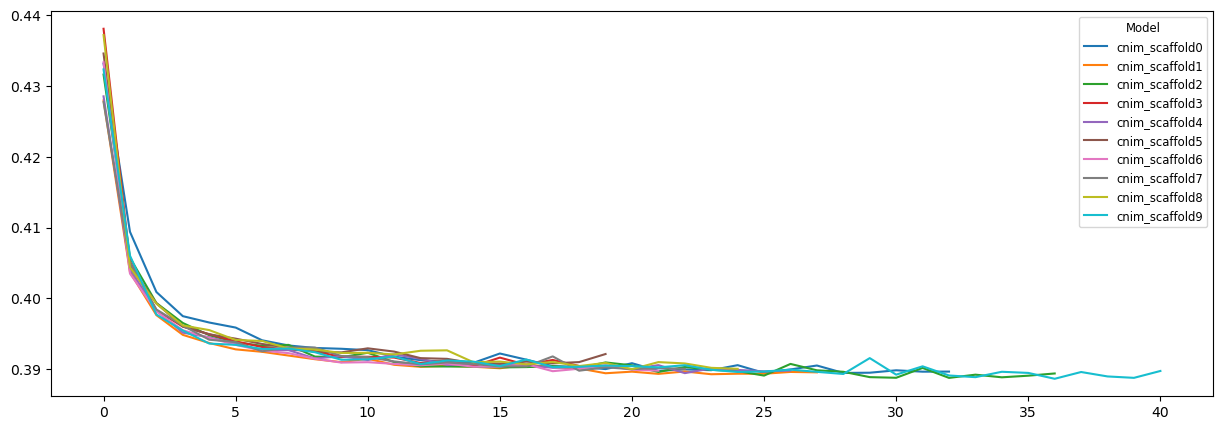

In [300]:
e5.plot_losses()

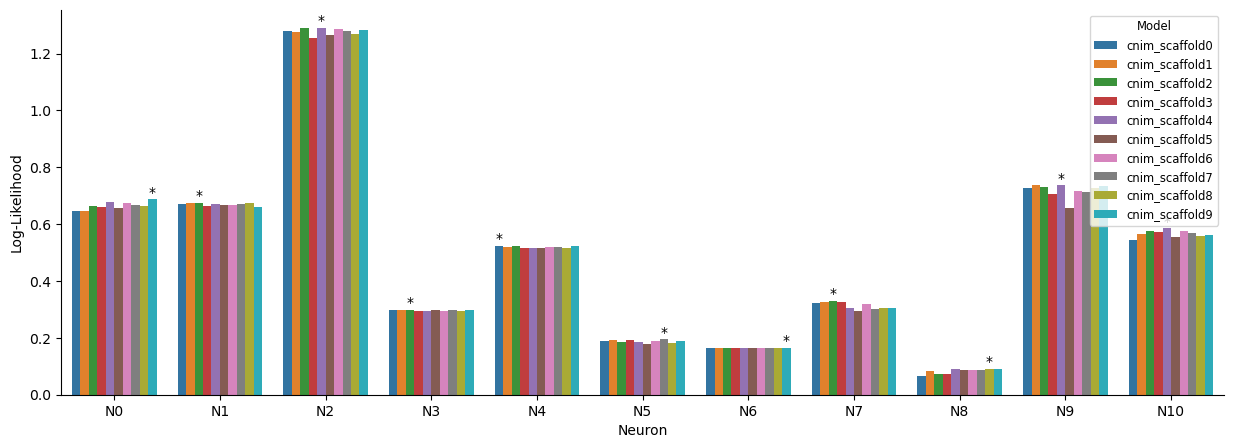

In [301]:
e5.plot_LLs()

In [303]:
len(e5.trials)

10

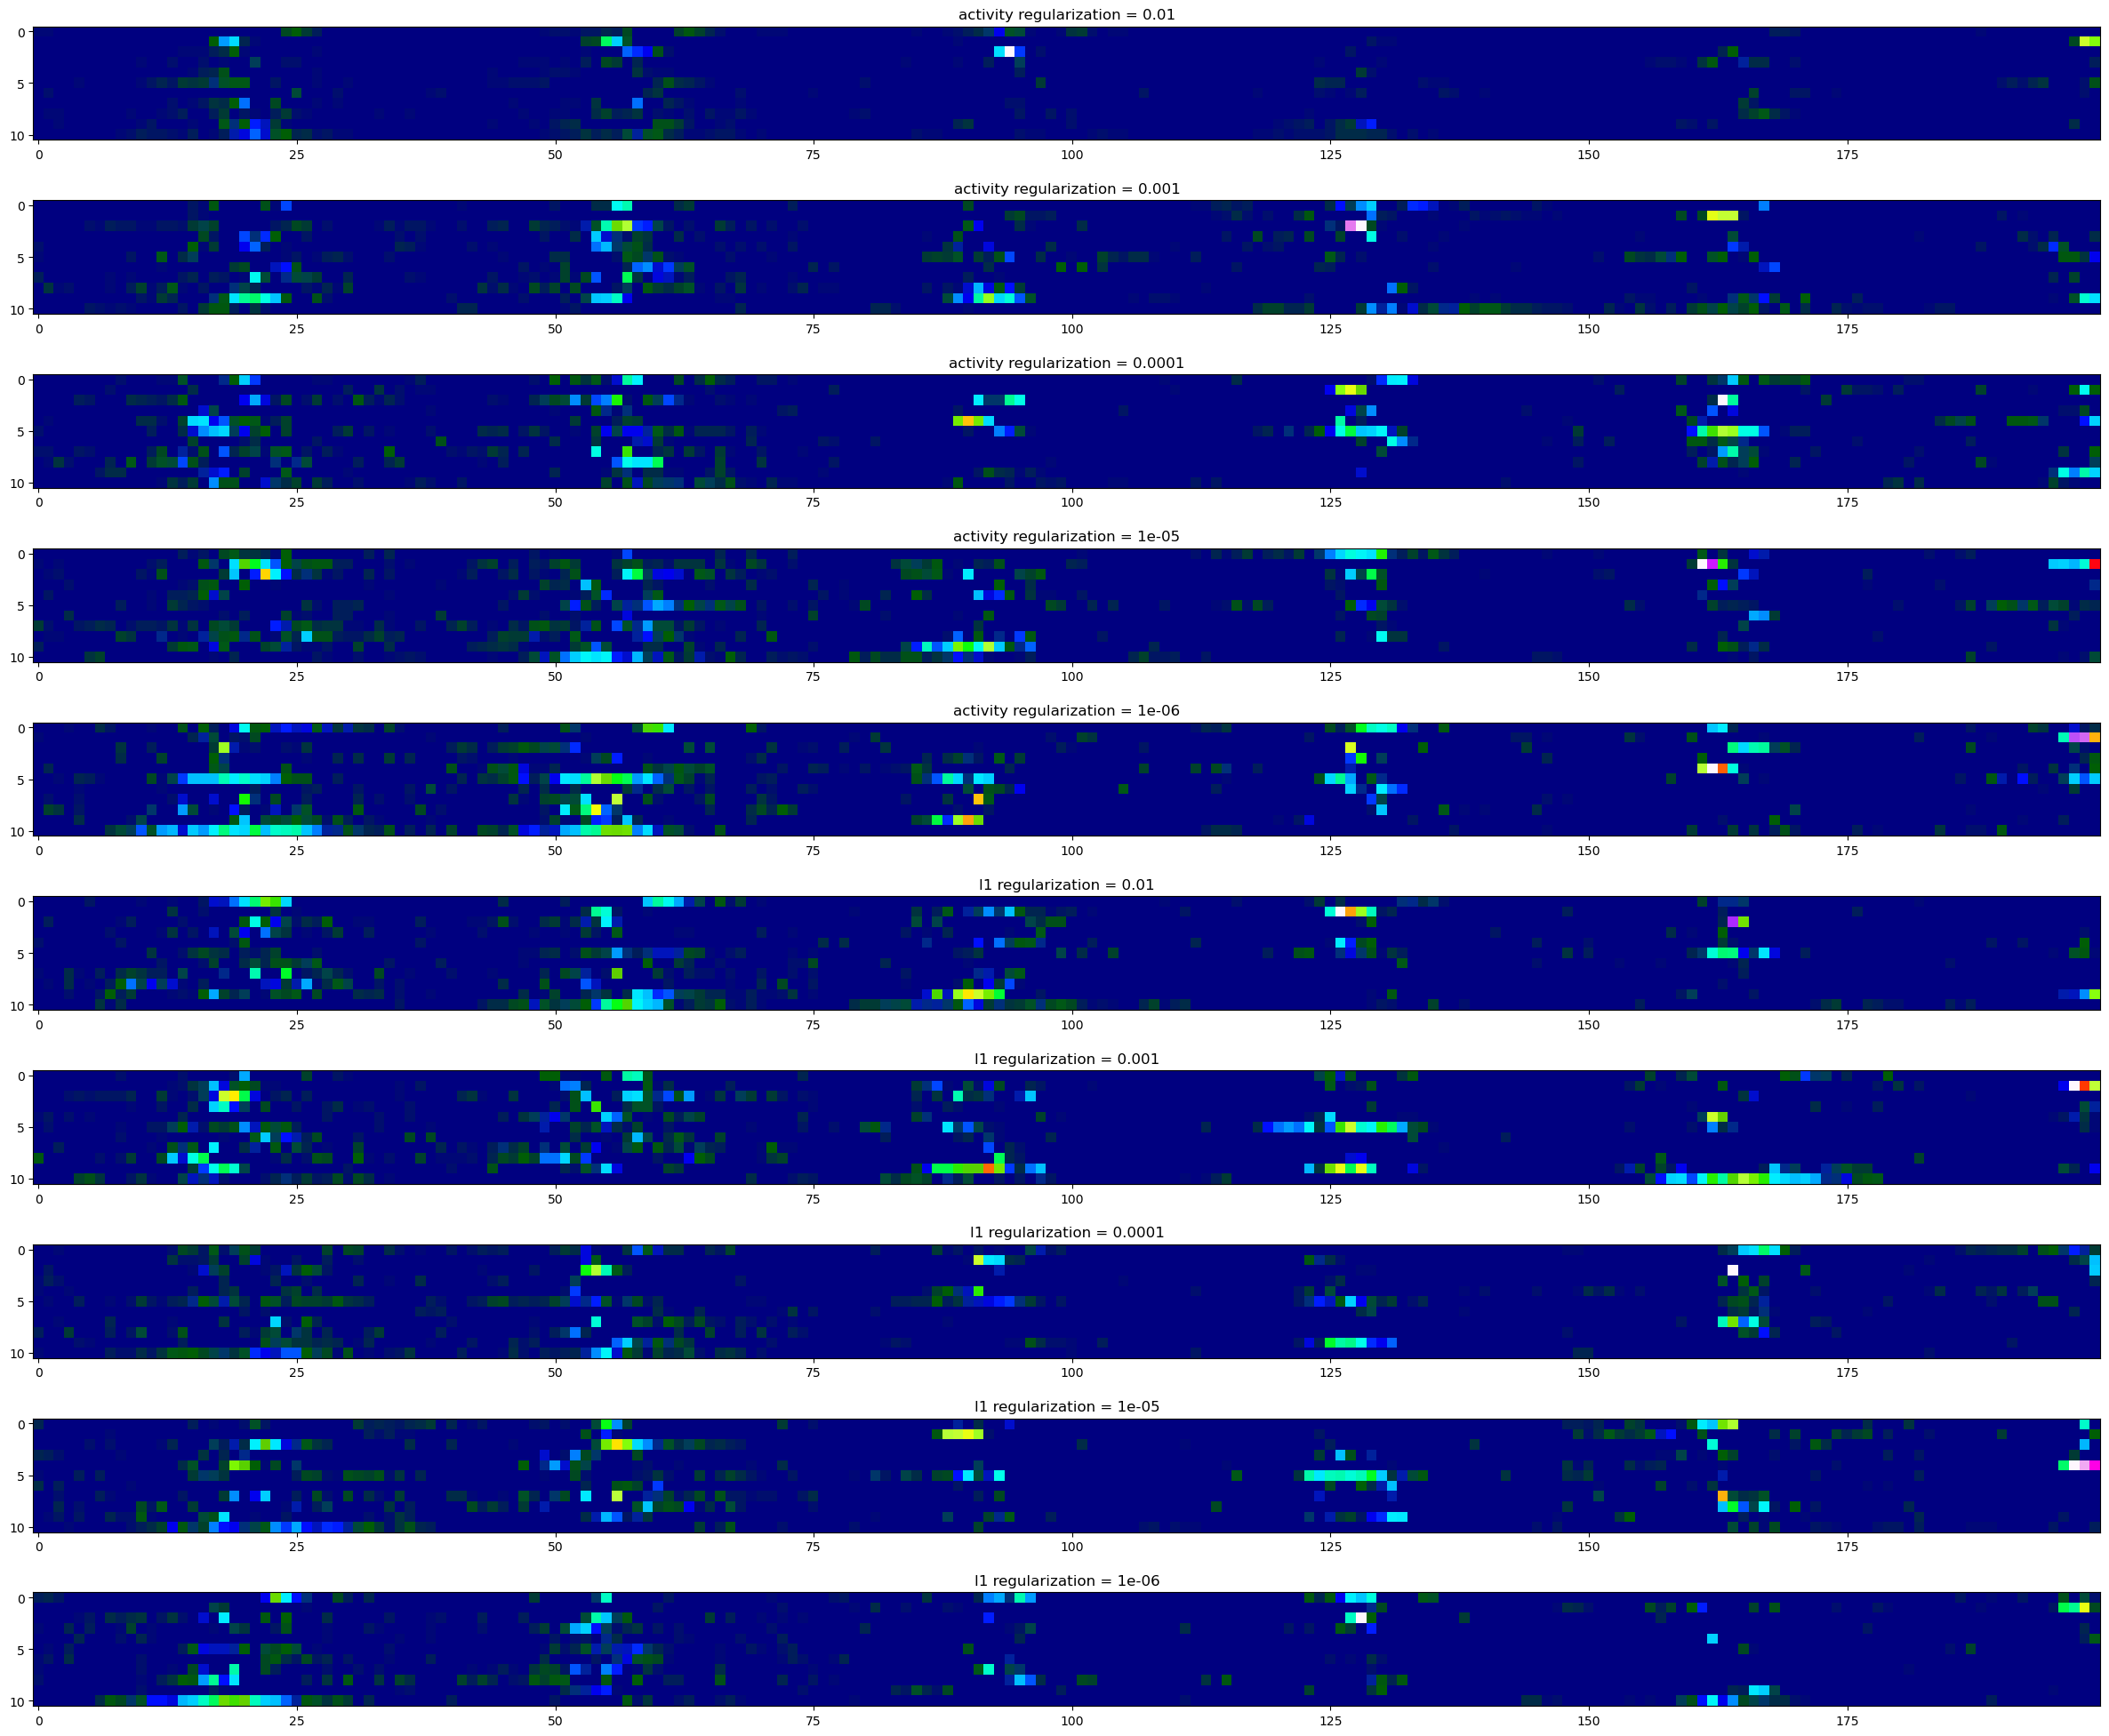

In [327]:
# (concatenate the weights from all the layers)
# plot the weights for each trial
fig = plt.figure(figsize=(30,25))
for i in range(len(e5.trials)):
    trial = e5.trials_where(name='cnim_scaffold'+str(i))[0]
    ax = fig.add_subplot(len(e5.trials),1,i+1)
    im = trial.model.networks_by_name['readout'].layers[0].weights.reshape(1152,11).T[:, 500:700]
    imin = np.min(im)
    imax = np.max(im)
    ax.imshow(im, cmap='gist_ncar', vmin=imin, vmax=imax)
    if 'activity' in trial.trial_params:
        ax.set_title('activity regularization = '+str(trial.trial_params['activity']))
    elif 'l1' in trial.trial_params:
        ax.set_title('l1 regularization = '+str(trial.trial_params['l1']))

# get the robs (and TODOs)

In [328]:
# try some measures of sparseness to determine how well the particular
# norm is driving the weights or activities to become more sparse
# (e.g. how the L1 norm encourages some weights to become zero,
#       due to the way that that particular measure of vector length (i.e. norm) 
#       is minimized when some weights are zero)

In [329]:
# TODO:
# - are the robs correlated? or, which neurons have correlated activity?
# - are the weights correlated? or, which neurons have correlated weights?
# - are the weights correlated with the activity? or, which neurons have correlated weights and activity?
# - try an autoencoder on the robs and compare disentanglement
# - try a variational autoencoder on the robs and compare disentanglement

In [344]:
# calculate the correlation between the robs
trial0e5 = e5.trials_where(name='cnim_scaffold0')[0]
robs = np.array([trial0e5.dataset[i]['robs'].detach().numpy() for i in range(len(trial0e5.dataset))])

lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.


In [345]:
robs.shape

(362504, 11)

In [346]:
# plot the correlation between the robs of the neurons
robs_corr = np.corrcoef(np.transpose(robs))

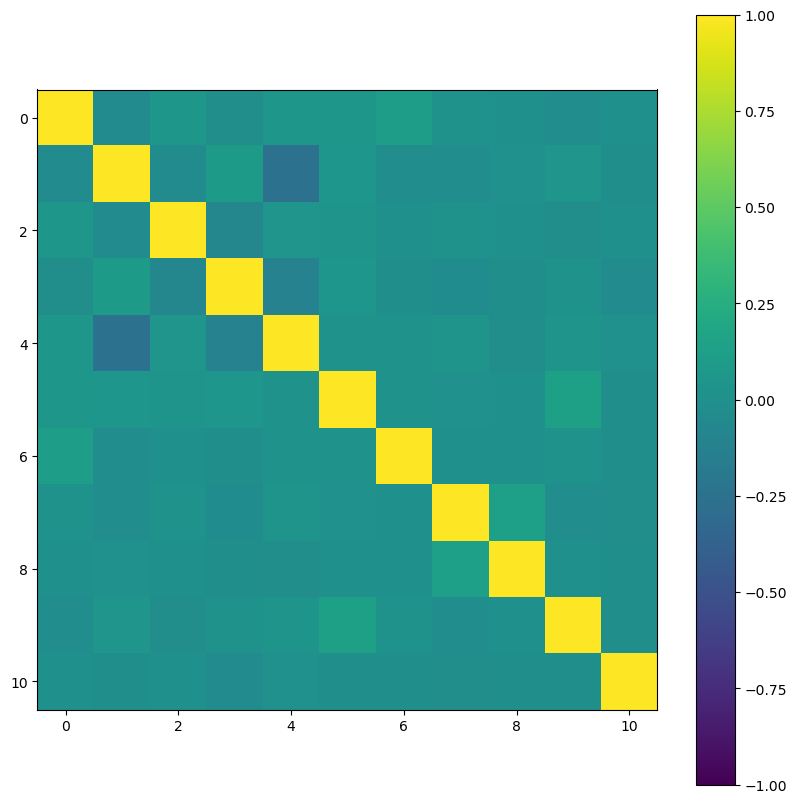

In [347]:
plt.figure(figsize=(10,10))
plt.imshow(robs_corr, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# umap

In [350]:
# use UMAP to visualize the robs
import umap
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(robs.T)
print(embedding.shape)

/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



(11, 2)


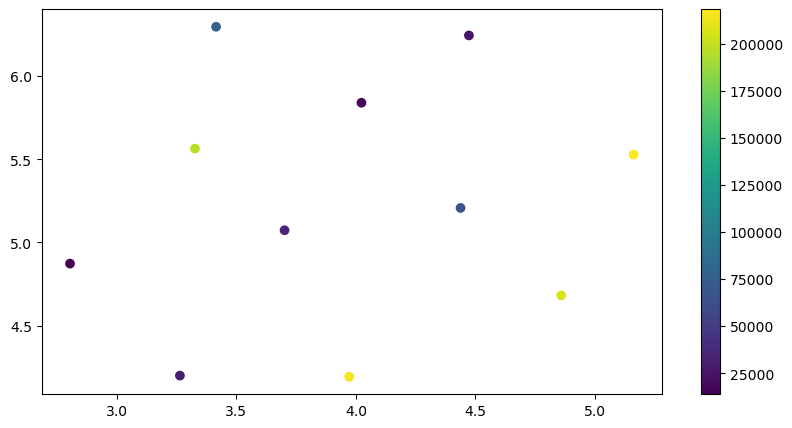

In [353]:
# plot the embedding
counts = np.sum(robs, axis=0)

# for 3D
# import plotly.express as px
# fig = px.scatter_3d(embedding, x=0, y=1, z=2, width=800, height=800, template='simple_white', color=counts)
# fig.show()

# for 2D
plt.figure(figsize=(10,5))
plt.scatter(embedding[:,0], embedding[:,1], c=counts, cmap='viridis')
plt.colorbar()
plt.show()

# measures of sparseness

In [362]:
# measure entropy of the robs and the weights
entropy = lambda x: -np.sum(x*np.log(x+1e-10), axis=0)

In [363]:
# calculate the entropy of the robs
robs_entropy = np.array([entropy(robs[:,i]) for i in range(robs.shape[1])])
robs_entropy

array([ -10037.056 , -125014.44  ,  -15381.143 , -110487.85  ,
       -110618.97  ,   -5968.091 ,  -92291.44  ,   -3575.341 ,
         -3186.4917,  -37310.273 ,   -1794.2382], dtype=float32)

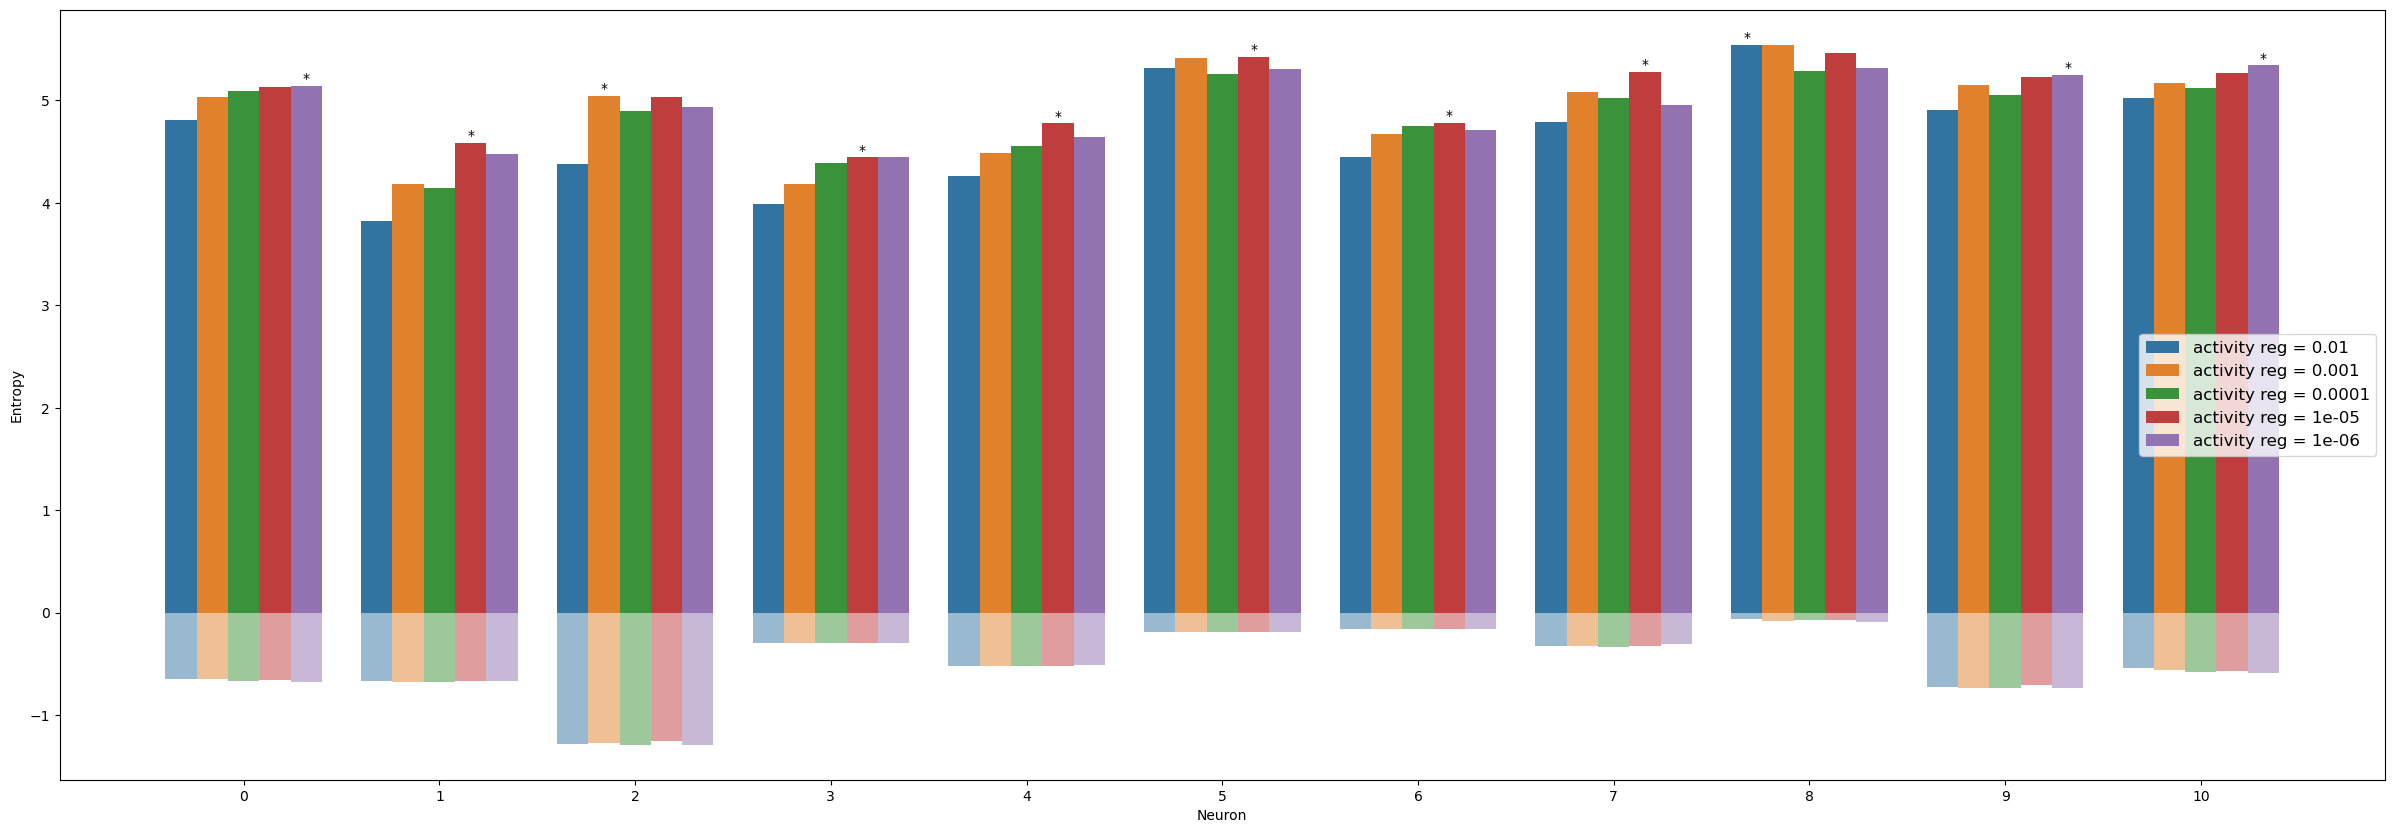

In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Assuming you have e5 and its trials defined here

# subtract this value from the entropy to make it look closer to the LLs
x_offset = 0.08 #0.04
num_neurons = 11

# Prepare the data
data = []
for i in range(0, 5): # len(e5.trials)):
    trial = e5.trials_where(name='cnim_scaffold' + str(i))[0]
    weights = trial.model.networks_by_name['readout'].layers[0].weights.reshape(1152, 11)
    weights_entropy = np.array([entropy(weights[:, i]) for i in range(weights.shape[1])])

    if 'activity' in trial.trial_params:
        label = 'activity reg = ' + str(trial.trial_params['activity'])
    elif 'l1' in trial.trial_params:
        label = 'l1 reg = ' + str(trial.trial_params['l1'])

    for neuron_idx, neuron_entropy in enumerate(weights_entropy):
        neuron_LL = trial.LLs[neuron_idx]
        data.append({'Neuron': neuron_idx, 'Entropy': neuron_entropy, 'LL': neuron_LL, 'Trial': label})

# Create a DataFrame
df = pd.DataFrame(data)

# Get the unique trial labels
trial_labels = df['Trial'].unique()

# Create the bar plot
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(x='Neuron', y='Entropy', hue='Trial', data=df, ax=ax)

# Add the LL values as downward pointing bars below the entropy bars
LL_factor = -1  # Adjust this factor to change the scale of the LL bars
for i, bar in enumerate(ax.containers):
    bar_width = None
    if i >= len(trial_labels):
        break
    for j, b in enumerate(bar):
        if bar_width is None:
            bar_width = b.get_width()
        idx = i*num_neurons + j
        height = df.iloc[idx]['LL'] * LL_factor
        ax.bar(b.get_x()+x_offset, height, width=bar_width, bottom=0, color=b.get_facecolor(), alpha=0.5)

# Set y-axis limits
ax.set_ylim(top=ax.get_ylim()[1])

# Add asterisks to the highest bars for each neuron
max_indices = df.groupby(['Neuron'])['Entropy'].idxmax().values
for i, bar in enumerate(ax.containers):
    if i >= len(trial_labels):
        break
    for j, b in enumerate(bar):
        if df.loc[max_indices[j], 'Trial'] == trial_labels[i]:
            height = b.get_height()
            ax.text(b.get_x() + b.get_width() / 2, height, '*', ha='center', va='bottom')

plt.legend(fontsize=12, loc='center right')
plt.show()

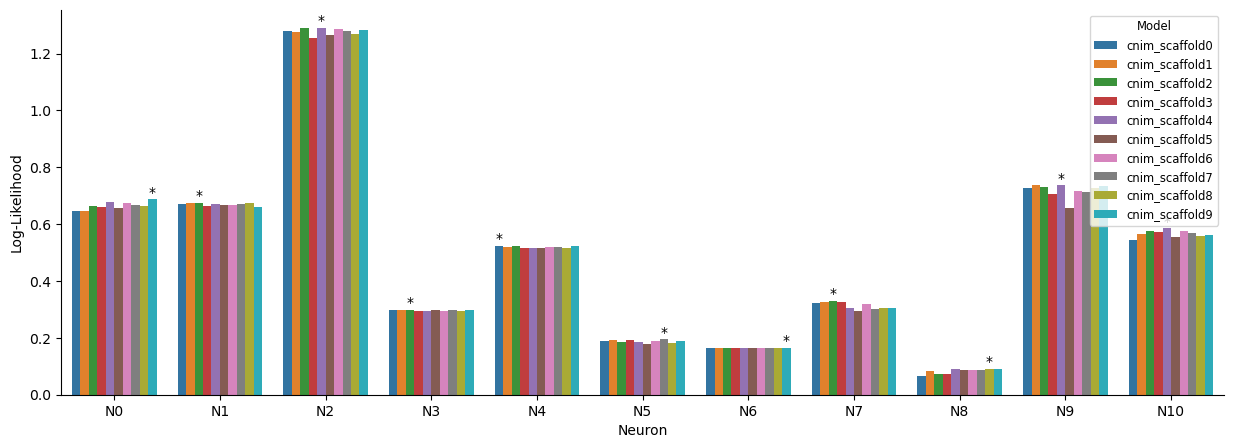

In [412]:
e5.plot_LLs()

In [446]:
trial0 = e5.trials_where(name='cnim_scaffold' + str(0))[0]

df.loc[0*len(trial_labels) + 1, 'LL']
df

Neuron   Entropy        LL                  Trial
0        0  4.811940  0.644850    activity reg = 0.01
1        1  3.823752  0.669920    activity reg = 0.01
2        2  4.379940  1.279463    activity reg = 0.01
3        3  3.987872  0.297297    activity reg = 0.01
4        4  4.260182  0.523876    activity reg = 0.01
5        5  5.317422  0.188902    activity reg = 0.01
6        6  4.447789  0.163909    activity reg = 0.01
7        7  4.788336  0.321472    activity reg = 0.01
8        8  5.544359  0.066008    activity reg = 0.01
9        9  4.905924  0.726635    activity reg = 0.01
10      10  5.020901  0.544182    activity reg = 0.01
11       0  5.029333  0.644460   activity reg = 0.001
12       1  4.180960  0.673478   activity reg = 0.001
13       2  5.041584  1.275921   activity reg = 0.001
14       3  4.181571  0.296496   activity reg = 0.001
15       4  4.490843  0.520337   activity reg = 0.001
16       5  5.416902  0.190800   activity reg = 0.001
17       6  4.669312  0.163757   activity reg = 0.001
18       7  5.086228  0.326130   activity reg = 0.001
19       8  5.540809  0.082698   activity reg = 0.001
20       9  5.148567  0.735857   activity reg = 0.001
21      10  5.175226  0.564680   activity reg = 0.001
22       0  5.090148  0.664751  activity reg = 0.0001
23       1  4.147558  0.675175  activity reg = 0.0001
24       2  4.900243  1.288207  activity reg = 0.0001
25       3  4.389476  0.297709  activity reg = 0.0001
26       4  4.558616  0.522222  activity reg = 0.0001
27       5  5.258386  0.184491  activity reg = 0.0001
28       6  4.749880  0.164014  activity reg = 0.0001
29       7  5.028934  0.330912  activity reg = 0.0001
30       8  5.284205  0.072479  activity reg = 0.0001
31       9  5.057373  0.732165  activity reg = 0.0001
32      10  5.122619  0.577113  activity reg = 0.0001
33       0  5.128831  0.660490   activity reg = 1e-05
34       1  4.588691  0.664855   activity reg = 1e-05
35       2  5.033614  1.255094   activity reg = 1e-05
36       3  4.446029  0.295782   activity reg = 1e-05
37       4  4.776738  0.517648   activity reg = 1e-05
38       5  5.422809  0.191512   activity reg = 1e-05
39       6  4.782836  0.163945   activity reg = 1e-05
40       7  5.281556  0.327240   activity reg = 1e-05
41       8  5.466868  0.073213   activity reg = 1e-05
42       9  5.231654  0.704666   activity reg = 1e-05
43      10  5.272756  0.573440   activity reg = 1e-05
44       0  5.142690  0.676507   activity reg = 1e-06
45       1  4.480352  0.670155   activity reg = 1e-06
46       2  4.933406  1.289547   activity reg = 1e-06
47       3  4.445585  0.295438   activity reg = 1e-06
48       4  4.639109  0.515149   activity reg = 1e-06
49       5  5.304279  0.187051   activity reg = 1e-06
50       6  4.714654  0.163608   activity reg = 1e-06
51       7  4.955520  0.306632   activity reg = 1e-06
52       8  5.316845  0.089371   activity reg = 1e-06
53       9  5.252358  0.736216   activity reg = 1e-06
54      10  5.342006  0.584926   activity reg = 1e-06

# load experiment for entropy and L2 regularization

In [447]:
e6 = exp.load('reg_experiment_06', experiment_location='experiments', datadir='Mdata')
e6.trials

null_adjusted_LL num_filters  num_inh_percent    expt kernel_widths  \
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr   entropy             name  \
0        6000  cnim_scaffold  1.000000   cnim_scaffold0   
0        6000  cnim_scaffold  0.100000   cnim_scaffold1   
0        6000  cnim_scaffold       NaN  cnim_scaffold10   
0        6000  cnim_scaffold       NaN  cnim_scaffold11   
0        6000  cnim_scaffold       NaN  cnim_scaffold12   
0        6000  cnim_scaffold       NaN  cnim_scaffold13   
0        6000  cnim_scaffold  0.010000   cnim_scaffold2   
0        6000  cnim_scaffold  0.001000   cnim_scaffold3   
0        6000  cnim_scaffold  0.000100   cnim_scaffold4   
0        6000  cnim_scaffold  0.000010   cnim_scaffold5   
0        6000  cnim_scaffold  0.000001   cnim_scaffold6   
0        6000  cnim_scaffold       NaN   cnim_scaffold7   
0        6000  cnim_scaffold       NaN   cnim_scaffold8   
0        6000  cnim_scaffold       NaN   cnim_scaffold9   

                                         trial  mean_LLs        l2  
0  <experiment.Trial object at 0x7f80d0dd6550>  0.068728       NaN  
0  <experiment.Trial object at 0x7f80d0670df0>  0.080771       NaN  
0  <experiment.Trial object at 0x7f80d04dcf40>  0.470130  0.001000  
0  <experiment.Trial object at 0x7f80d04783d0>  0.466552  0.000100  
0  <experiment.Trial object at 0x7f80d22bf430>  0.480252  0.000010  
0  <experiment.Trial object at 0x7f80d1b9a9a0>  0.480444  0.000001  
0  <experiment.Trial object at 0x7f80d2741700>  0.092651       NaN  
0  <experiment.Trial object at 0x7f80d0426040>  0.159943       NaN  
0  <experiment.Trial object at 0x7f80d05ebd90>  0.214199       NaN  
0  <experiment.Trial object at 0x7f80d0d82cd0>  0.381283       NaN  
0  <experiment.Trial object at 0x7f80d0b35340>  0.457045       NaN  
0  <experiment.Trial object at 0x7f80

In [455]:
trials_entropy = e6.trials[e6.trials.entropy != np.NaN]
trials_entropy

KeyError: True

lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses
lazy loading losses


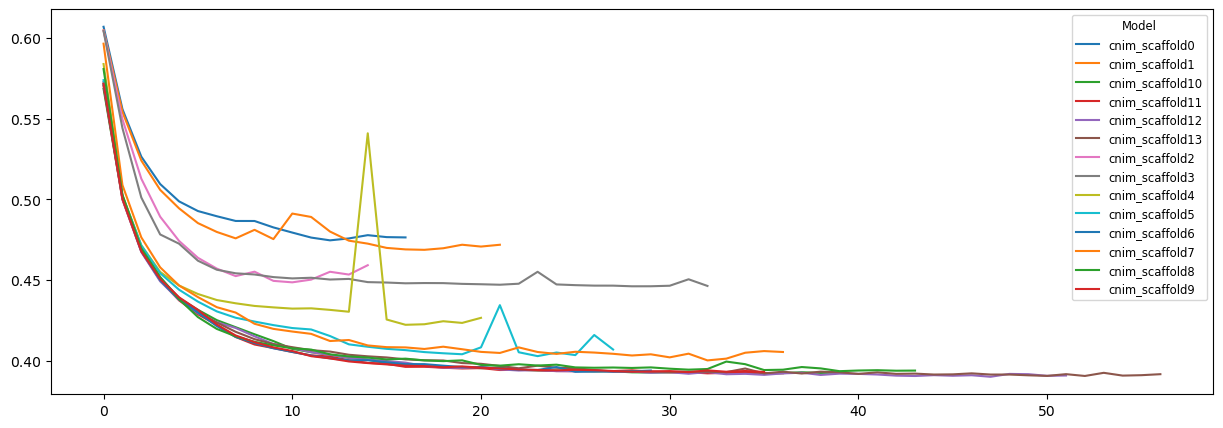

In [449]:
e6.plot_losses()

# get the activity of the neurons given an input stimulus

In [565]:
# load experiment 7 (different activity reg values, no inhibition)
e7 = exp.load('reg_experiment_07', experiment_location='experiments', datadir='Mdata')
e7.trials

null_adjusted_LL num_filters  num_inh_percent    expt kernel_widths  \
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr      activity            name  \
0        6000  cnim_scaffold  0.000000e+00  cnim_scaffold0   
0        6000  cnim_scaffold  1.000000e+00  cnim_scaffold1   
0        6000  cnim_scaffold  5.000000e-01  cnim_scaffold2   
0        6000  cnim_scaffold  1.000000e-01  cnim_scaffold3   
0        6000  cnim_scaffold  1.000000e-02  cnim_scaffold4   
0        6000  cnim_scaffold  1.000000e-03  cnim_scaffold5   
0        6000  cnim_scaffold  1.000000e-04  cnim_scaffold6   
0        6000  cnim_scaffold  1.000000e-05  cnim_scaffold7   
0        6000  cnim_scaffold  1.000000e-06  cnim_scaffold8   
0        6000  cnim_scaffold  1.000000e-07  cnim_scaffold9   

                                         trial  mean_LLs  
0  <experiment.Trial object at 0x7f80d90f2280>  0.475560  
0  <experiment.Trial object at 0x7f80d82ee3a0>  0.286034  
0  <experiment.Trial object at 0x7f80d84dd160>  0.336320  
0  <experiment.Trial object at 0x7f80d85b35b0>  0.413781  
0  <experiment.Trial object at 0x7f80d85bdaf0>  0.463517  
0  <experiment.Trial object at 0x7f80d595a970>  0.451843  
0  <experiment.Trial object at 0x7f80d9140d30>  0.465908  
0  <experiment.Trial object at 0x7f80d90c1eb0>  0.476332  
0  <experiment.Trial object at 0x7f80d8265eb0>  0.473080  
0  <experiment.Trial object at 0x7f80d8eb65b0>  0.482536

In [569]:
# get the activity of the neurons given an input stimulus

trial_cnim_scaffold2 = e7.trials_where(name='cnim_scaffold2')[0]
print(trial_cnim_scaffold2.trial_params.keys())

# get the model
model = trial_cnim_scaffold2.model

start = 0
end = 10
results = predict.predict(model,
                          dataset=trial_cnim_scaffold2.dataset[start:end],
                          network_names_to_use=['core'])

dict_keys(['null_adjusted_LL', 'num_filters', 'num_inh_percent', 'expt', 'kernel_widths', 'kernel_heights', 'copy_weights', 'freeze_weights', 'include_MUs', 'is_multiexp', 'batch_size', 'modelstr', 'activity'])
prev_output shape torch.Size([10, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([10, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([10, 288]) ni 0 NetworkType.scaffold li 2


In [574]:
print(results.outputs[0]['core'][0].shape, results.outputs[0]['core'][1].shape, results.outputs[0]['core'][2].shape)

import copy
def entropy(x):
    # flatten x
    x_flat = np.squeeze(copy.deepcopy(x))
    # normalize x
    x_normalized = x/np.sum(x_flat)
    # replace the zeros with ones before taking the log2
    x_normalized[x_normalized==0] = 1
    return -np.sum(x_normalized*np.log2(x_normalized))

im = np.concatenate([results.outputs[0]['core'][i] for i in range(len(results.outputs[0]['core']))], axis=1)
# replace the zeros with ones before taking the log2
entropy(im)

# this isn't working, b/c you can't take the log of negative values
# TODO: train a new model w/o any inhibitory units

(1, 576) (1, 288) (1, 288)


8.925046

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape to

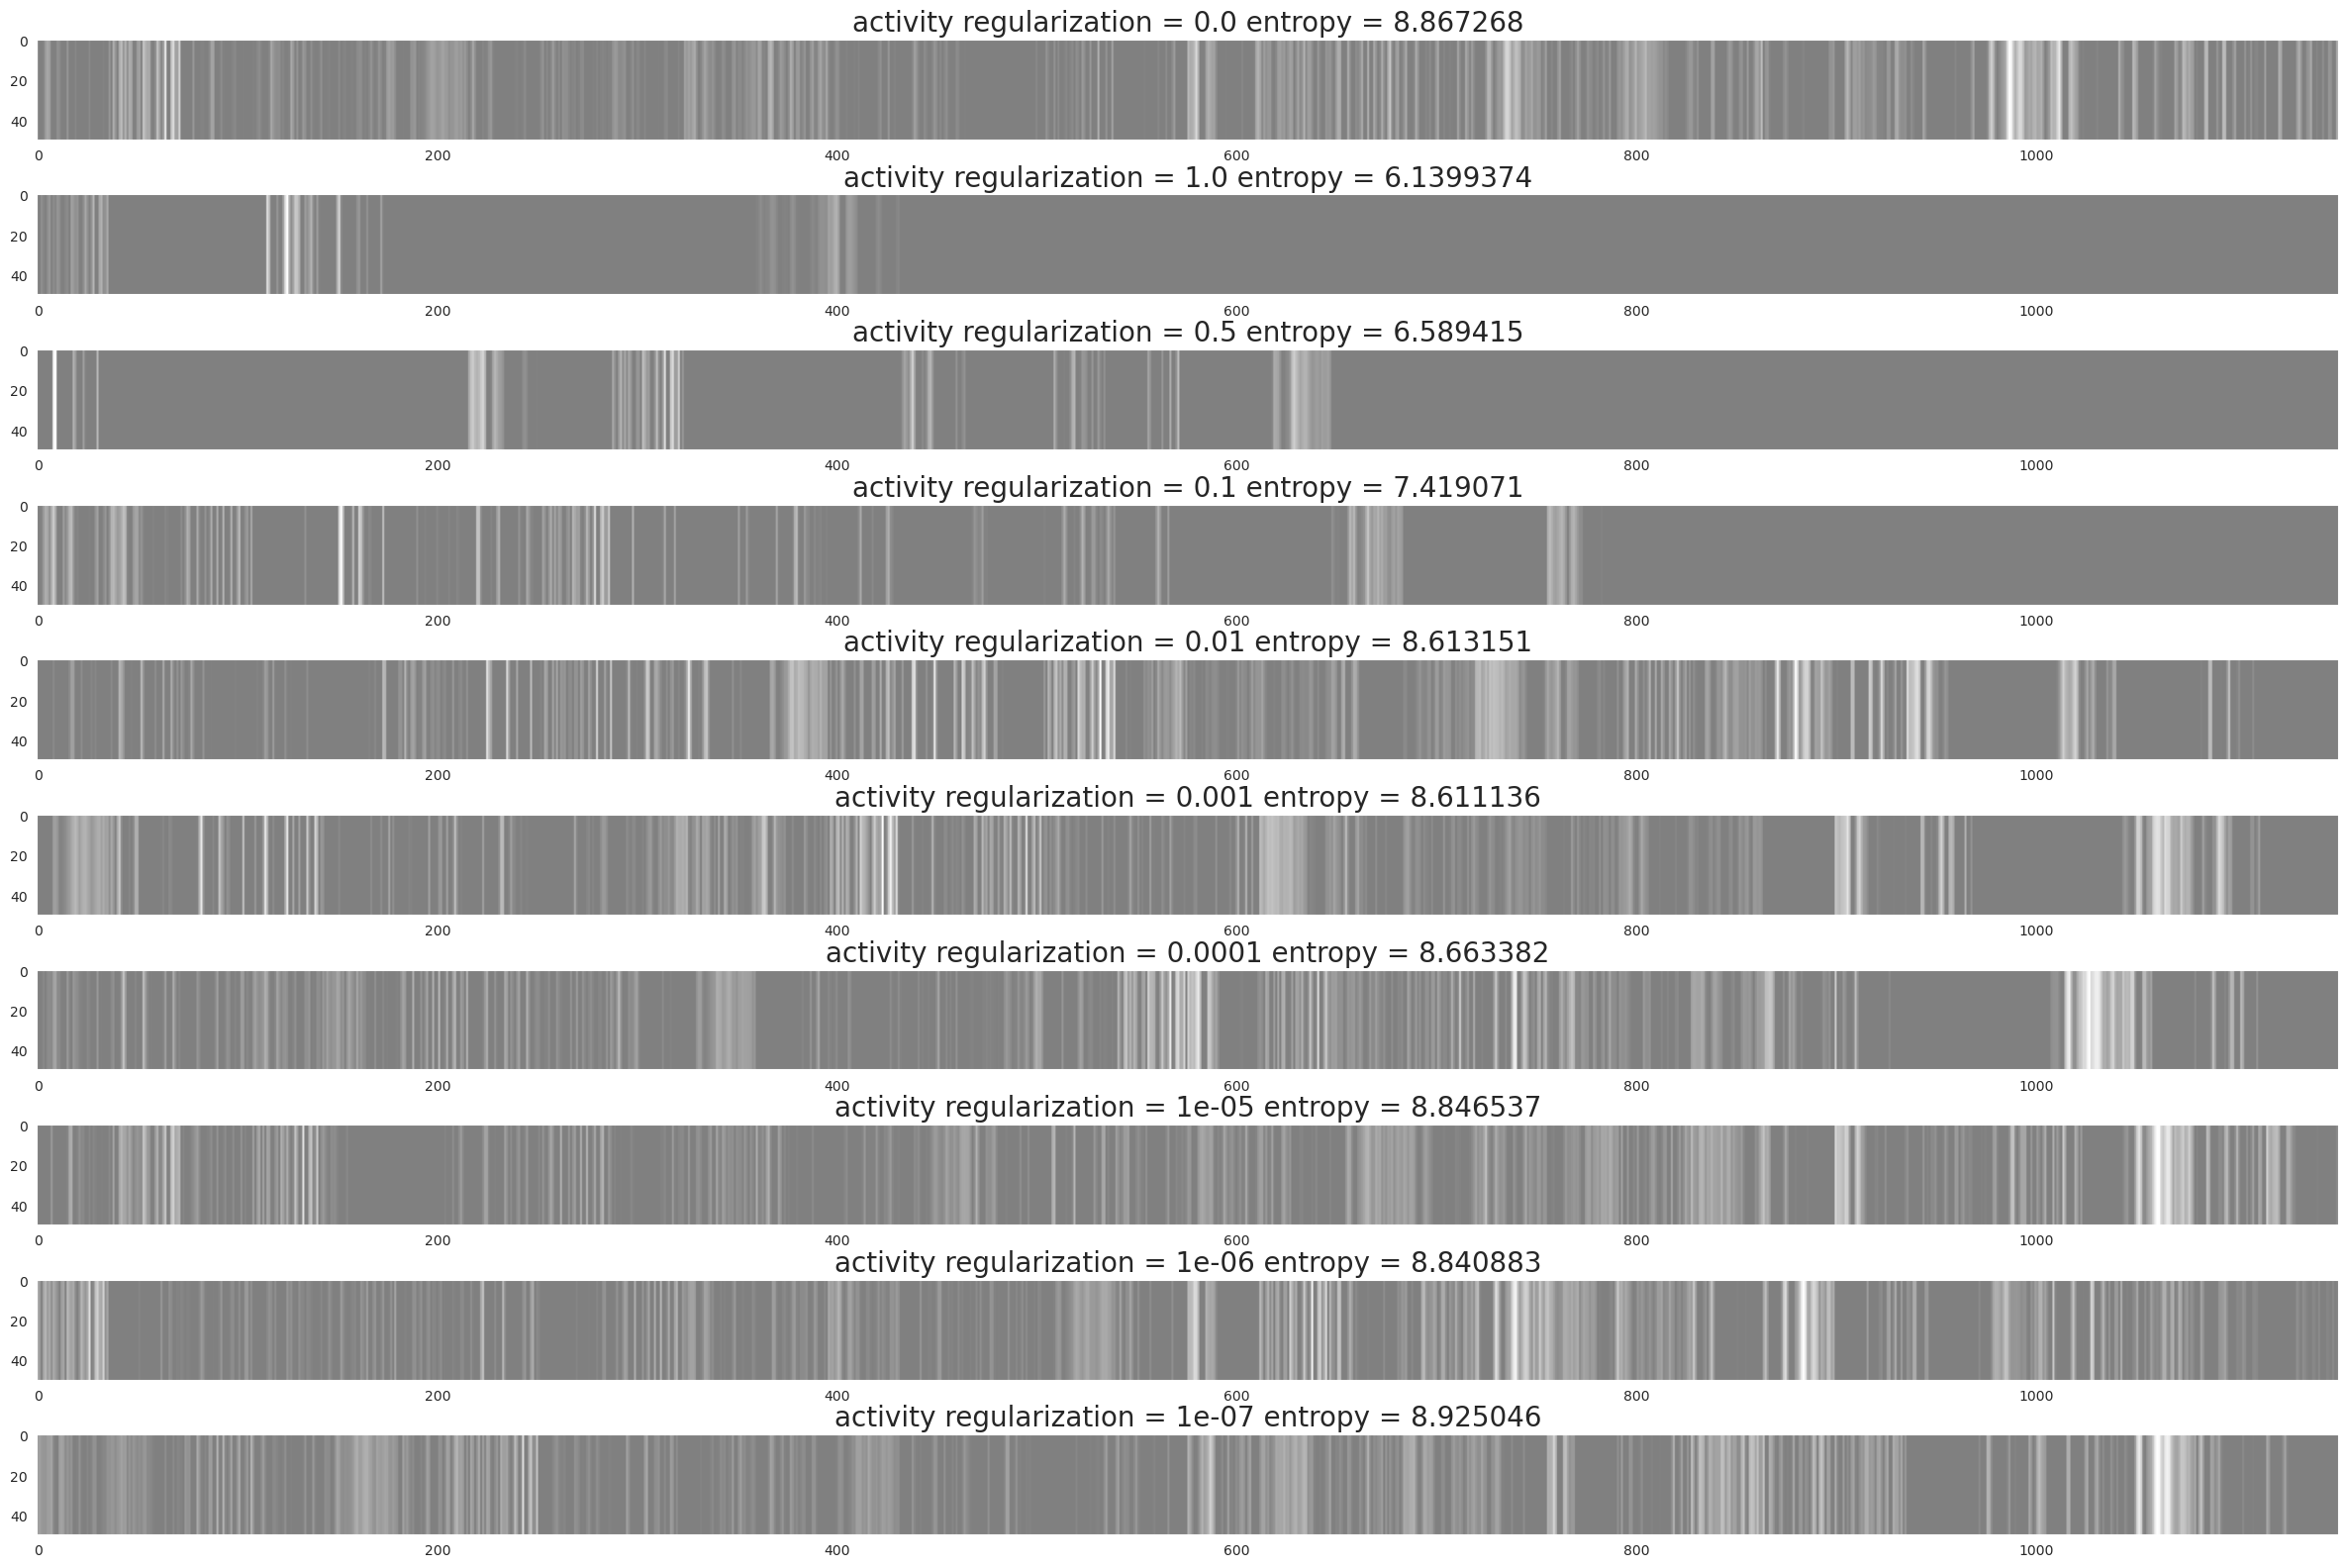

In [576]:
# compare the activity of the subunits and neurons for different reg values
# (concatenate the weights from all the layers)
# plot the weights for each trial
fig = plt.figure(figsize=(30,20))
# turn gridlines off
for i in range(len(e7.trials)):
    trial = e7.trials_where(name='cnim_scaffold'+str(i))[0]
    ax = fig.add_subplot(len(e5.trials),1,i+1)
    ax.grid(False) # turn gridlines off
    model = trial.model
    results = predict.predict(model,
                              dataset=trial.dataset[1000:1001],
                              network_names_to_use=['core'])
    im = np.concatenate([results.outputs[0]['core'][i] for i in range(len(results.outputs[0]['core']))], axis=1)
    im_entropy = entropy(im)
    im = np.repeat(im, 50, axis=0)
    imax = np.max(im)
    imin = -imax
    ax.imshow(im, cmap='gray', vmin=imin, vmax=imax)
    
    ax.set_title('activity regularization = '+str(trial.trial_params['activity']) + ' entropy = '+str(im_entropy), fontsize=20)

plt.show()

# plot Jacobians

In [589]:
# get the activity of the neurons given an input stimulus

trial_cnim_scaffold2 = e7.trials_where(name='cnim_scaffold2')[0]
print(trial_cnim_scaffold2.trial_params.keys())

# get the model
model = trial_cnim_scaffold2.model

start = 0
end = 10
results = predict.predict(model,
                          dataset=trial_cnim_scaffold2.dataset[start:end],
                          network_names_to_use=['core'])
results.jacobian[0].shape

dict_keys(['null_adjusted_LL', 'num_filters', 'num_inh_percent', 'expt', 'kernel_widths', 'kernel_heights', 'copy_weights', 'freeze_weights', 'include_MUs', 'is_multiexp', 'batch_size', 'modelstr', 'activity'])
prev_output shape torch.Size([10, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([10, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([10, 288]) ni 0 NetworkType.scaffold li 2


torch.Size([1, 11, 360])

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


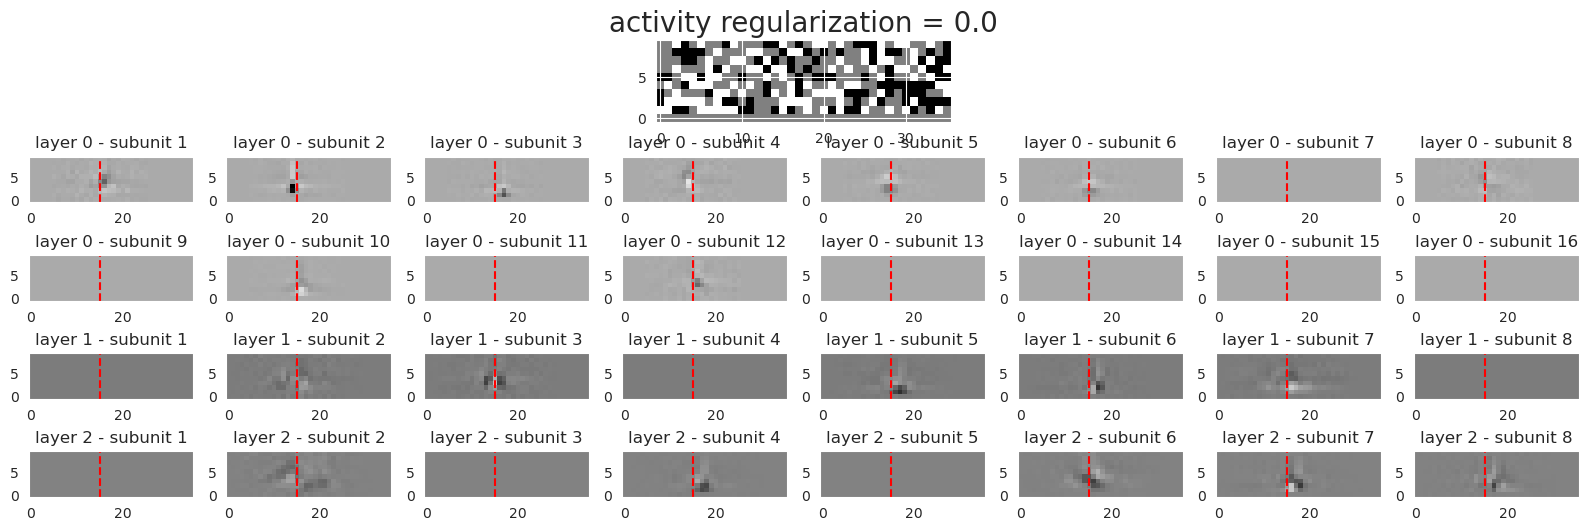

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


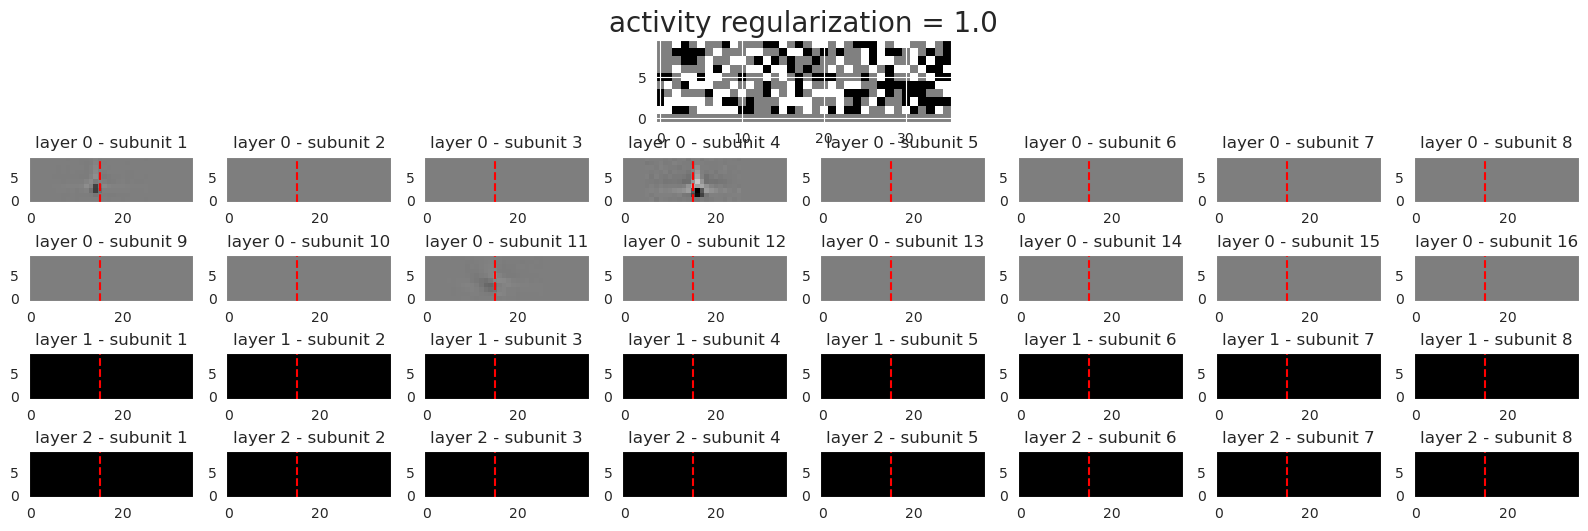

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


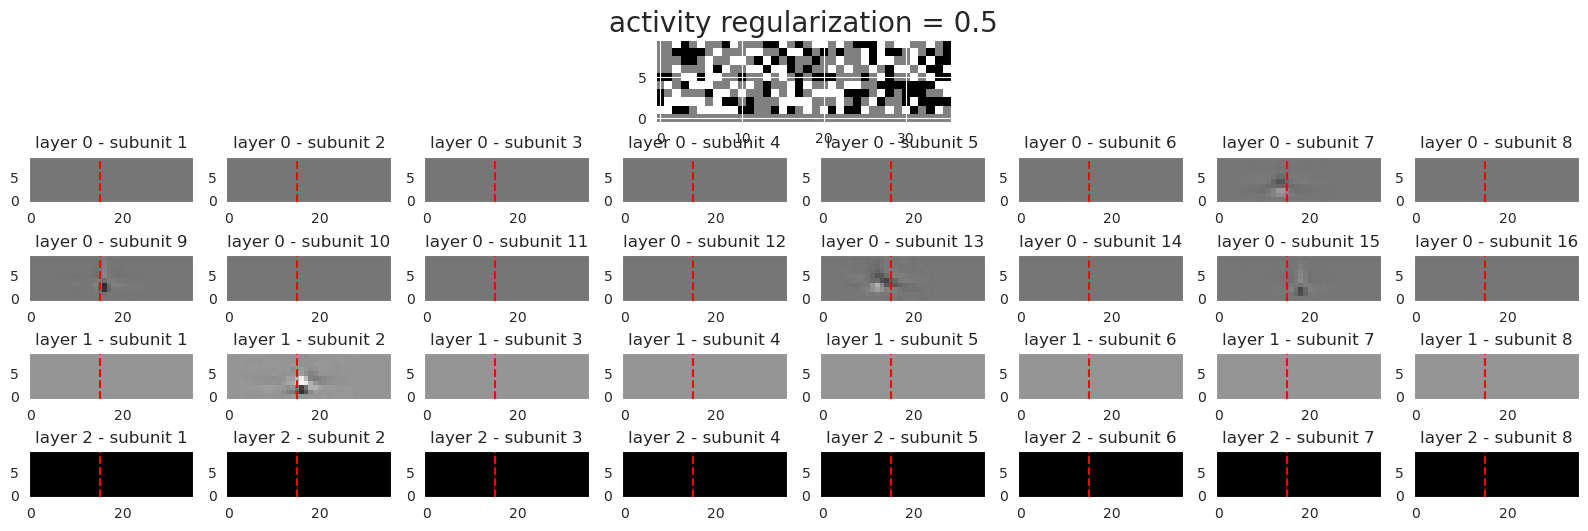

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


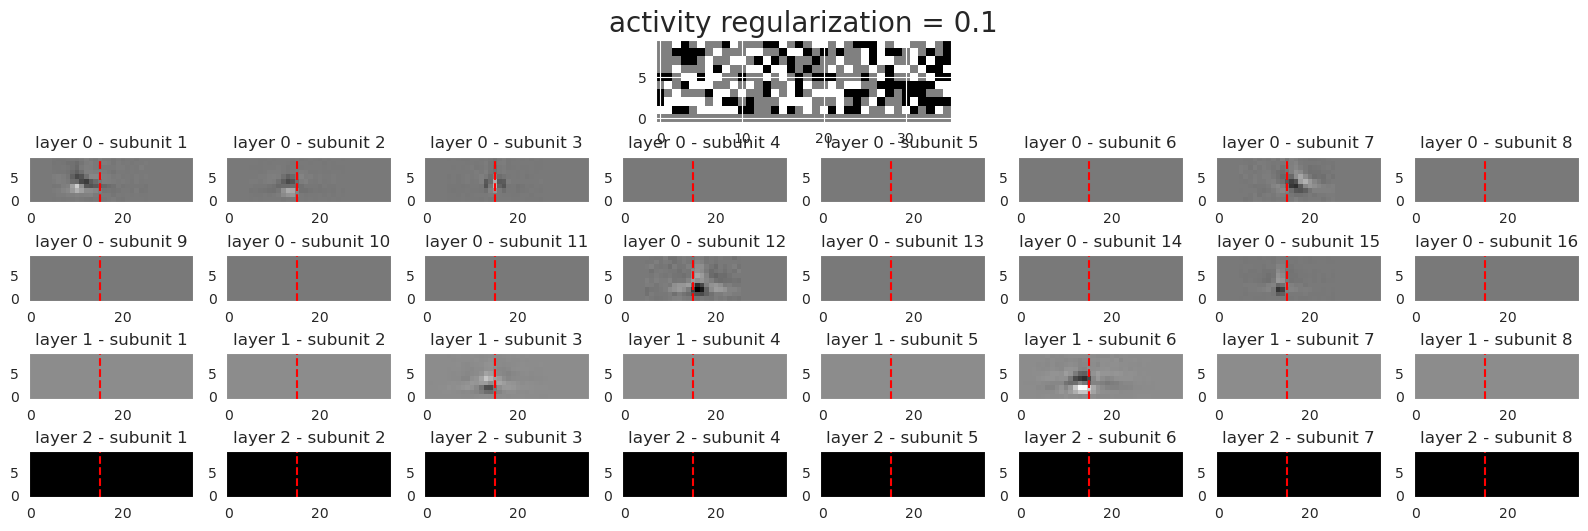

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


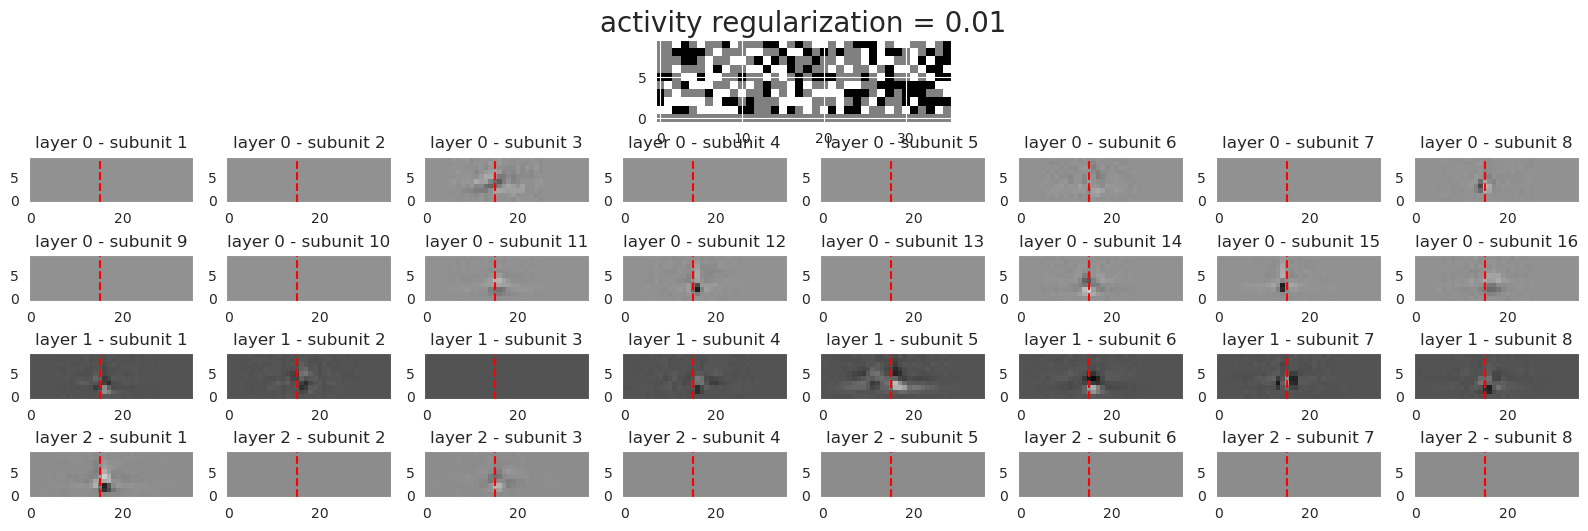

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


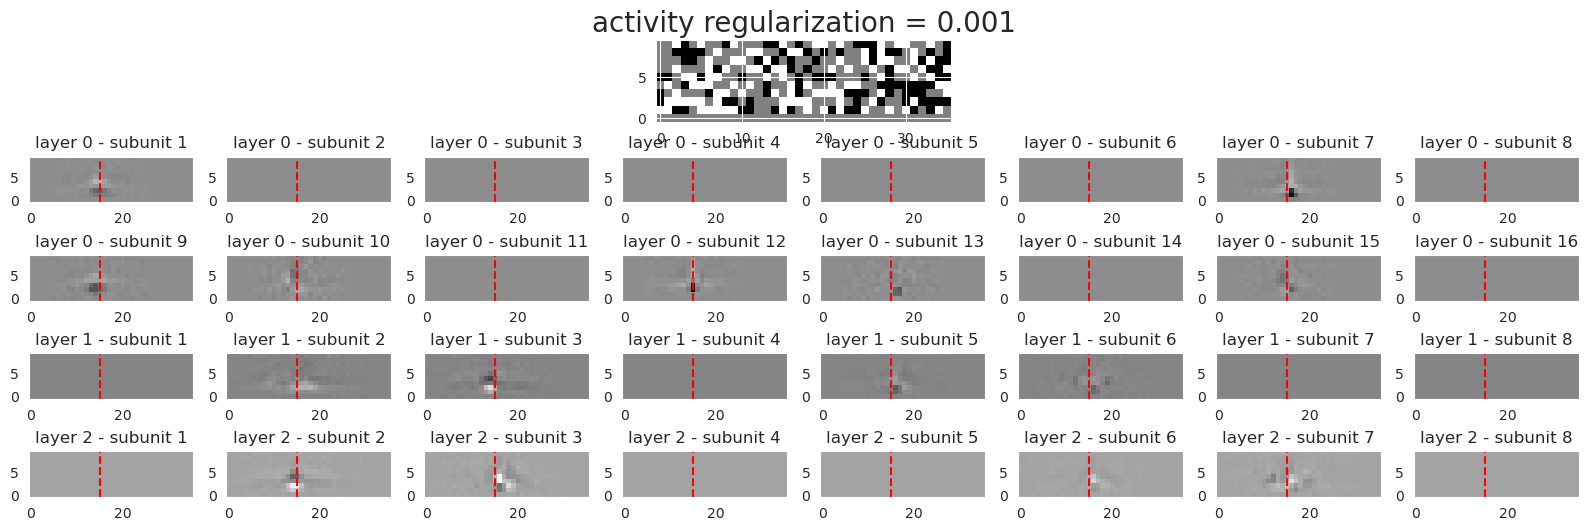

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


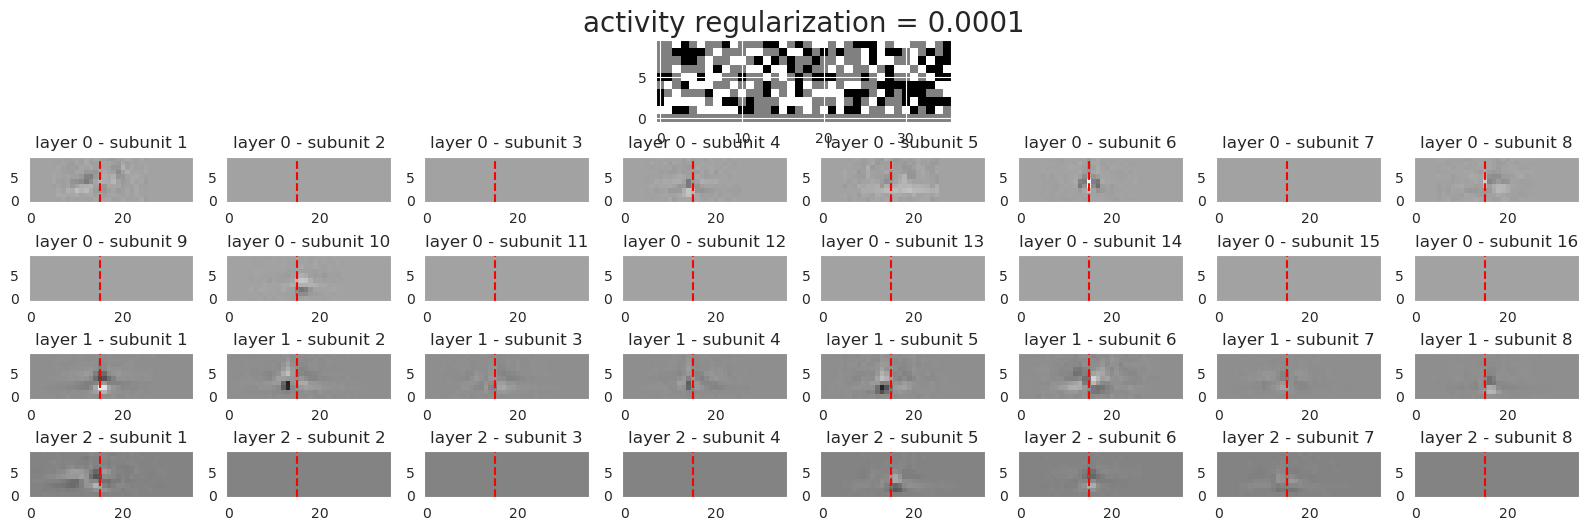

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


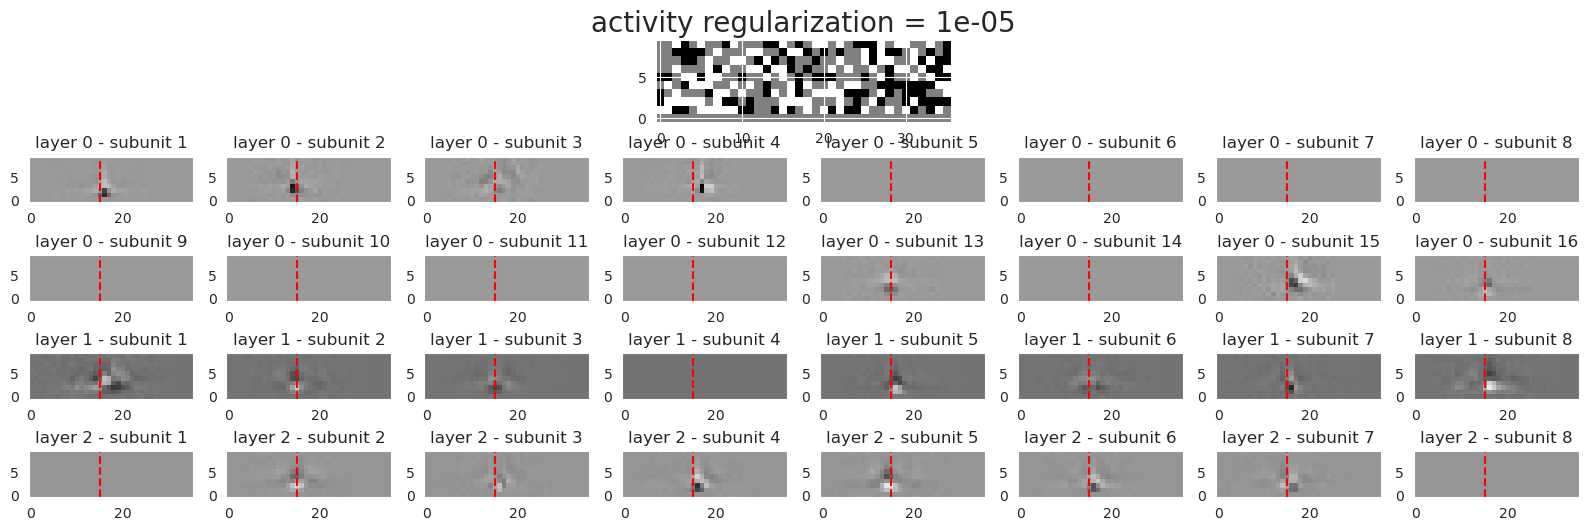

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


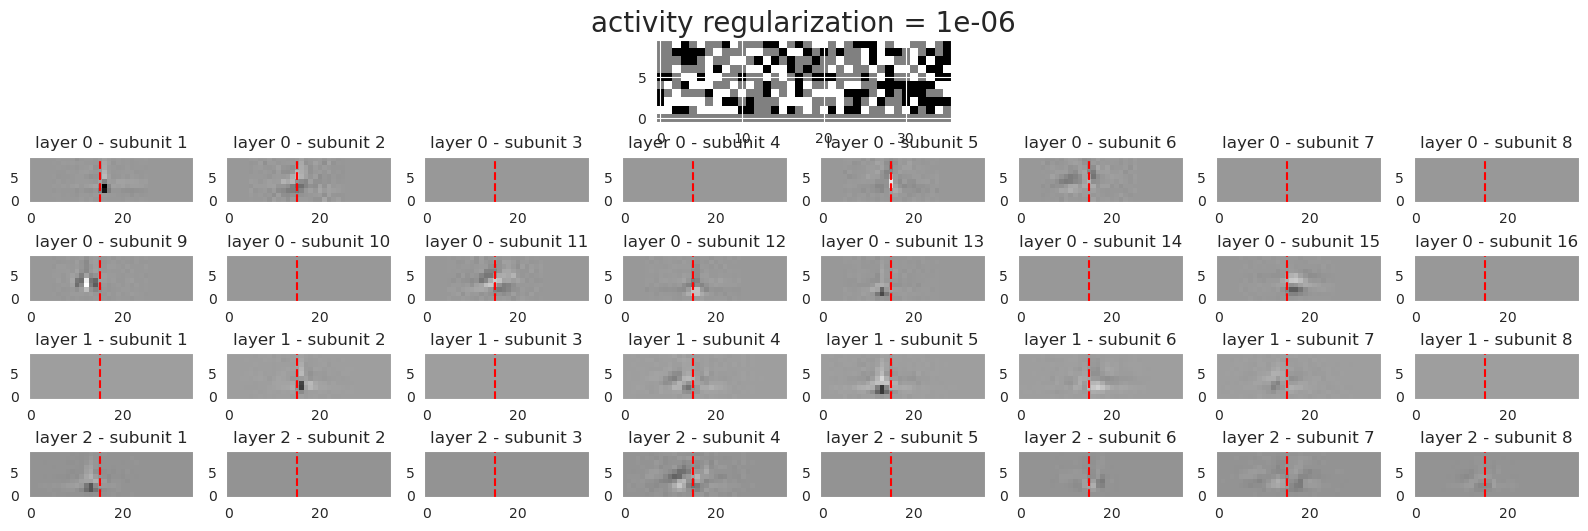

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


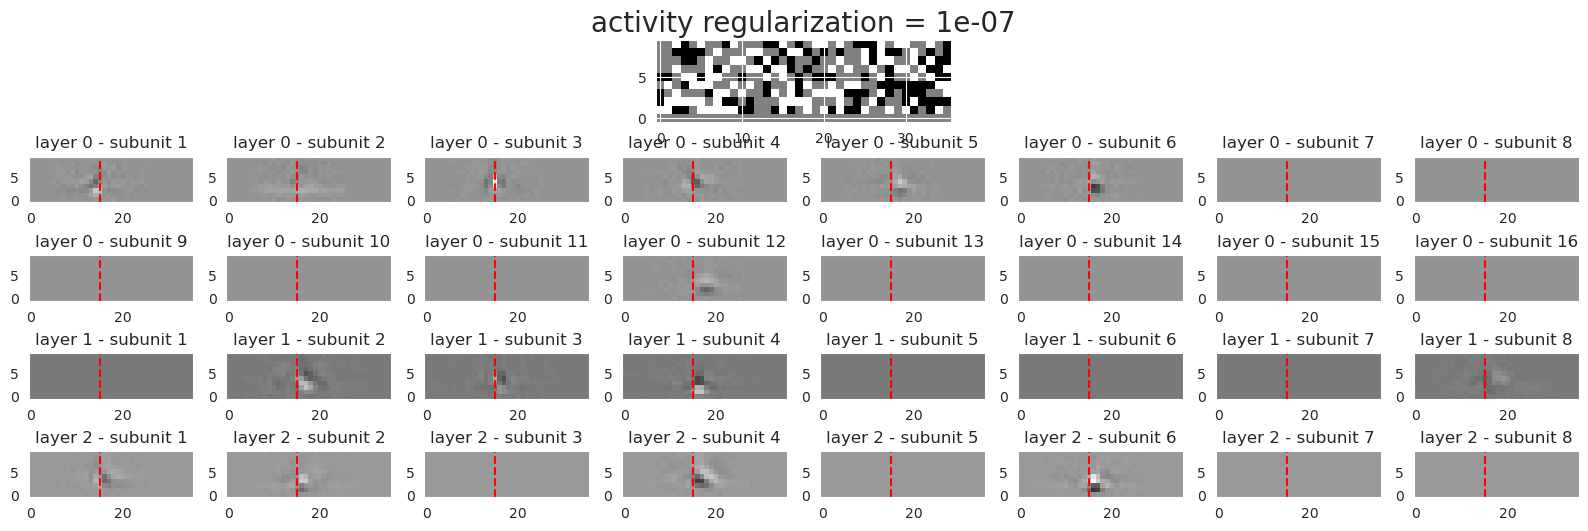

In [592]:
# plot the Jacobians for each trial
# turn gridlines off
for i in range(len(e7.trials)):
    trial = e7.trials_where(name='cnim_scaffold'+str(i))[0]
    model = trial.model
    ax = fig.add_subplot(len(e5.trials),1,i+1)
    ax.grid(False) # turn gridlines off
    
    inps = trial.dataset.stim[start:end]
    t = 0

    results = predict.predict(model,
                              dataset=trial.dataset[1000:1001],
                              network_names_to_use=['core'])
    
    imins = []
    imaxs = []
    for l in range(3):
        imins.append(np.min(np.concatenate([results.jacobians[t]['core'][l][0,:].flatten() for i in range(start, end)])))
        imaxs.append(np.max(np.concatenate([results.jacobians[t]['core'][l][0,:,:].flatten() for i in range(start, end)])))
    
    num_subunits = [16, 8, 8]
    rows = 8
    cols = 8
    fig = plt.figure(figsize=(20,10))
    grid = plt.GridSpec(rows, cols)
    i = 0
    # plot the stim for the current time
    ax_stim = fig.add_subplot(grid[0, :])
    ax_stim.imshow(inps[t].reshape(36,10).T, interpolation='none', cmap='gray', origin='lower')
    ax_stim.set_title('activity regularization = '+str(trial.trial_params['activity']), fontsize=20)

    for l in range(3):
        for u in range(num_subunits[l]):
            ax_cluster = fig.add_subplot(grid[i//cols+1, i%cols])
            subunit_jacobian = results.jacobians[t]['core'][l][0,36*u:36*(u+1),:]
            ax_cluster.imshow(subunit_jacobian[15].reshape(36,10).T,
                              vmin=imins[l], vmax=imaxs[l],
                              interpolation='none',
                              cmap='gray',
                              origin='lower')
            # draw a vertical line at point 15
            ax_cluster.axvline(x=15, color='r', linestyle='--')
            ax_cluster.set_title('layer ' + str(l) + ' - subunit ' + str(u+1))
            # turn gridlines off
            ax_cluster.grid(False)
            i += 1
    
    plt.show()

# nonneg + activity

In [603]:
# load experiment 8 (different activity reg values, no inhibition)
e8 = exp.load('reg_experiment_08', experiment_location='experiments', datadir='Mdata')
e8.trials

null_adjusted_LL num_filters  num_inh_percent    expt kernel_widths  \
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   
0              True      16,8,8              0.0  expt04       21,11,5   

  kernel_heights  copy_weights  freeze_weights  include_MUs  is_multiexp  \
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   
0          3,3,3         False           False        False        False   

   batch_size       modelstr  nonneg             name  \
0        6000  cnim_scaffold  1.0000   cnim_scaffold0   
0        6000  cnim_scaffold  0.5000   cnim_scaffold1   
0        6000  cnim_scaffold  0.5000  cnim_scaffold10   
0        6000  cnim_scaffold  0.1000  cnim_scaffold11   
0        6000  cnim_scaffold  0.0100  cnim_scaffold12   
0        6000  cnim_scaffold  0.1000  cnim_scaffold13   
0        6000  cnim_scaffold  0.0100  cnim_scaffold14   
0        6000  cnim_scaffold  0.1000   cnim_scaffold2   
0        6000  cnim_scaffold  0.0100   cnim_scaffold3   
0        6000  cnim_scaffold  0.0010   cnim_scaffold4   
0        6000  cnim_scaffold  0.0001   cnim_scaffold5   
0        6000  cnim_scaffold  1.0000   cnim_scaffold6   
0        6000  cnim_scaffold  0.5000   cnim_scaffold7   
0        6000  cnim_scaffold  1.0000   cnim_scaffold8   
0        6000  cnim_scaffold  0.1000   cnim_scaffold9   

                                         trial  mean_LLs  activity  
0  <experiment.Trial object at 0x7f80c35acdf0>  0.175302       NaN  
0  <experiment.Trial object at 0x7f80d5d02850>  0.216909       NaN  
0  <experiment.Trial object at 0x7f80c32f7670>  0.167444      0.10  
0  <experiment.Trial object at 0x7f80ca4b40a0>  0.164344      0.10  
0  <experiment.Trial object at 0x7f80da0703a0>  0.169946      0.10  
0  <experiment.Trial object at 0x7f80d5d02970>  0.231157      0.01  
0  <experiment.Trial object at 0x7f80d5d0c8b0>  0.191430      0.01  
0  <experiment.Trial object at 0x7f80d5d00520>  0.185641       NaN  
0  <experiment.Trial object at 0x7f80c32fa160>  0.205930       NaN 

lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360])

/tmp/ipykernel_399405/745461314.py:11: RuntimeWarning:

invalid value encountered in log2



lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2
lazy loading dataset
Loading ['expt04']
Loading expt04
  Time embedding...
  Done.
prev_output shape torch.Size([1, 360])

ValueError: num must be 1 <= num <= 10, not 11

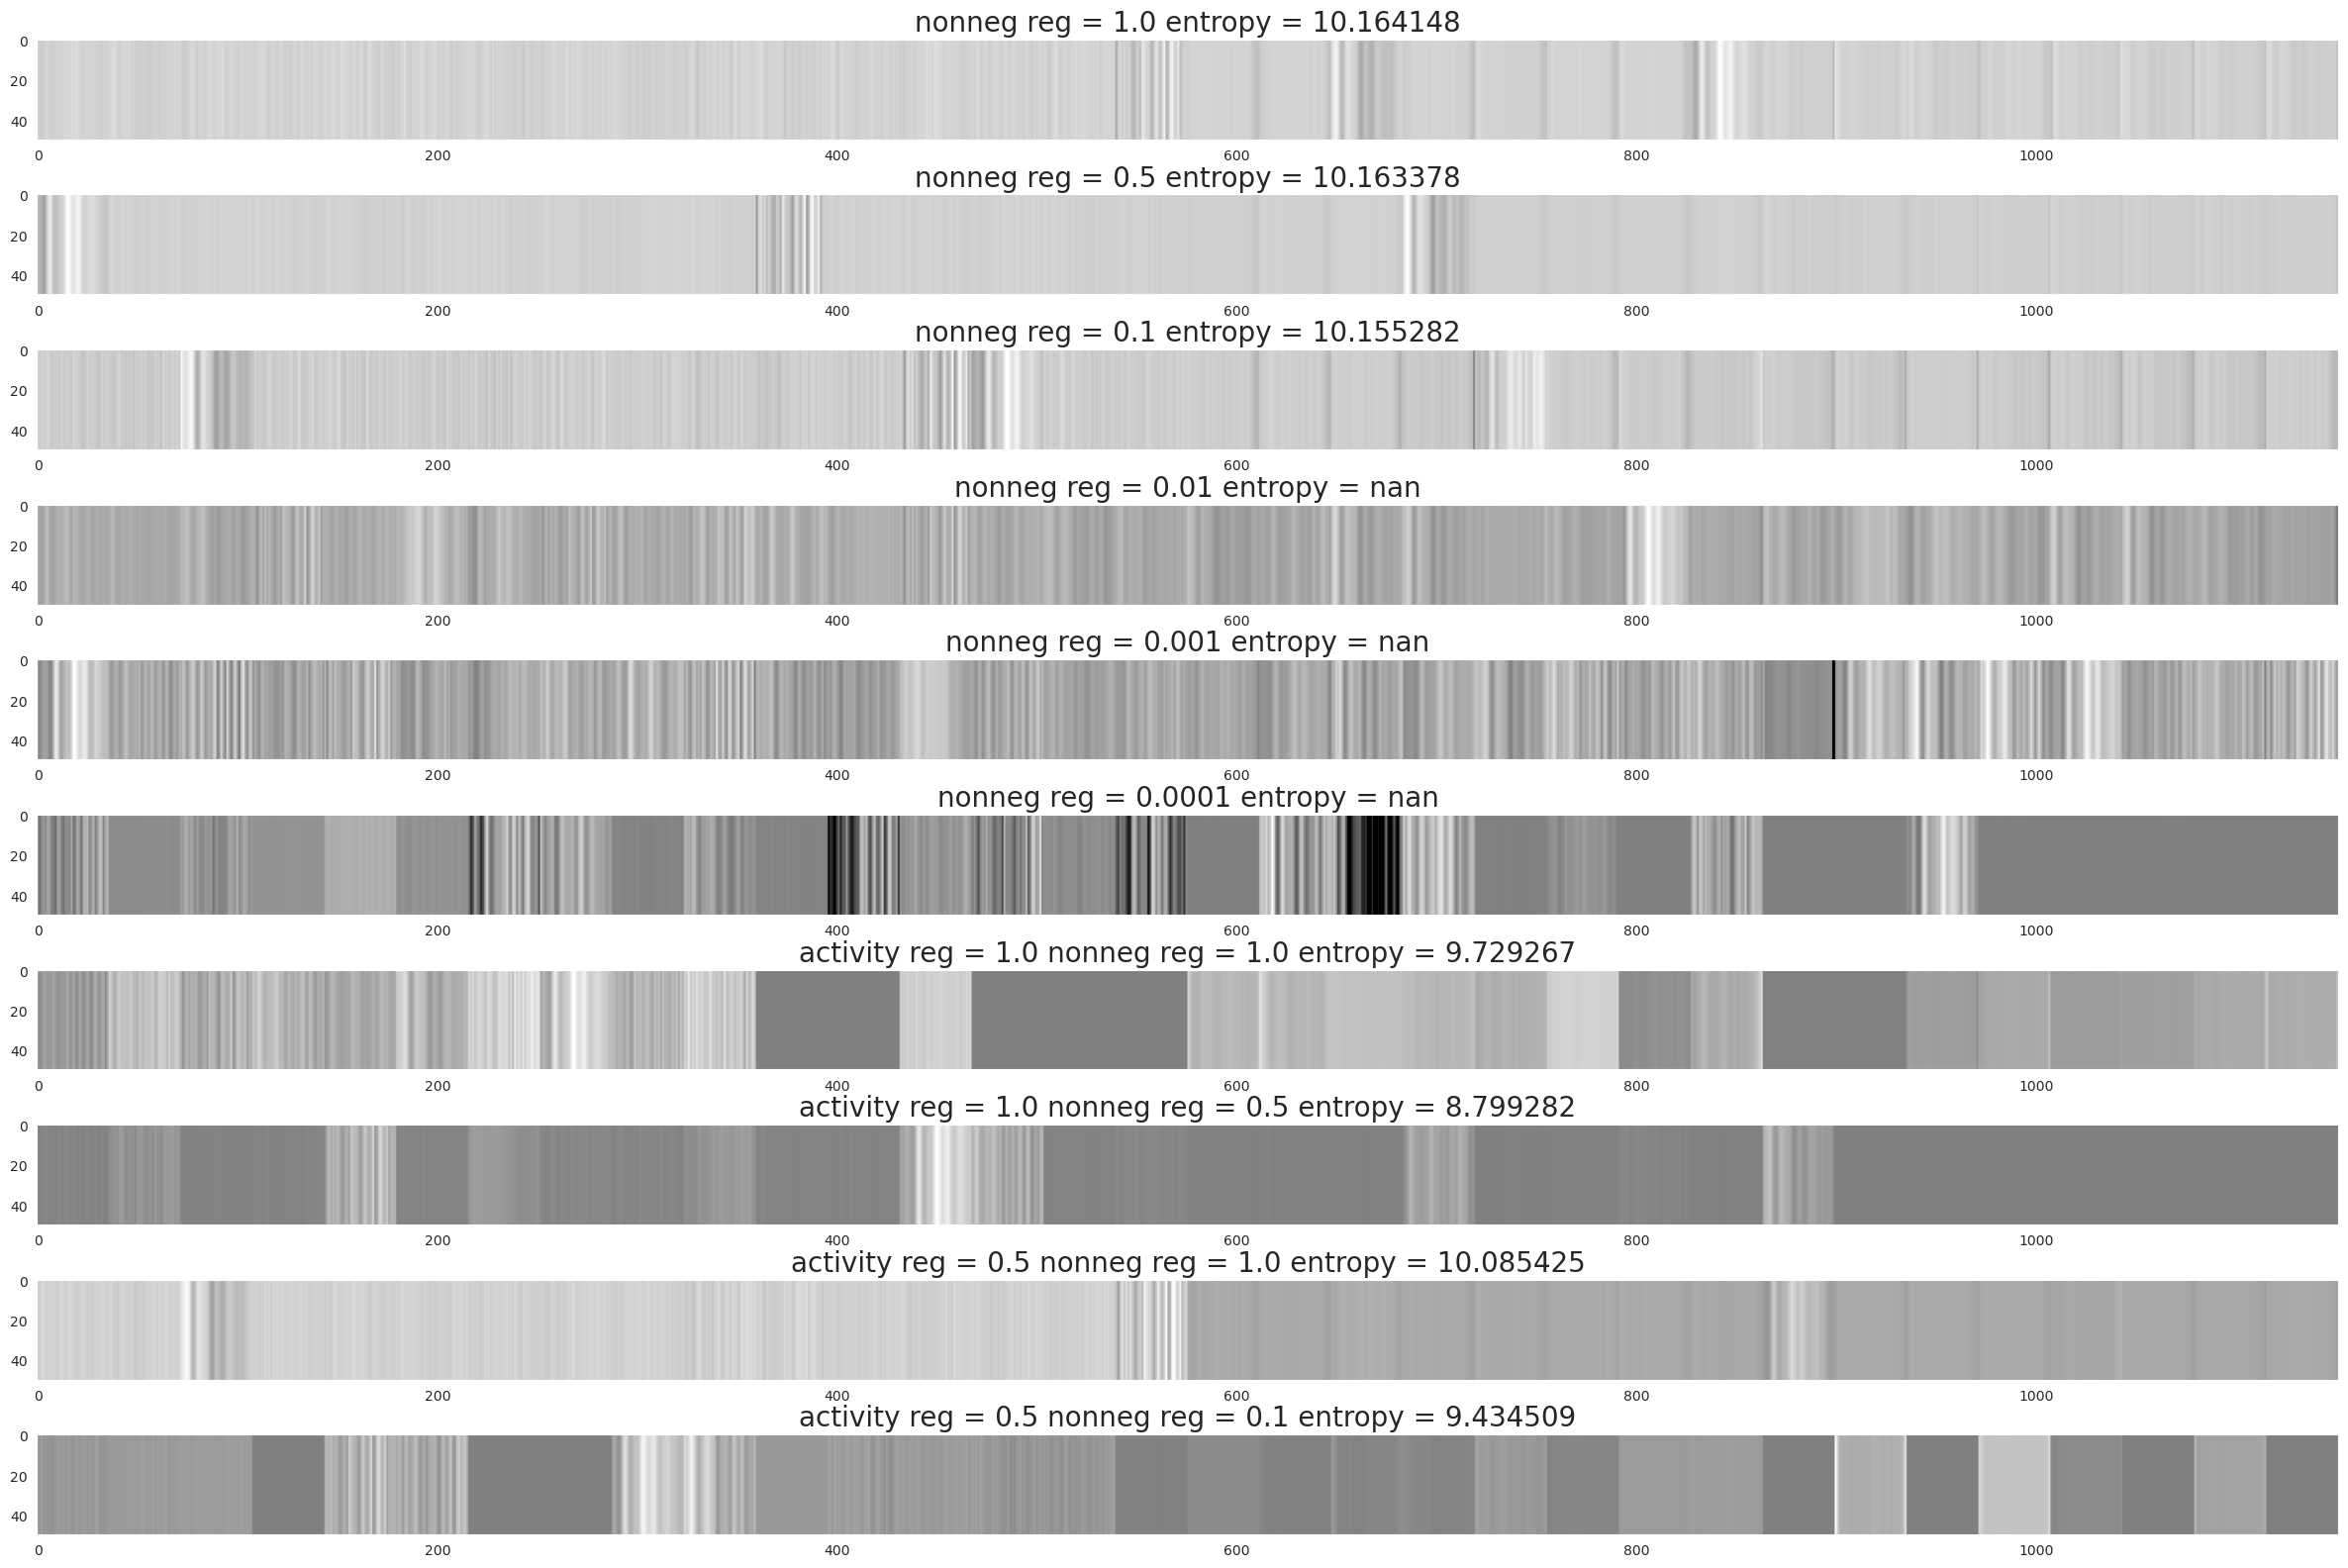

In [604]:
# compare the activity of the subunits and neurons for different reg values
# (concatenate the weights from all the layers)
# plot the weights for each trial
fig = plt.figure(figsize=(30,20))
# turn gridlines off
for i in range(len(e8.trials)):
    trial = e8.trials_where(name='cnim_scaffold'+str(i))[0]
    ax = fig.add_subplot(len(e5.trials),1,i+1)
    ax.grid(False) # turn gridlines off
    model = trial.model
    results = predict.predict(model,
                              dataset=trial.dataset[1000:1001],
                              network_names_to_use=['core'])
    im = np.concatenate([results.outputs[0]['core'][i] for i in range(len(results.outputs[0]['core']))], axis=1)
    im_entropy = entropy(im)
    im = np.repeat(im, 50, axis=0)
    imax = np.max(im)
    imin = -imax
    ax.imshow(im, cmap='gray', vmin=imin, vmax=imax)
    
    if 'activity' in trial.trial_params.keys() and 'nonneg' in trial.trial_params.keys():
        ax.set_title('activity reg = '+str(trial.trial_params['activity']) + ' nonneg reg = ' + str(trial.trial_params['nonneg']) + ' entropy = '+str(im_entropy), fontsize=20)
    elif 'activity' in trial.trial_params.keys() and 'nonneg' not in trial.trial_params.keys():
        ax.set_title('activity reg = ' + str(trial.trial_params['activity']) + ' entropy = '+str(im_entropy), fontsize=20)
    elif 'activity' not in trial.trial_params.keys() and 'nonneg' in trial.trial_params.keys():
        ax.set_title('nonneg reg = ' + str(trial.trial_params['nonneg']) + ' entropy = '+str(im_entropy), fontsize=20)

plt.show()

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


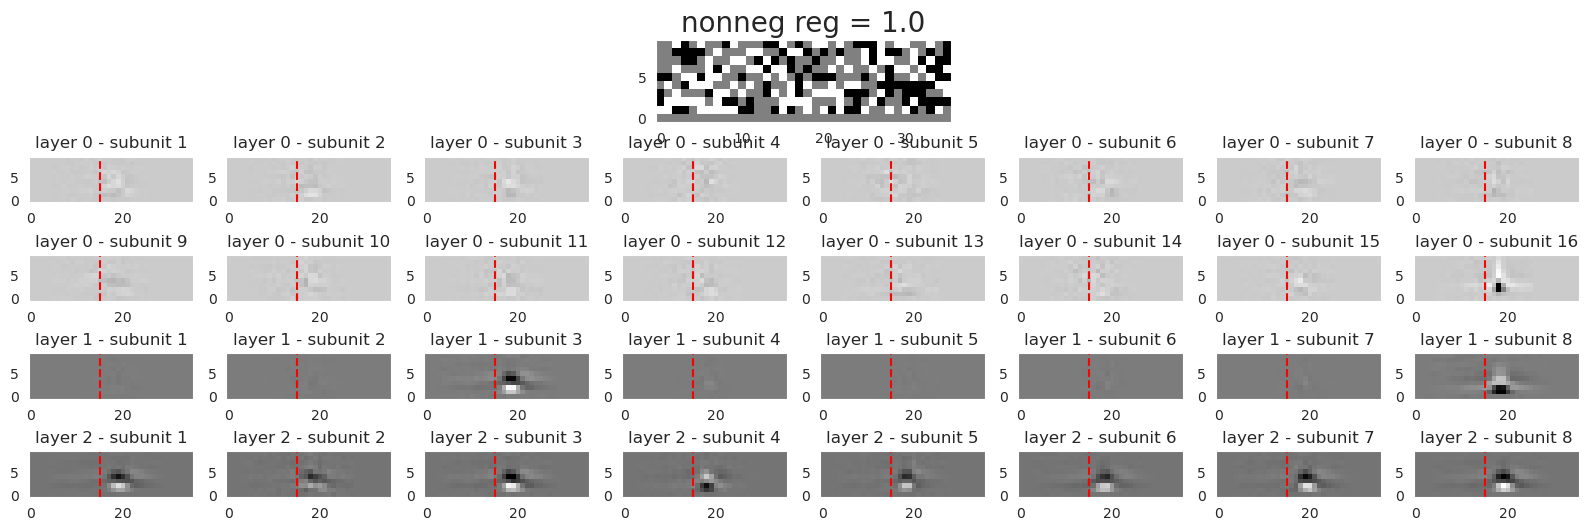

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


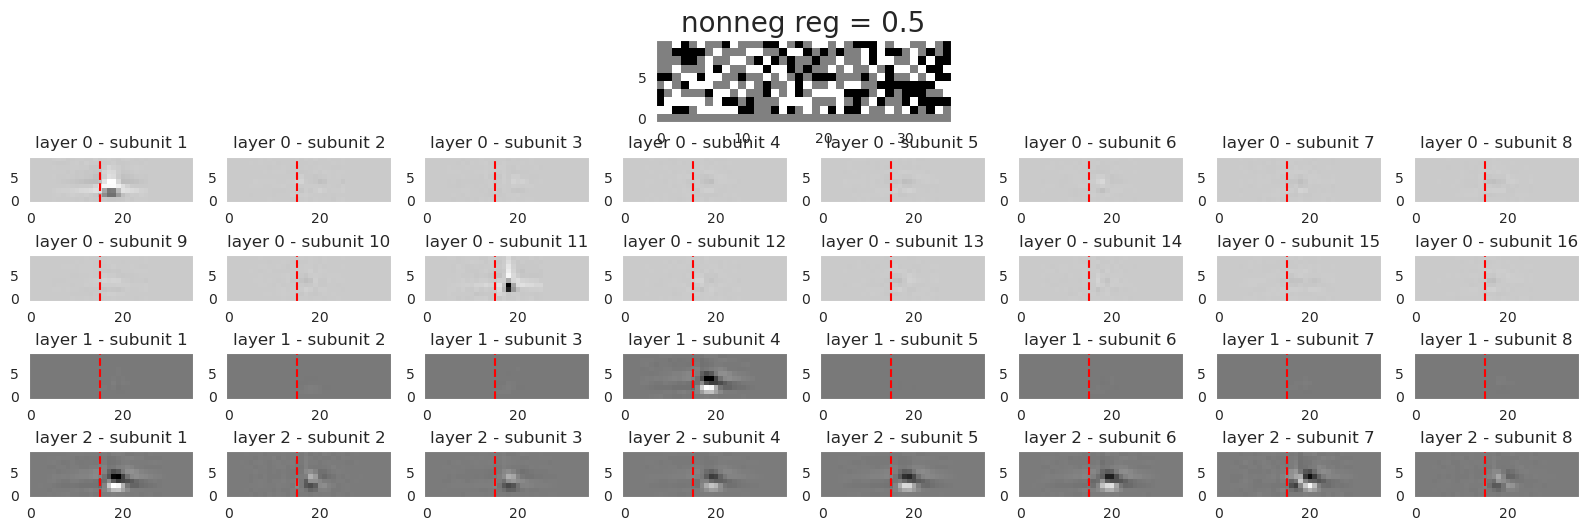

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


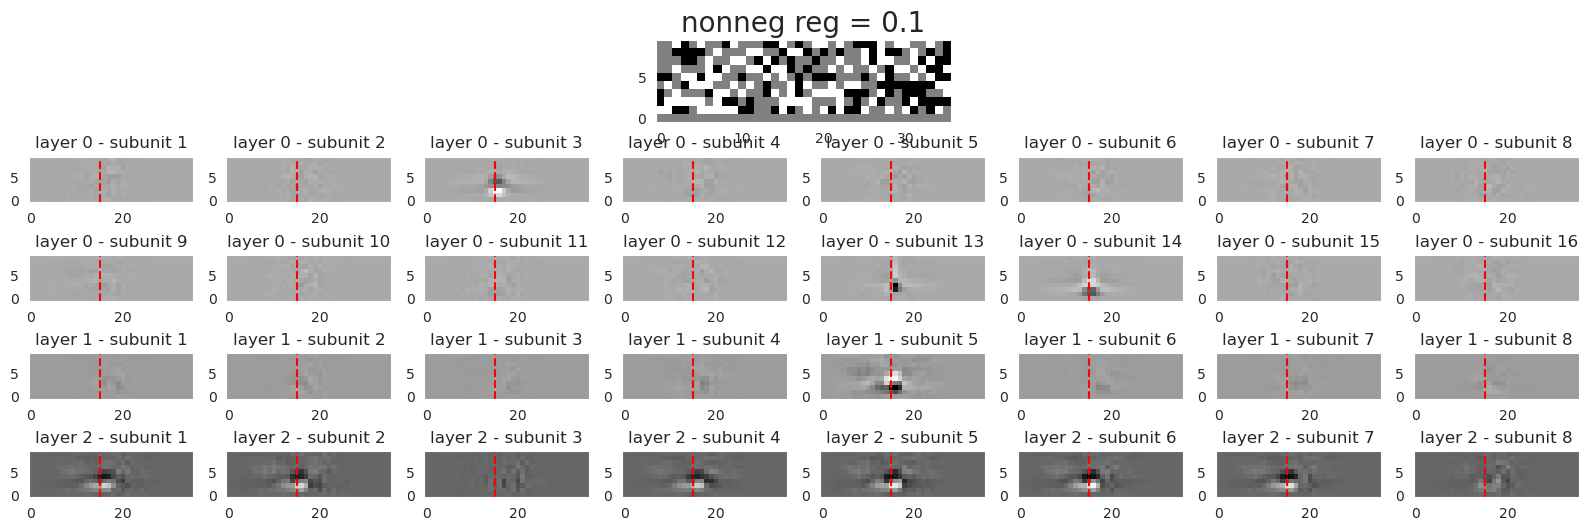

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


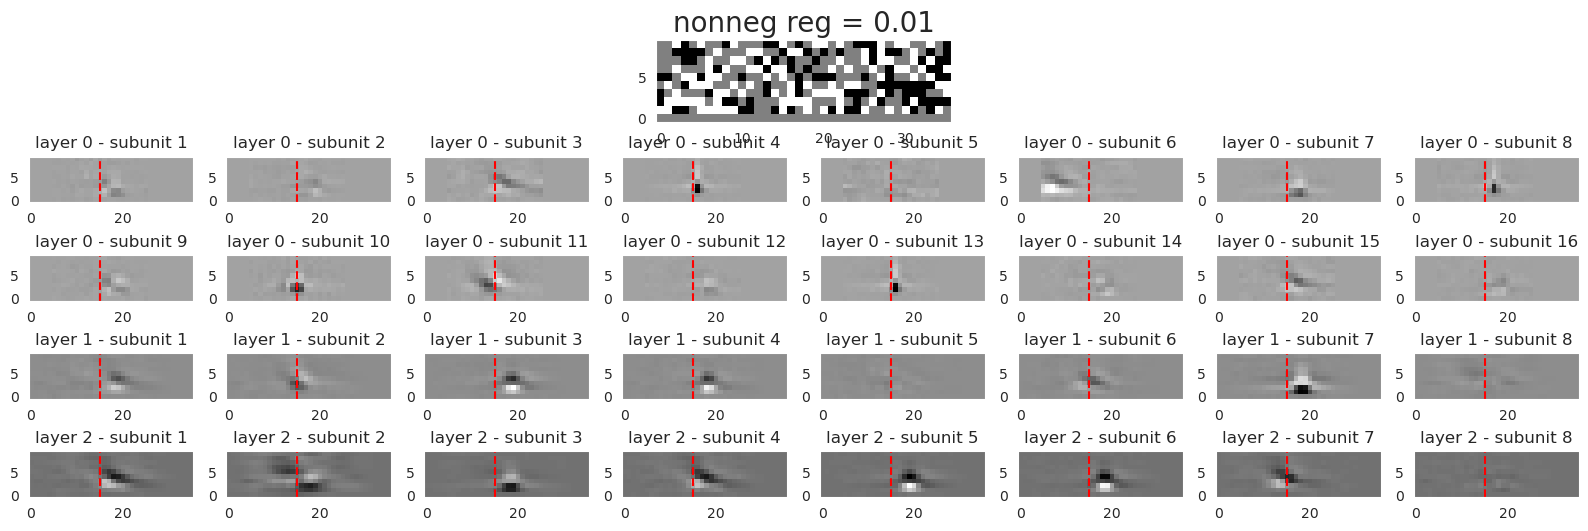

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


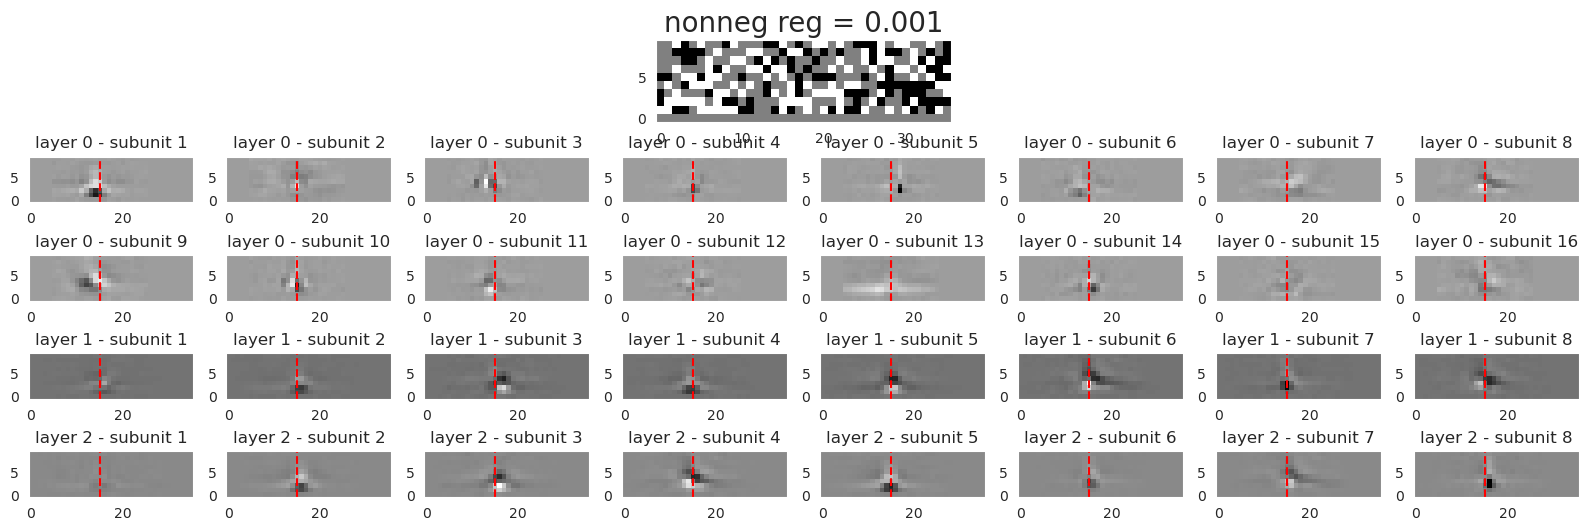

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


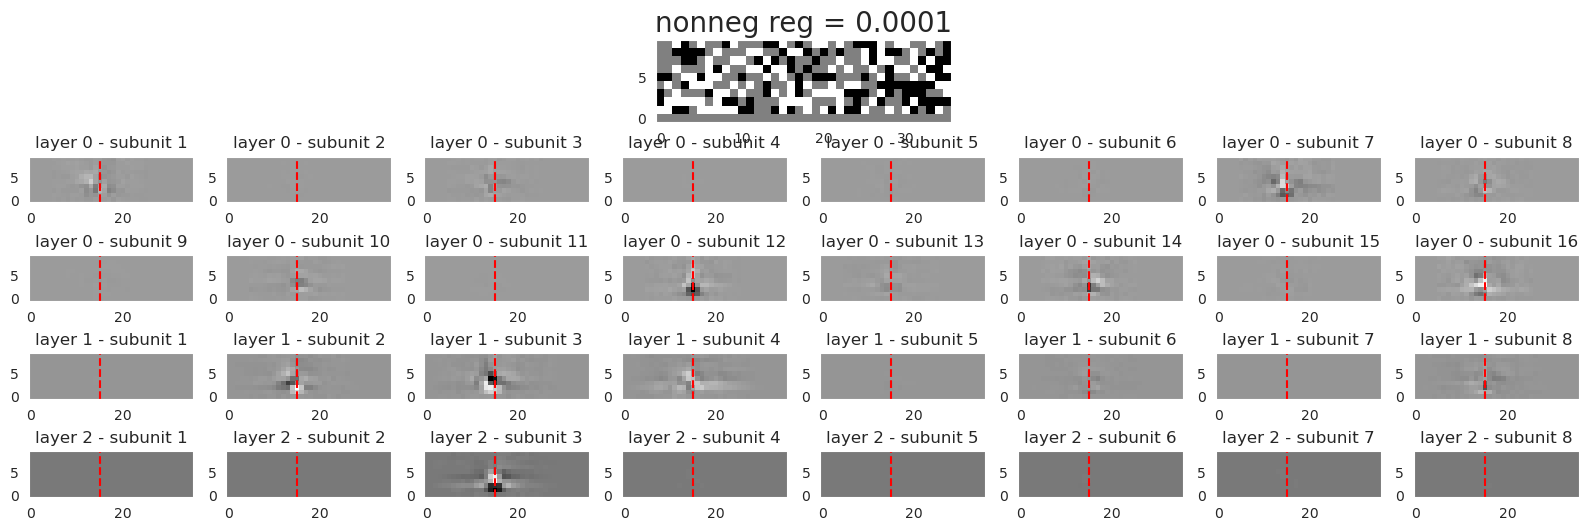

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


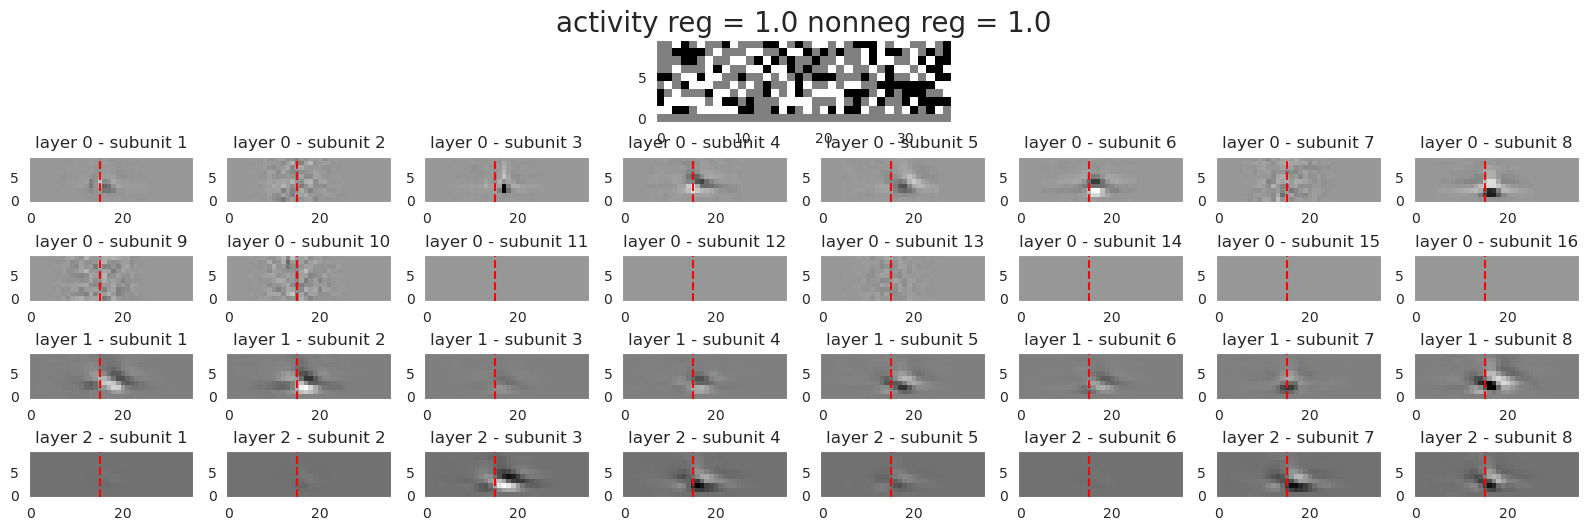

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


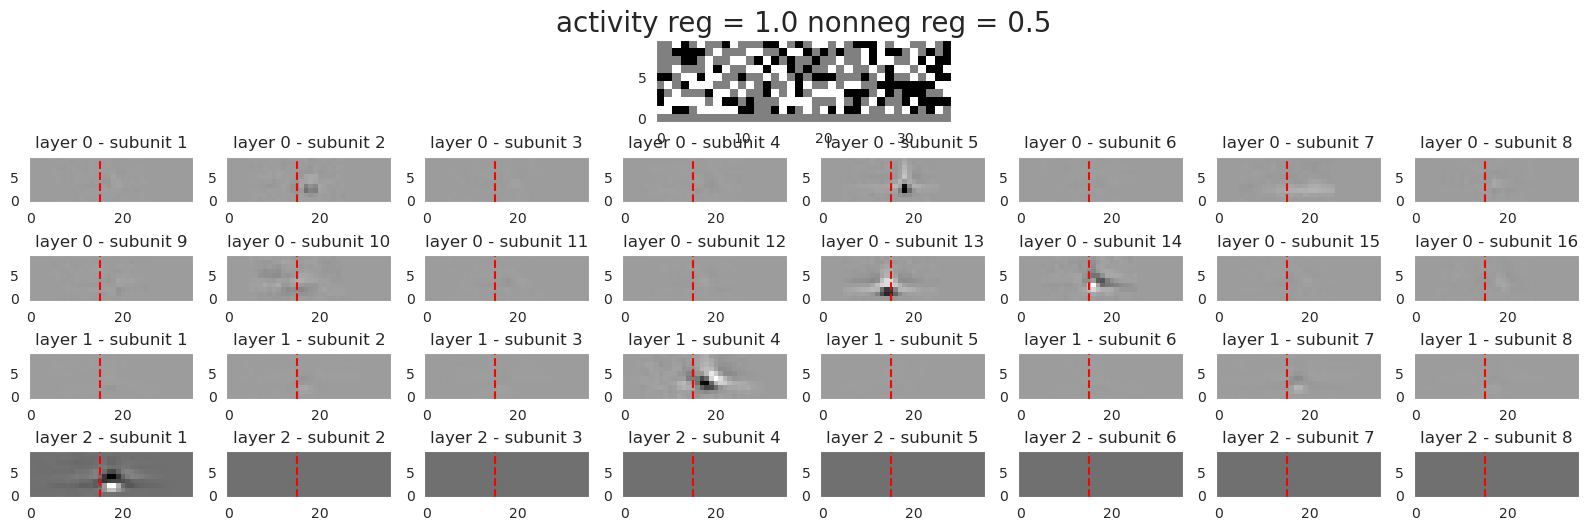

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


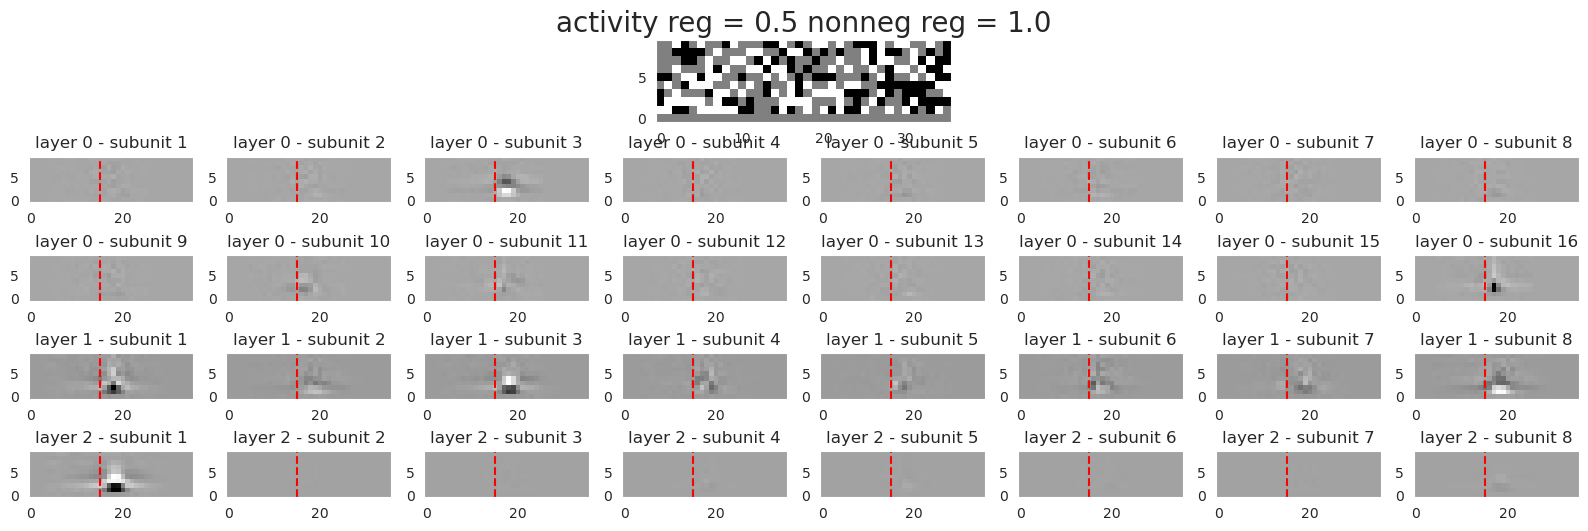

prev_output shape torch.Size([1, 360]) ni 0 NetworkType.scaffold li 0
prev_output shape torch.Size([1, 576]) ni 0 NetworkType.scaffold li 1
prev_output shape torch.Size([1, 288]) ni 0 NetworkType.scaffold li 2


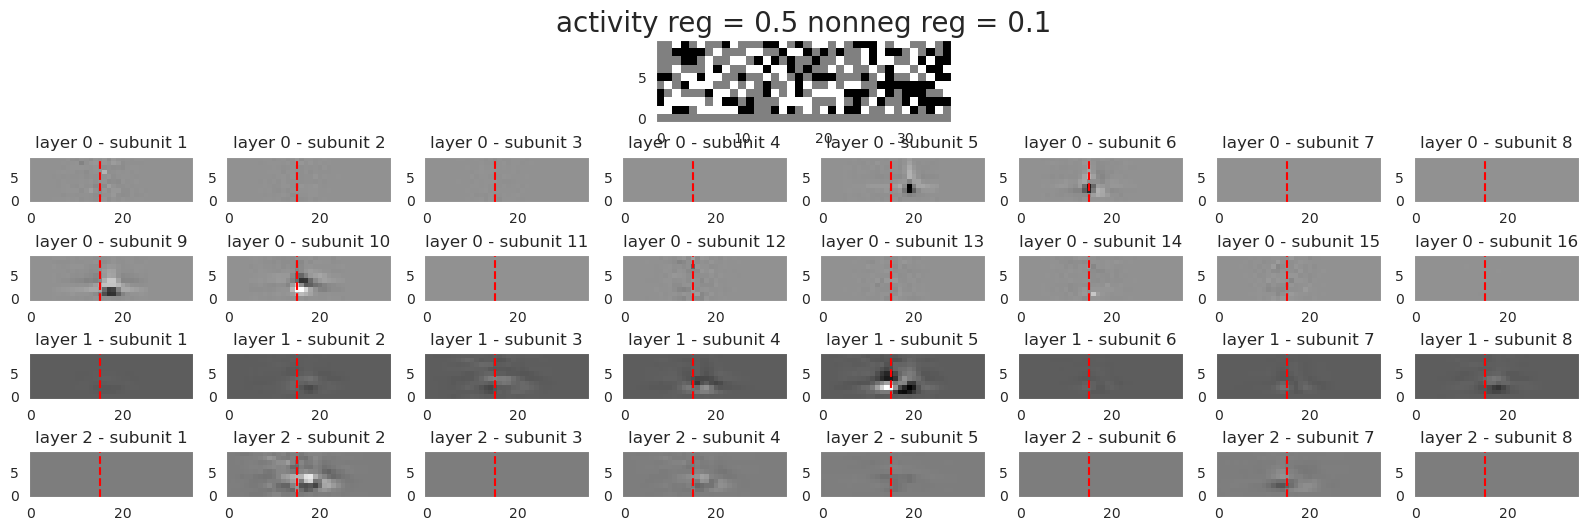

ValueError: num must be 1 <= num <= 10, not 11

In [605]:
# plot the Jacobians for each trial
# turn gridlines off
for i in range(len(e8.trials)):
    trial = e8.trials_where(name='cnim_scaffold'+str(i))[0]
    model = trial.model
    ax = fig.add_subplot(len(e5.trials),1,i+1)
    ax.grid(False) # turn gridlines off

    inps = trial.dataset.stim[start:end]
    t = 0

    results = predict.predict(model,
                              dataset=trial.dataset[1000:1001],
                              network_names_to_use=['core'])

    imins = []
    imaxs = []
    for l in range(3):
        imins.append(np.min(np.concatenate([results.jacobians[t]['core'][l][0,:].flatten() for i in range(start, end)])))
        imaxs.append(np.max(np.concatenate([results.jacobians[t]['core'][l][0,:,:].flatten() for i in range(start, end)])))

    num_subunits = [16, 8, 8]
    rows = 8
    cols = 8
    fig = plt.figure(figsize=(20,10))
    grid = plt.GridSpec(rows, cols)
    i = 0
    # plot the stim for the current time
    ax_stim = fig.add_subplot(grid[0, :])
    ax_stim.grid(False) # turn gridlines off
    ax_stim.imshow(inps[t].reshape(36,10).T, interpolation='none', cmap='gray', origin='lower')
    if 'activity' in trial.trial_params.keys() and 'nonneg' in trial.trial_params.keys():
        ax_stim.set_title('activity reg = '+str(trial.trial_params['activity']) + ' nonneg reg = ' + str(trial.trial_params['nonneg']), fontsize=20)
    elif 'activity' in trial.trial_params.keys() and 'nonneg' not in trial.trial_params.keys():
        ax_stim.set_title('activity reg = ' + str(trial.trial_params['activity']), fontsize=20)
    elif 'activity' not in trial.trial_params.keys() and 'nonneg' in trial.trial_params.keys():
        ax_stim.set_title('nonneg reg = ' + str(trial.trial_params['nonneg']), fontsize=20)

    for l in range(3):
        for u in range(num_subunits[l]):
            ax_cluster = fig.add_subplot(grid[i//cols+1, i%cols])
            subunit_jacobian = results.jacobians[t]['core'][l][0,36*u:36*(u+1),:]
            ax_cluster.imshow(subunit_jacobian[15].reshape(36,10).T,
                              vmin=imins[l], vmax=imaxs[l],
                              interpolation='none',
                              cmap='gray',
                              origin='lower')
            # draw a vertical line at point 15
            ax_cluster.axvline(x=15, color='r', linestyle='--')
            ax_cluster.set_title('layer ' + str(l) + ' - subunit ' + str(u+1))
            # turn gridlines off
            ax_cluster.grid(False)
            i += 1

    plt.show()